In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import pandas as pd
import collections
import lqg1d
import json

import gym
import cartpole
import policies
import fast_utils

import numba

# Function definitions

In [2]:
def load_dataframe(folder):
    experiments = []
    for experiment in glob.glob(os.path.join(folder, '*_params.json')):
        with open(experiment, 'r') as f:
            params = json.load(f)

        experiments.append({k.upper():i for k,i in params.items()})
    experiments_df = pd.DataFrame(experiments)
    experiments_df = experiments_df.fillna('-')
    
    return experiments_df

In [3]:
def load_from_dataframe(df):
    return [pd.read_pickle(f + '.gzip') for f in df['FILENAME'].values]
        

In [4]:
def filter_experiments(**kwargs):
    df_filtered = kwargs['df']
    for k,v in kwargs.items():
        if v is not None:
            try:
                if isinstance(v, list):
                    df_filtered = df_filtered[df_filtered[k.upper()].isin(v)]
                else:
                    df_filtered = df_filtered[df_filtered[k.upper()] == v]
            except:
                pass
    return df_filtered

In [31]:
def my_plot(**kwargs):
    data_params = filter_experiments(**kwargs)
    
    free_vars = []
    for k,v in kwargs.items():
        if v is None or (k.upper() in data_params.columns and isinstance(v, list)):
            free_vars.append(k)

    free_vars = [s.upper() for s in free_vars]
    
    if len(free_vars) <= 0:
        data_params = data_params.sort_values(by=list(data_params.columns), ascending=False)
    else:
        data_params = data_params.sort_values(by=free_vars, ascending=False)

    data = load_from_dataframe(data_params)

    plt.rcParams["figure.figsize"] = (15,13)
    
    def plot_lines(**kwargs):
        MAX_T = kwargs['max_t'] if 'max_t' in kwargs else -1
        MIN_T = kwargs['min_t'] if 'min_t' in kwargs else 0
        STEP = kwargs['step'] if 'step' in kwargs else 1
        ALPHA = kwargs['alpha'] if 'alpha' in kwargs else 1
        X_DIM = kwargs['x'] if 'x' in kwargs else 'T'

        if isinstance(kwargs['value'], list):
            params = kwargs
            ll = len(kwargs['value'])
            i = 1
            for v in kwargs['value']:
                plt.subplot((ll + 1)//2, 2, i)
                i+=1
                params['value'] = v
                plot_lines(**params)
        else:
            for i,d in enumerate(data):
                d['J+J_DET'] = d['J'] + d['J_DET']
                d['J_JOURNEY+J_DET'] = d['J_JOURNEY'] + d['J_DET']
                
                d['SAMPLES'] = int(data_params.iloc[i]['N_MIN']) * d['T'].values
                try:
                    x = d[X_DIM].values[MIN_T:MAX_T:STEP] // STEP
                    y = d[kwargs['value']].values[MIN_T:MAX_T:STEP]
                    
                    if ('smooth' in kwargs) and (kwargs['value'] in kwargs['smooth']):
                        amount = kwargs['amount'] if 'amount' in kwargs else 10
                        y = np.convolve(y/amount, np.ones(amount), mode='valid')
                        x = x[:-amount+1]
                    
                except:
                    x = d[X_DIM].values[MIN_T:MAX_T:STEP] // STEP
                    y = np.zeros(x.shape[0])
                
                plt.plot(x, y, alpha=ALPHA)
                plt.xlabel('Timesteps')
                plt.ylabel(kwargs['value'])
                plt.title(kwargs['value'])
                
                if kwargs['value'] == 'J+J_DET':
                    plt.plot(x, [d['J+J_DET'][0]]*len(x), 'r-', label='_nolegend_')
                    print('Initial J+J_DET is: ', d['J+J_DET'][0])
                    print('Average J+J_DET is: ', np.average(d['J+J_DET']))
                if kwargs['value'] == 'J_JOURNEY+J_DET':
                    plt.plot(x, [d['J_JOURNEY+J_DET'][0]]*len(x), 'r-', label='_nolegend_')
                if kwargs['value'] == 'BUDGET':
                    plt.plot(x, [0]*len(x), 'r-', label='_nolegend_')
                    print('Budget is negative for: ', sum(d['BUDGET']<0), '/', d['BUDGET'].shape[0], ' times')
                if kwargs['value'] == 'J_JOURNEY':
                    plt.plot(x, [d['J_JOURNEY'][0]]*len(x), 'r-', label='_nolegend_')
                if kwargs['value'] == 'GRAD_DELTAW':
                    plt.plot(x, [0]*len(x), 'r-', label='_nolegend_')

    plot_lines(**kwargs)
    
    # Build legend

    legend = [' '.join(map(lambda x : ': '.join((x[0], x[1] if x[1] is not np.nan else '-')), zip(data_params.loc[:,free_vars].columns.values, s))) for s in data_params.loc[:,free_vars].values]

    plt.legend(legend, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

        

In [100]:
d = filter_experiments(df=df_final, name=['MonotonicZeroBudgetEveryStep_2', 'MonotonicZeroBudgetEveryStep_4', 'MonotonicZeroBudgetEveryStep_5', 'MonotonicZeroBudgetEveryStep_3', 'MonotonicZeroBudgetEveryStep_1'])

In [115]:
d = filter_experiments(df=df_final, name=[
        'ExpBudget_DetPolicy_2', 
    'ExpBudget_DetPolicy_4', 
    'ExpBudget_DetPolicy_5', 
    'ExpBudget_DetPolicy_3'])

In [156]:
dfs = load_from_dataframe(d)
npys = np.array([x.values for x in dfs])
avgd = npys.mean(axis=0)
vard = 2*npys.std(axis=0)

dd = pd.DataFrame(avgd, columns=dfs[0].columns)

In [157]:
vard = pd.DataFrame(vard, columns=dfs[0].columns)

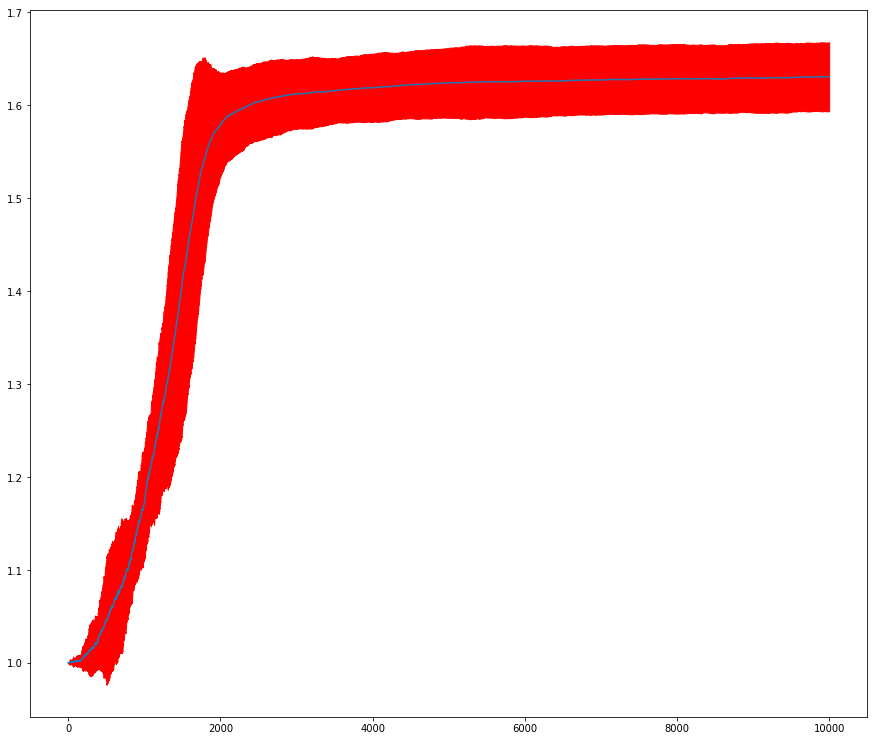

In [158]:
downsample = 1
feat = 'SIGMA'

plt.plot(dd['T'], dd[feat])
#plt.fill_between(dd['T'], dd['J_DET']-vard['J_DET'], dd['J_DET']+vard['J_DET'], color='r')

plt.fill_between(dd['T'][::downsample], dd[feat][::downsample]-vard[feat][::downsample], dd[feat][::downsample]+vard[feat][::downsample], color='r')

#plt.errorbar(dd['T'][::downsample], dd[feat][::downsample], -vard[feat][::downsample], vard[feat][::downsample])

# Load experiments

In [171]:
BASE_FOLDER = 'experiments'

experiments_df = load_dataframe(BASE_FOLDER)

## Results

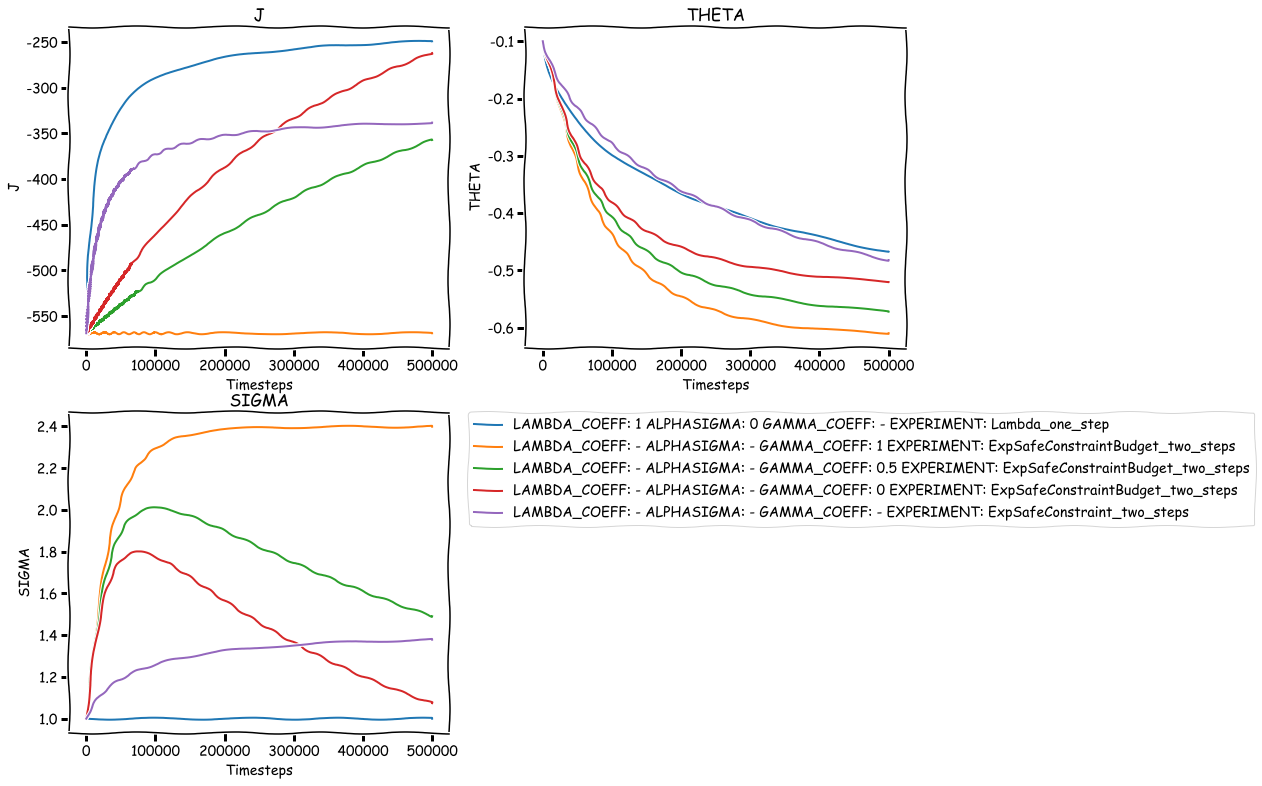

In [172]:
my_plot(lambda_coeff=['-', '1'], 
        theta='-0.1', 
        alphaSigma = ['-', '0'], 
        gamma_coeff = ['0', '0.5','1','-'],
        experiment=['ExpSafeConstraintBudget_two_steps', 'Lambda_one_step', 'ExpSafeConstraint_two_steps'],
        sigma='e(0)',
        value=['J', 'THETA', 'SIGMA'], 
        min_t = 0,
        max_t = -1,
        df = experiments_df)

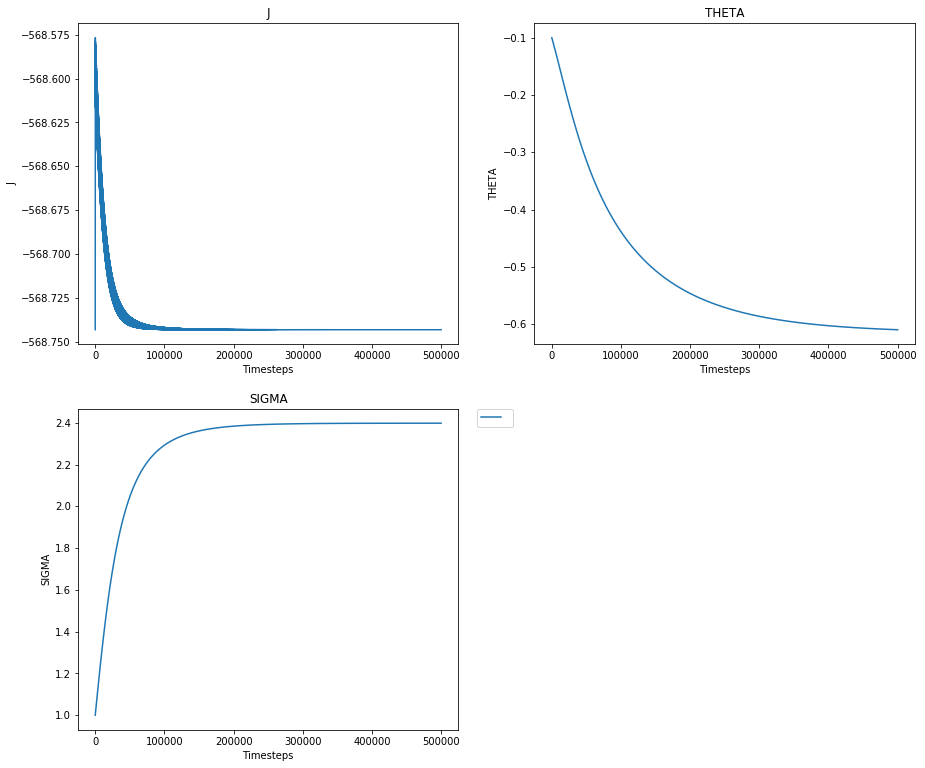

In [9]:
my_plot(lambda_coeff='-', 
        theta='-0.1', 
        alphaSigma = '-', 
        experiment='ExpSafeConstraintBaseline_two_steps',
        sigma='e(0)',
        value=['J', 'THETA', 'SIGMA'], 
        max_t=-1,
        df = experiments_df)

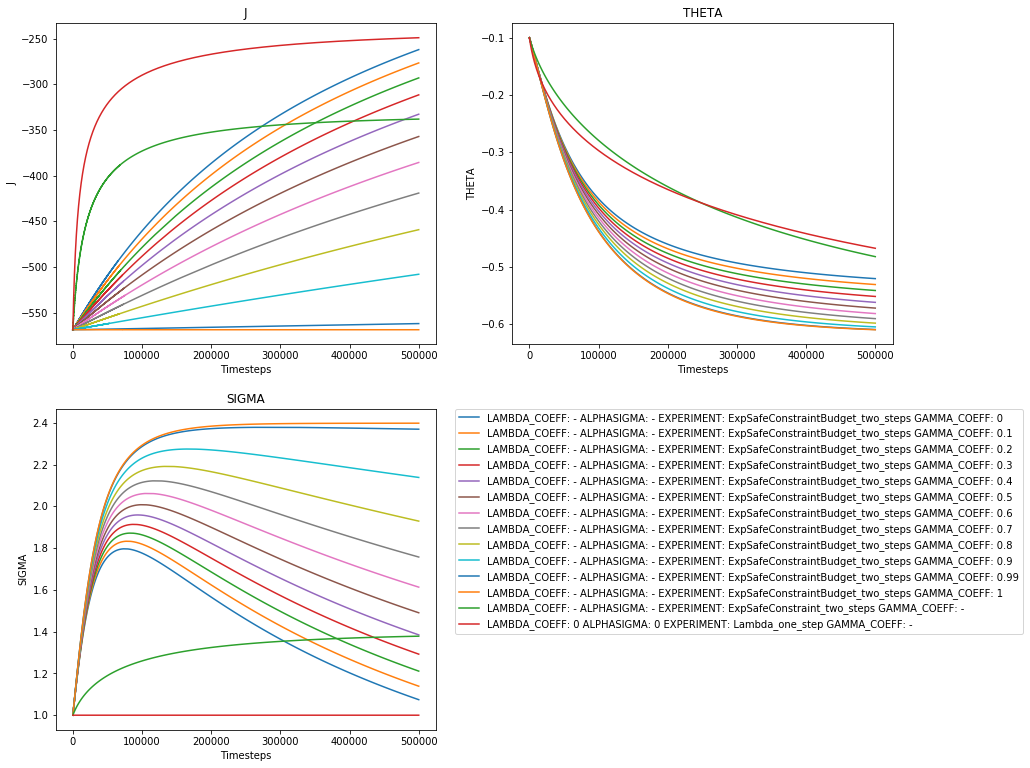

In [10]:
my_plot(lambda_coeff = ['-', '0'], 
        theta='-0.1', 
        alphaSigma = ['-', '0'], 
        experiment=['ExpSafeConstraintBudget_two_steps', 'ExpSafeConstraint_two_steps', 'Lambda_one_step'],
        gamma_coeff=None,
        sigma='e(0)',
        value=['J', 'THETA', 'SIGMA'], 
        max_t=-1,
        df = experiments_df)

# Experiments long

In [55]:
BASE_FOLDER = 'experiments_long'

experiments_df = load_dataframe(BASE_FOLDER)

## Results mixed

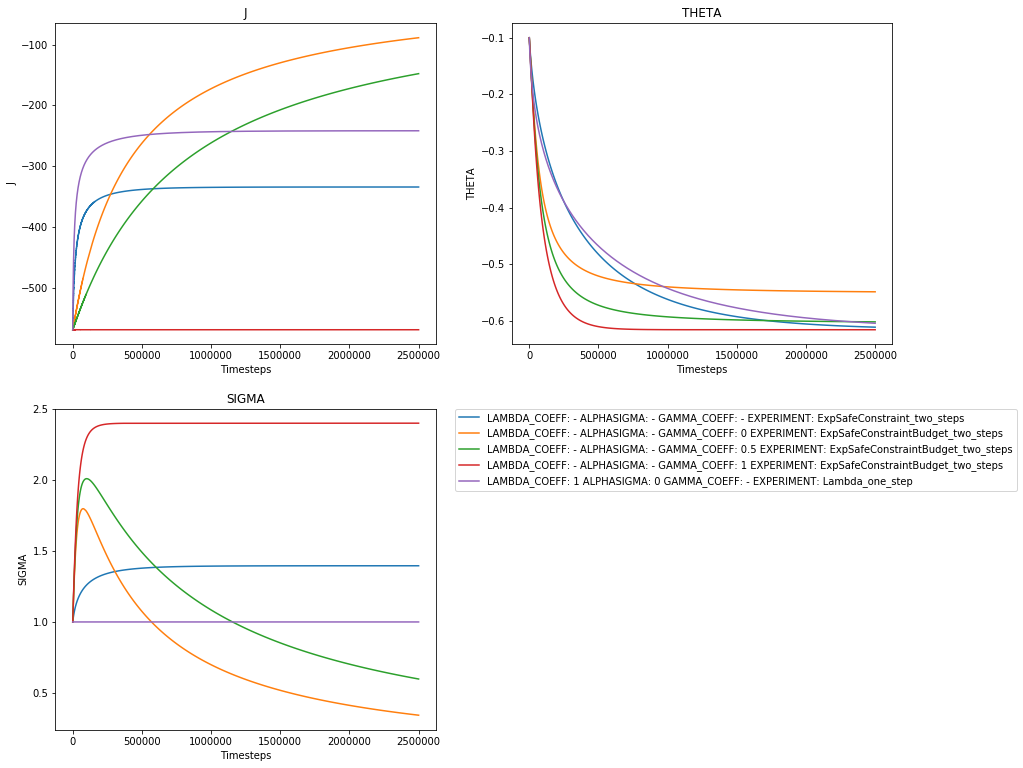

In [16]:
my_plot(lambda_coeff=['-', '1'], 
        theta='-0.1', 
        alphaSigma = ['-', '0'], 
        gamma_coeff = ['0', '0.5','1','-'],
        experiment=['ExpSafeConstraintBudget_two_steps', 'Lambda_one_step', 'ExpSafeConstraint_two_steps'],
        sigma='e(0)',
        value=['J', 'THETA', 'SIGMA'], 
        min_t = 0,
        max_t = -1,
        df = experiments_df)

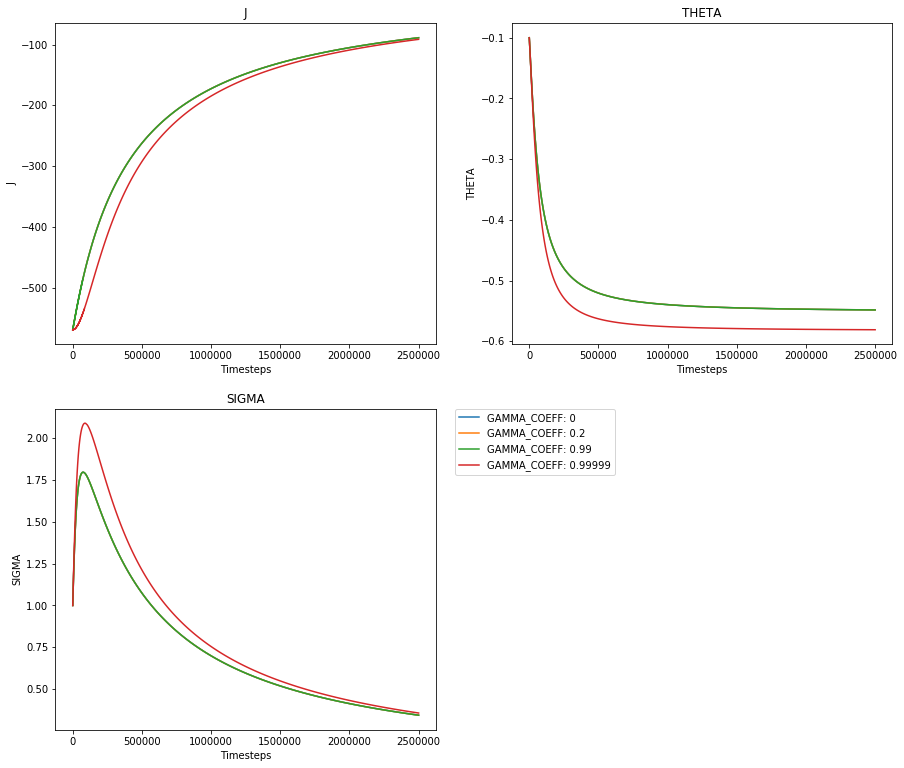

In [20]:
my_plot(lambda_coeff='-', 
        theta='-0.1', 
        alphaSigma = '-', 
        gamma_coeff = ['0', '0.2', '0.99', '0.99999'],
        experiment='ExpSafeConstraintBudget_new',
        sigma='e(0)',
        value=['J', 'THETA', 'SIGMA'], 
        min_t = 0,
        max_t = -1,
        df = experiments_df)

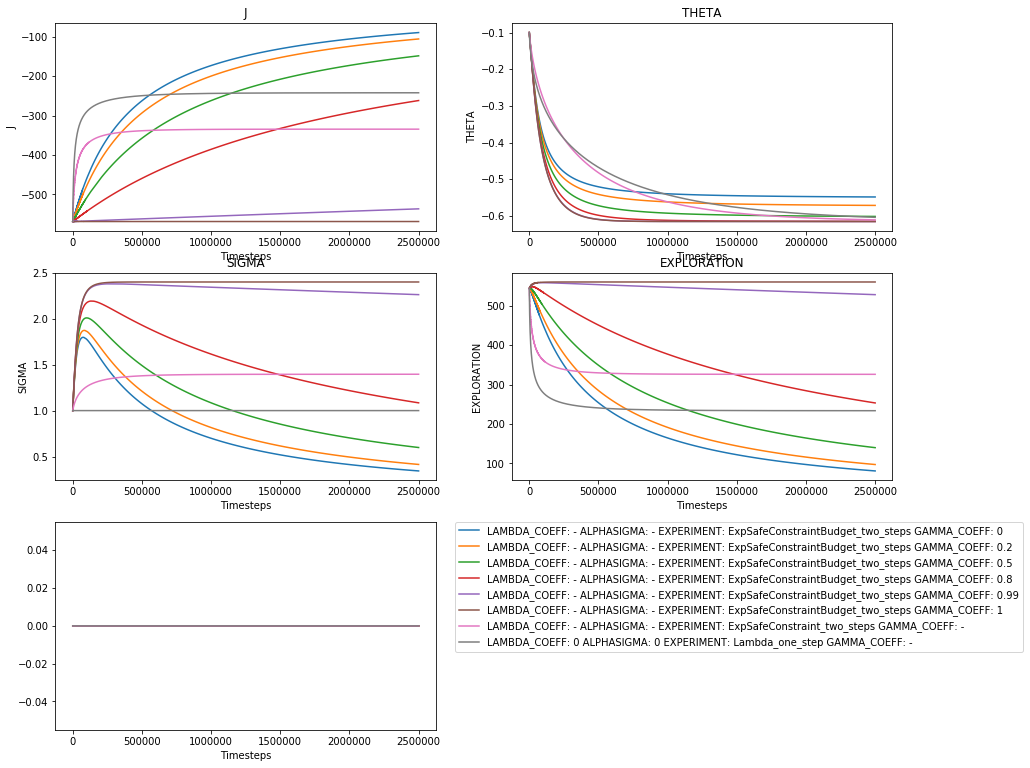

In [188]:
my_plot(lambda_coeff = ['-', '0'], 
        theta='-0.1', 
        alphaSigma = ['-', '0'], 
        experiment=['ExpSafeConstraintBudget_two_steps', 'ExpSafeConstraint_two_steps', 'Lambda_one_step'],
        gamma_coeff=None,
        sigma='e(0)',
        value=['J', 'THETA', 'SIGMA', 'EXPLORATION', ''], 
        max_t=-1,
        df = experiments_df)

## Deterministic policy

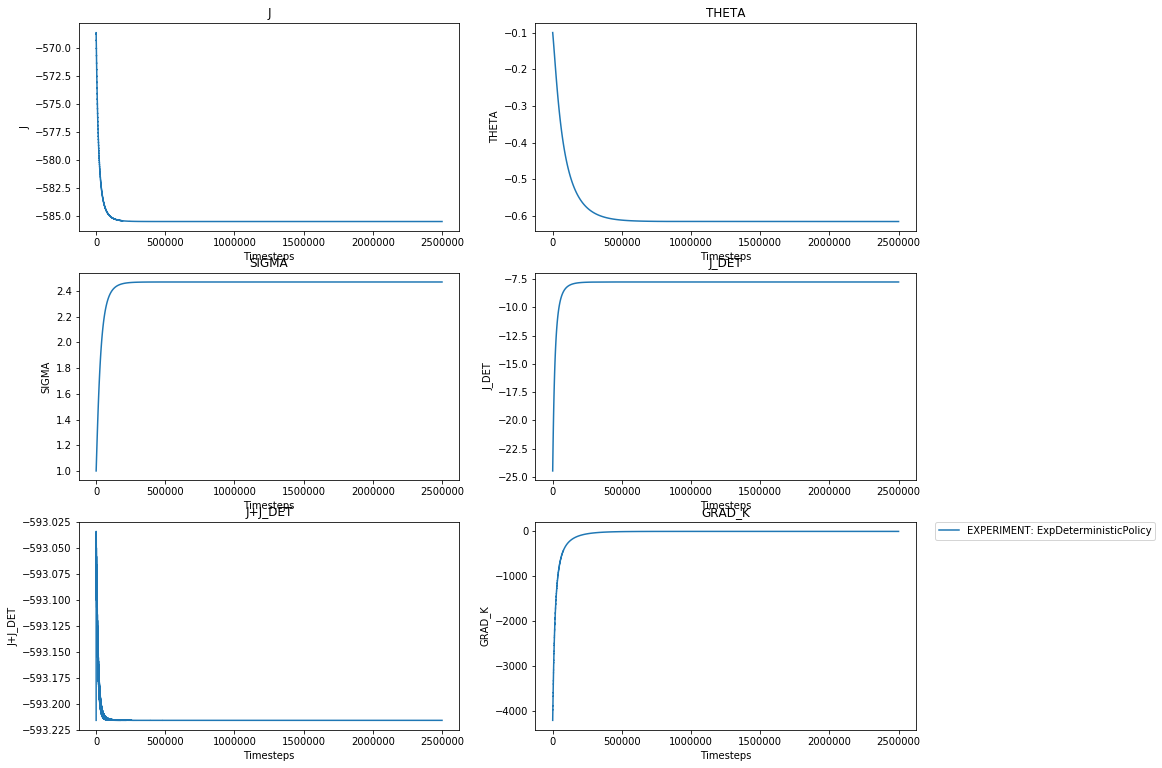

In [27]:
my_plot(lambda_coeff='-', 
        theta='-0.1', 
        alphaSigma = '-', 
        experiment=['ExpDeterministicPolicy'],
        sigma='e(0)',
        value=['J', 'THETA', 'SIGMA', 'J_DET', 'J+J_DET', 'GRAD_K'], 
        max_t=-1,
        df = experiments_df)

## Comparison with discounted deterministic policy

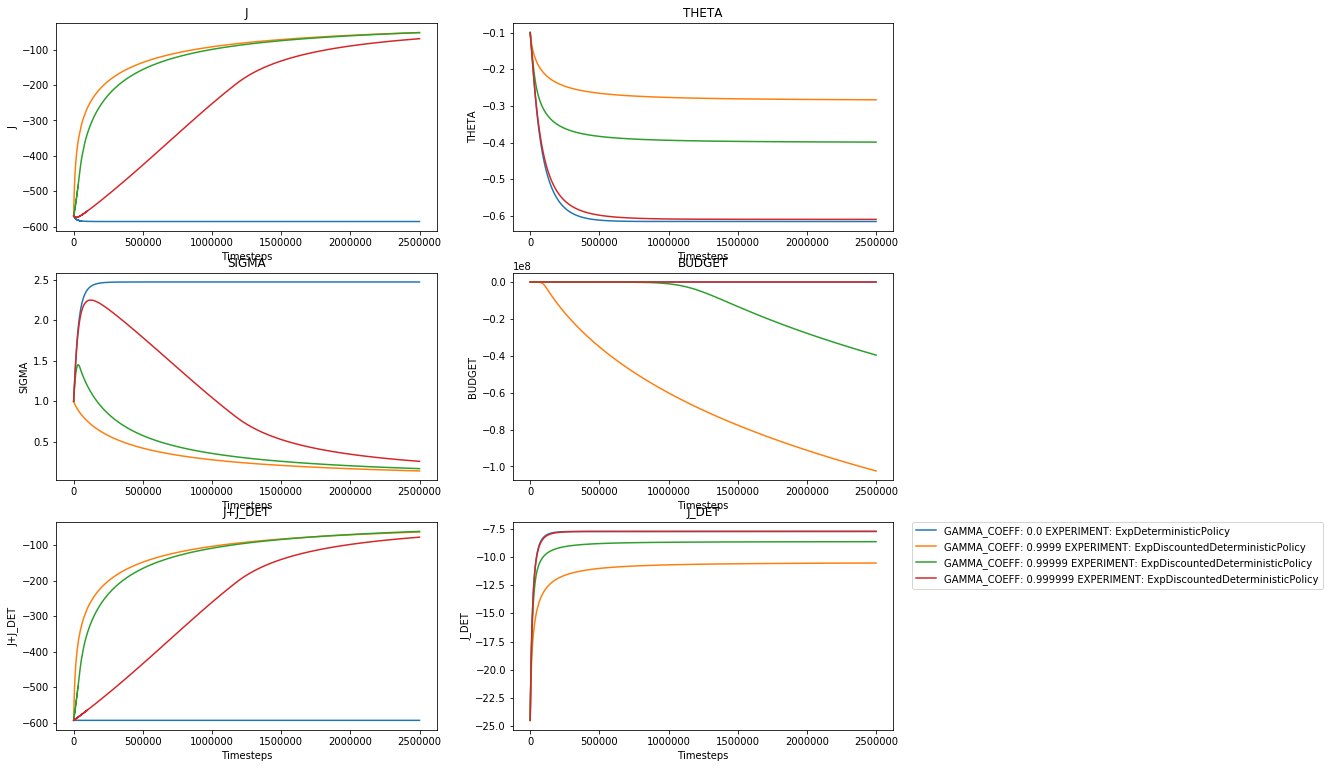

In [33]:
my_plot(lambda_coeff='-', 
        theta='-0.1', 
        alphaSigma = '-', 
        gamma_coeff = None,
        experiment=['ExpDiscountedDeterministicPolicy', 'ExpDeterministicPolicy'],
        sigma='e(0)',
        value=['J', 'THETA', 'SIGMA', 'BUDGET', 'J+J_DET', 'J_DET'], 
        min_t = 0,
        max_t = -1,
        df = experiments_df)

## Fixed cost deterministic policy

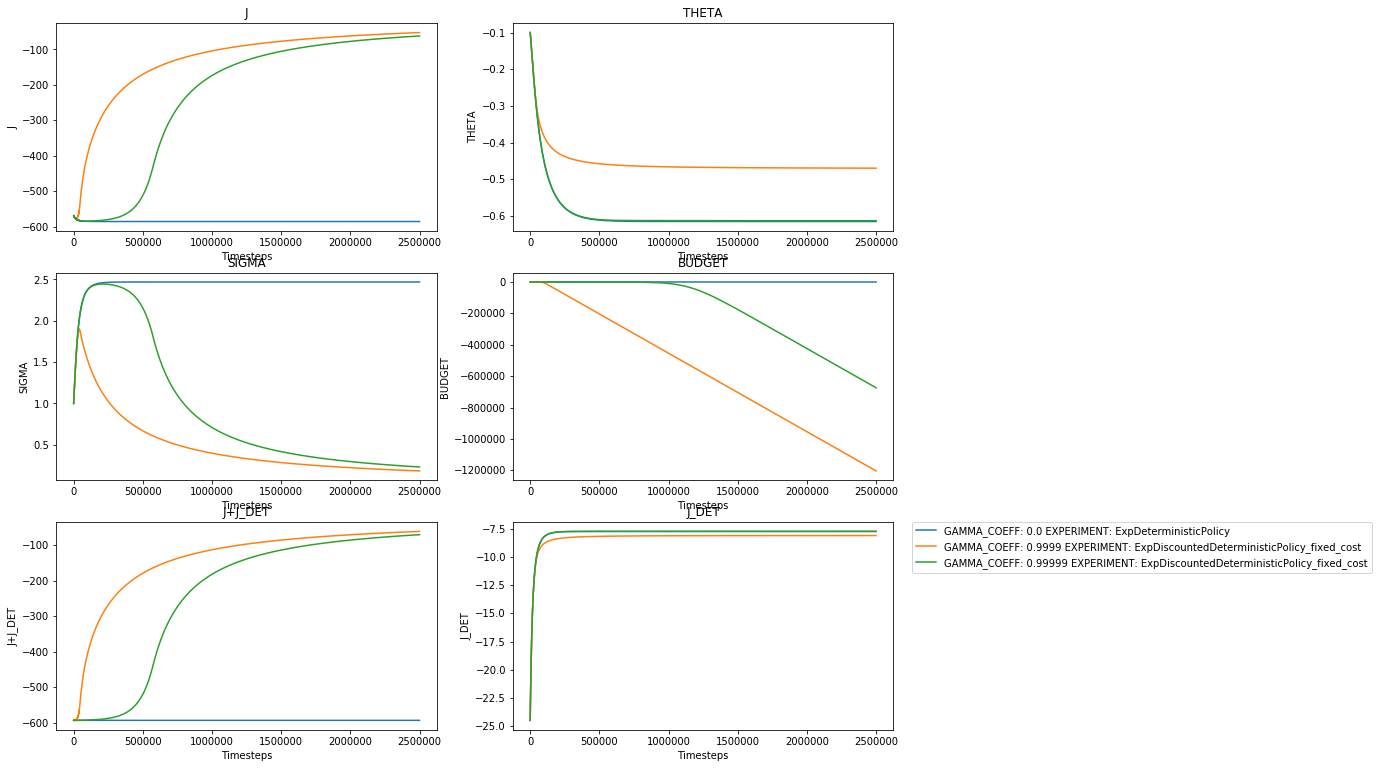

In [36]:
my_plot(lambda_coeff='-', 
        theta='-0.1', 
        alphaSigma = '-', 
        gamma_coeff = None,
        experiment=['ExpDiscountedDeterministicPolicy_fixed_cost', 'ExpDeterministicPolicy'],
        sigma='e(0)',
        value=['J', 'THETA', 'SIGMA', 'BUDGET', 'J+J_DET', 'J_DET'], 
        min_t = 0,
        max_t = -1,
        df = experiments_df)

## Experiments with random baselines

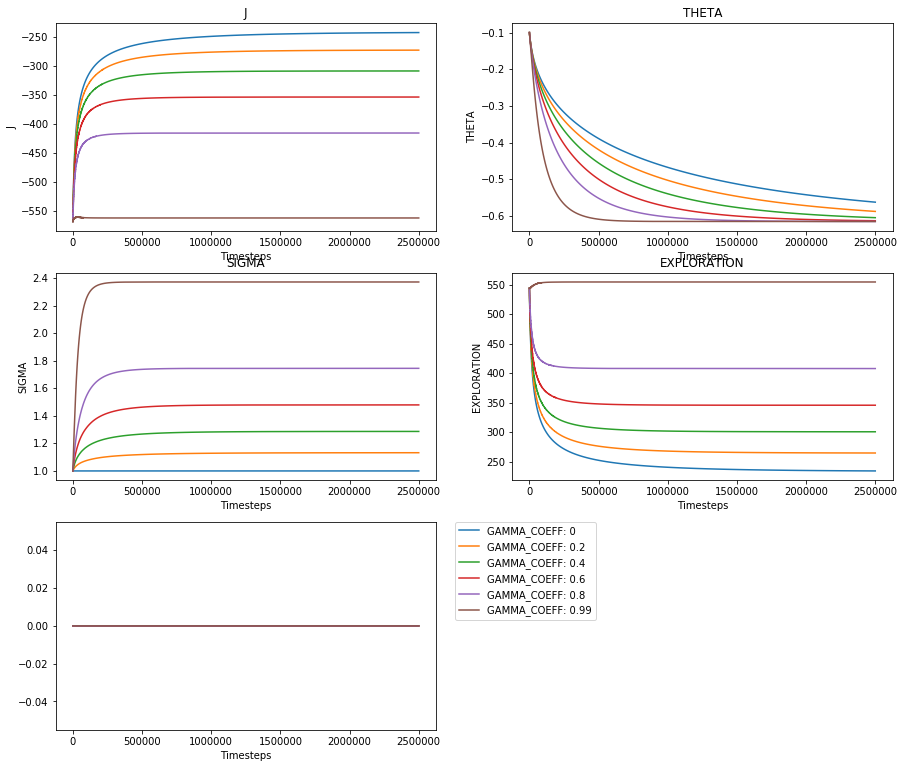

In [54]:
my_plot(lambda_coeff = '-', 
        theta='-0.1', 
        alphaSigma = '-', 
        experiment='ExpProbablyDeterministicPolicyBaseline',
        gamma_coeff=None,
        sigma='e(0)',
        value=['J', 'THETA', 'SIGMA', 'EXPLORATION', ''], 
        max_t=-1,
        df = experiments_df)

## Experiments with constant online factor

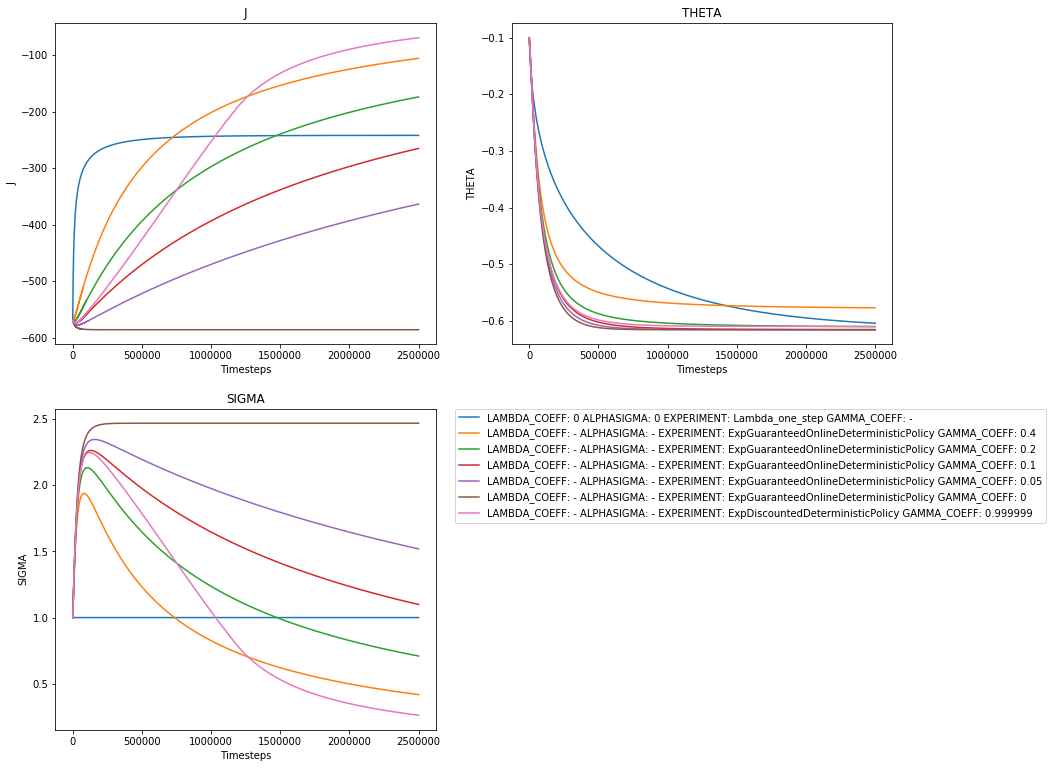

In [152]:
my_plot(lambda_coeff = ['0', '-'], 
        theta='-0.1', 
        alphaSigma = ['0', '-'], 
        experiment=['ExpGuaranteedOnlineDeterministicPolicy', 'Lambda_one_step', 'ExpDiscountedDeterministicPolicy'],
        gamma_coeff=['0', '0.05', '0.1', '0.2', '0.4', '0.999999', '-'],
        sigma='e(0)',
        value=['J', 'THETA', 'SIGMA'], 
        max_t=-1,
        df = experiments_df)

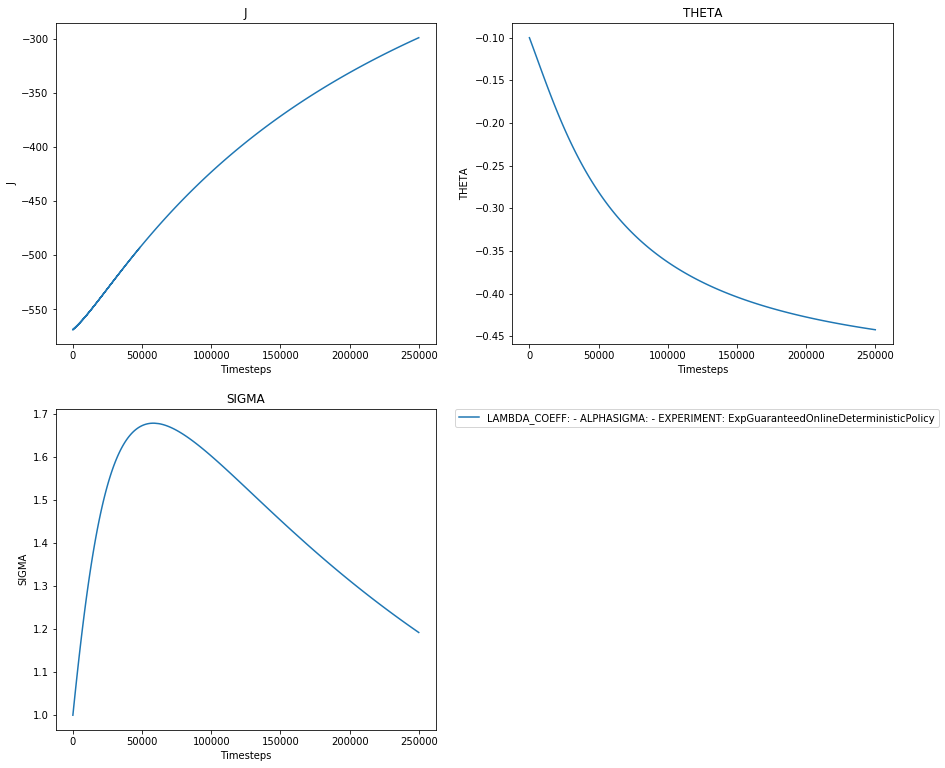

In [154]:
my_plot(lambda_coeff = ['0', '-'], 
        theta='-0.1', 
        alphaSigma = ['0', '-'], 
        experiment=['ExpGuaranteedOnlineDeterministicPolicy', 'Lambda_one_step', 'ExpDiscountedDeterministicPolicy'],
        gamma_coeff='0.8',
        sigma='e(0)',
        value=['J', 'THETA', 'SIGMA'], 
        max_t=250000,
        df = experiments_df)

## Experiments with discounted guaranteed online factor

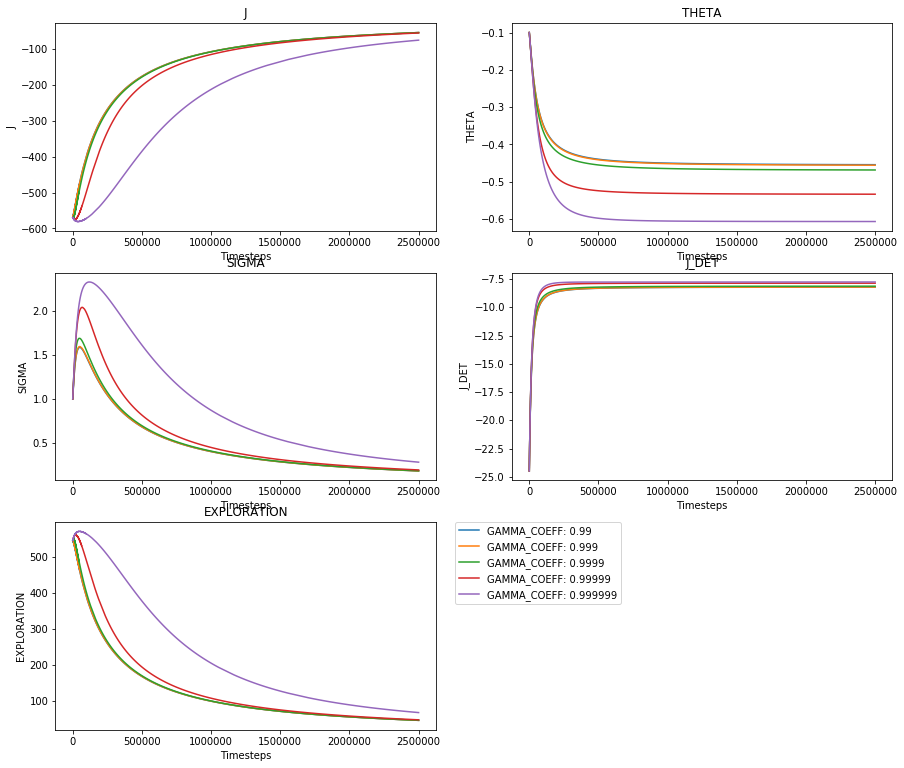

In [79]:
my_plot(lambda_coeff = '-', 
        theta='-0.1', 
        alphaSigma = '-', 
        experiment='ExpDiscountedGuaranteedOnlineDeterministicPolicy',
        gamma_coeff=None,
        sigma='e(0)',
        value=['J', 'THETA', 'SIGMA', 'J_DET', 'EXPLORATION'], 
        max_t=-1,
        df = experiments_df)

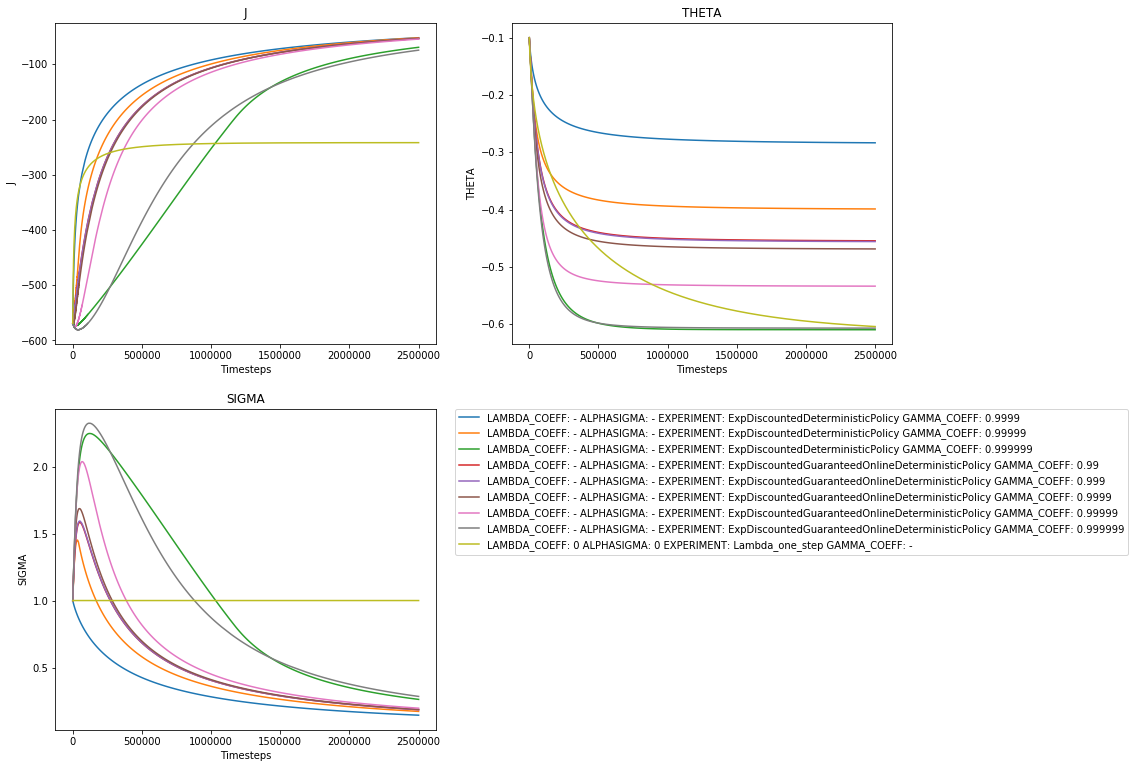

In [76]:
my_plot(lambda_coeff = ['0', '-'], 
        theta='-0.1', 
        alphaSigma = ['0', '-'], 
        experiment=['ExpDiscountedGuaranteedOnlineDeterministicPolicy', 'Lambda_one_step', 'ExpDiscountedDeterministicPolicy'],
        gamma_coeff=None,
        sigma='e(0)',
        value=['J', 'THETA', 'SIGMA'], 
        max_t=-1,
        df = experiments_df)

## Experiments with early stopping conditions

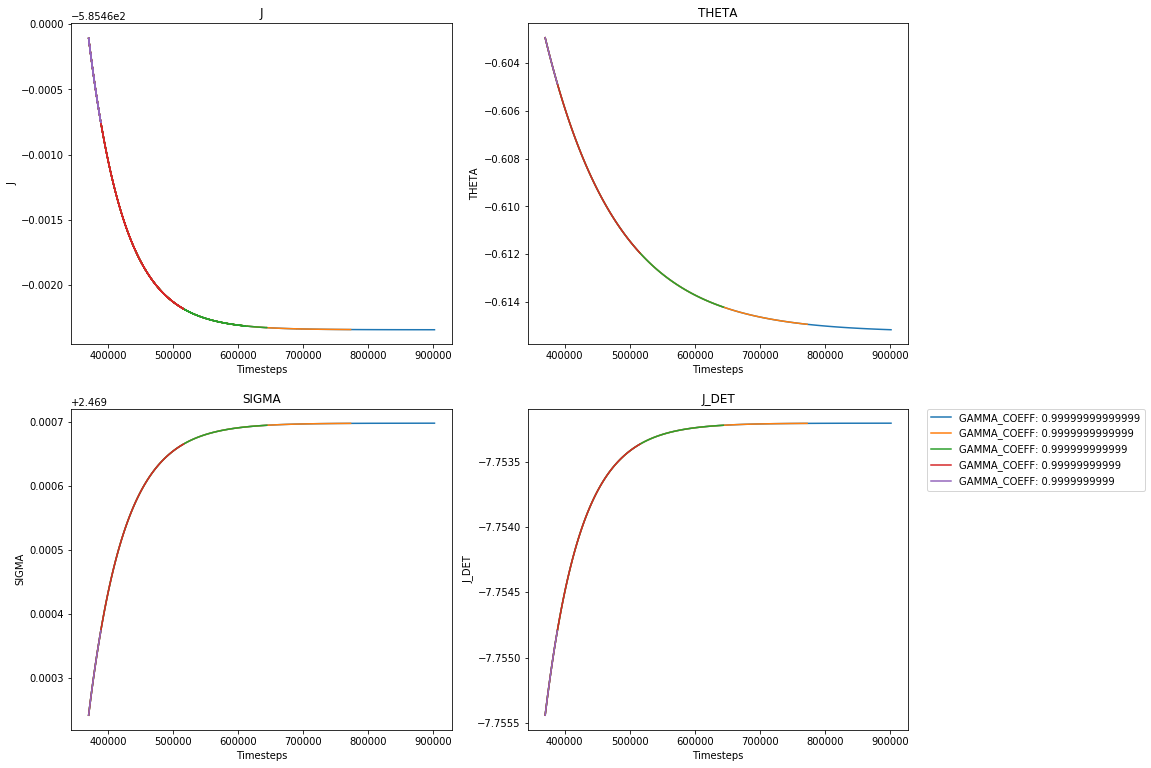

In [96]:
my_plot(lambda_coeff = '-', 
        theta='-0.1', 
        alphaSigma = '-', 
        experiment='ExpEarlyStoppingCondition',
        gamma_coeff=None,
        sigma='e(0)',
        value=['J', 'THETA', 'SIGMA', 'J_DET'], 
        min_t = 370000,
        max_t=-1,
        df = experiments_df)

## Experiments with ExpBudgetReductionStopCondition

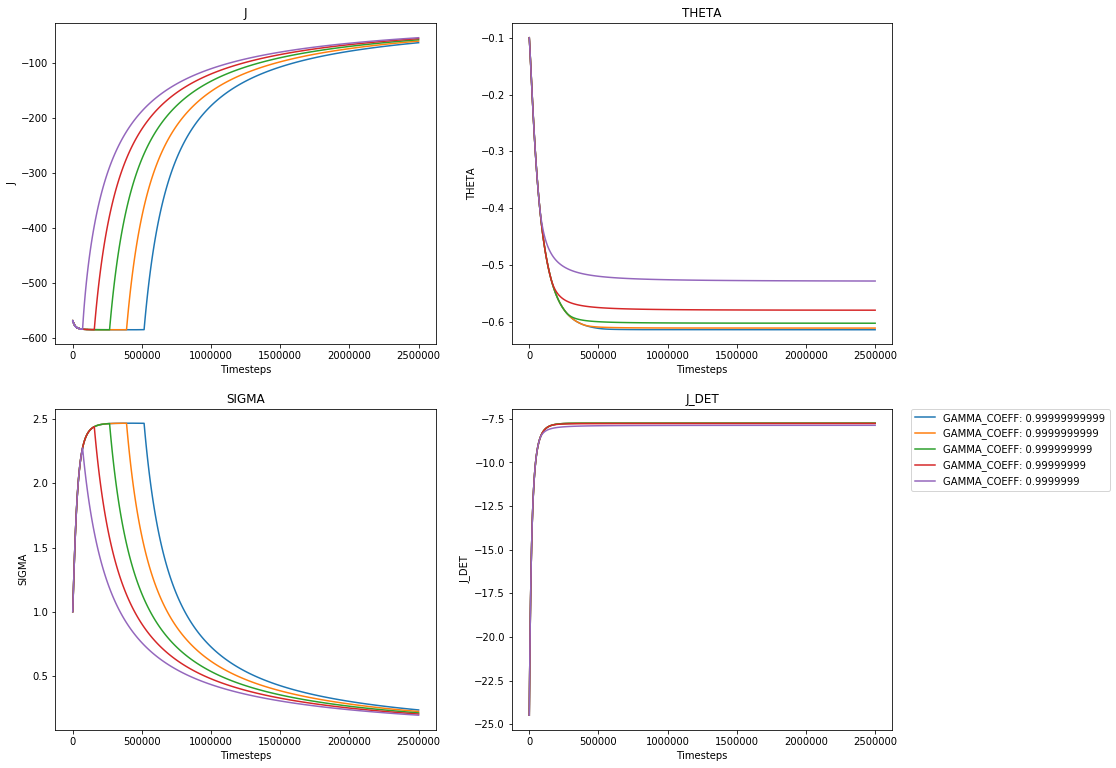

In [102]:
my_plot(lambda_coeff = '-', 
        theta='-0.1', 
        alphaSigma = '-', 
        experiment='ExpBudgetReductionStopCondition',
        gamma_coeff=None,
        sigma='e(0)',
        value=['J', 'THETA', 'SIGMA', 'J_DET'], 
        min_t = 0,
        max_t=-1,
        df = experiments_df)

## Experiments with alpha and beta

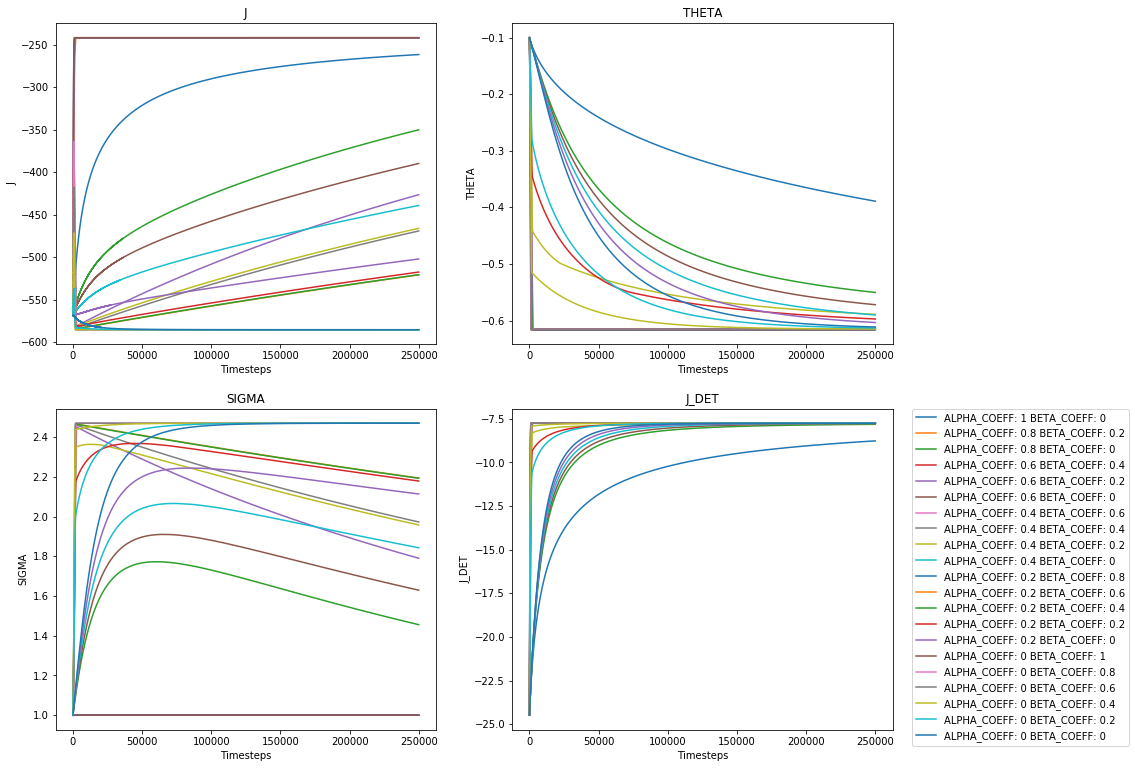

In [158]:
my_plot(lambda_coeff = '-', 
        theta='-0.1', 
        alphaSigma = '-', 
        alpha_coeff = None,
        beta_coeff = None,
        experiment='ExpThetaAndSigmaBudget',
        gamma_coeff='-',
        sigma='e(0)',
        value=['J', 'THETA', 'SIGMA', 'J_DET'], 
        min_t = 0,
        max_t=-1,
        df = experiments_df)

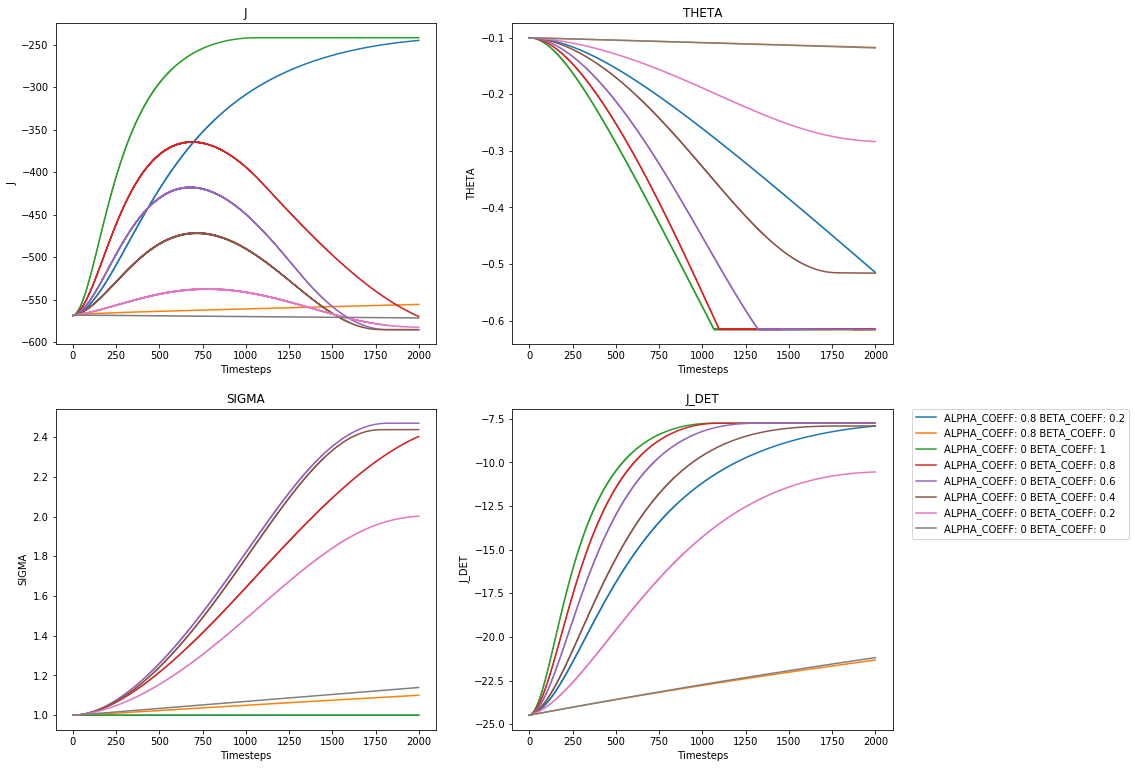

In [166]:
my_plot(lambda_coeff = '-', 
        theta='-0.1', 
        alphaSigma = '-', 
        alpha_coeff = ['0', '0.8'],
        beta_coeff = None,
        experiment='ExpThetaAndSigmaBudget',
        gamma_coeff='-',
        sigma='e(0)',
        value=['J', 'THETA', 'SIGMA', 'J_DET'], 
        min_t = 0,
        max_t=2000,
        df = experiments_df)

## Alternating budgets

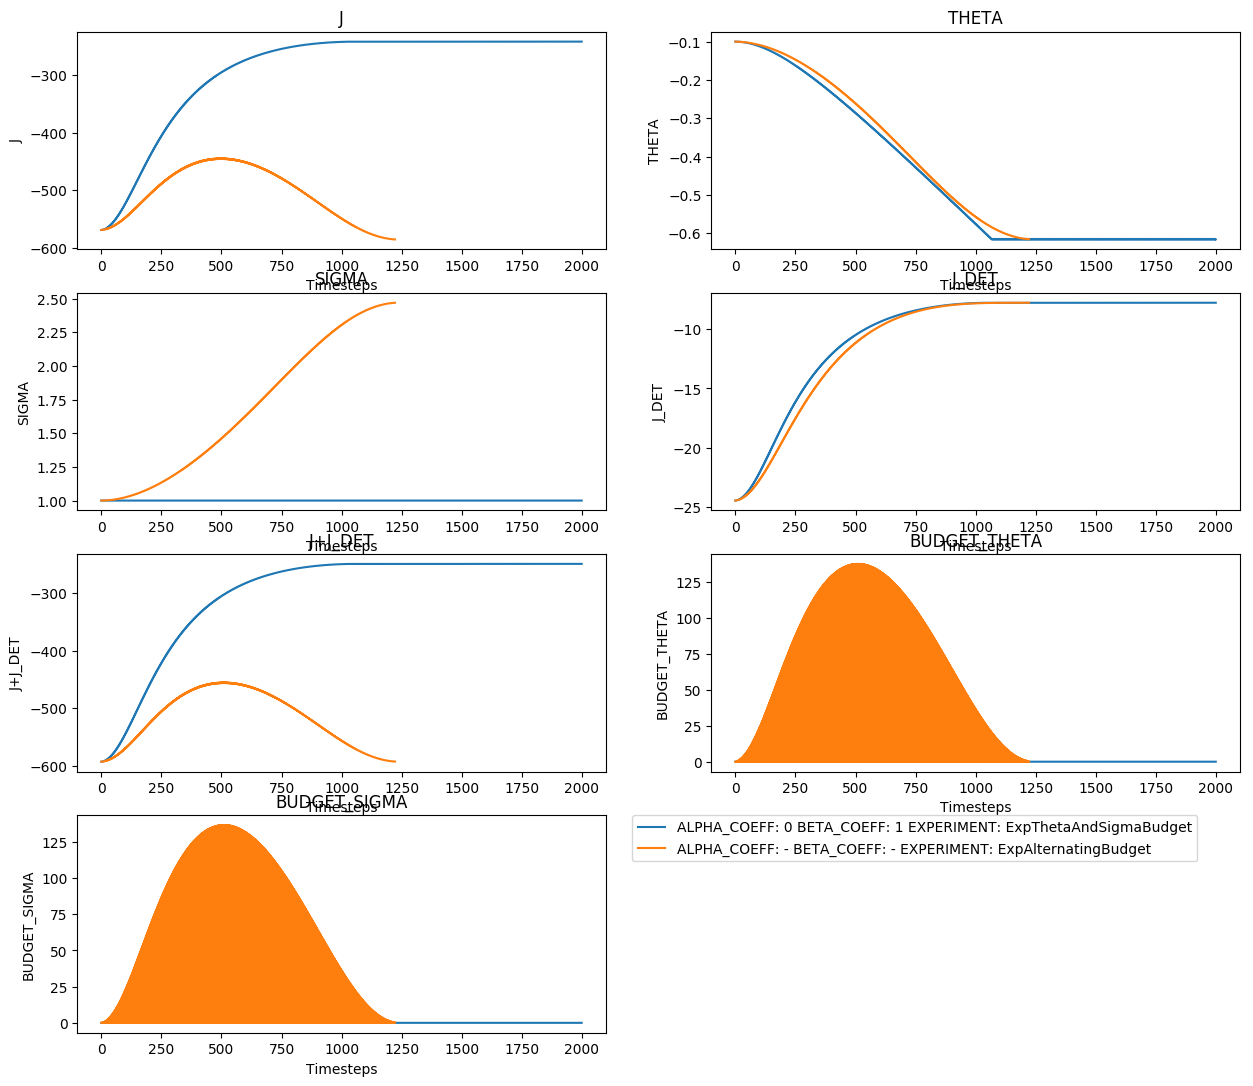

In [28]:
my_plot(lambda_coeff = '-', 
        theta='-0.1', 
        alphaSigma = '-', 
        alpha_coeff = ['-', '0'],
        beta_coeff = ['-', '1'],
        experiment=['ExpAlternatingBudget', 'ExpThetaAndSigmaBudget'],
        gamma_coeff='-',
        sigma='e(0)',
        value=['J', 'THETA', 'SIGMA', 'J_DET', 'J+J_DET', 'BUDGET_THETA', 'BUDGET_SIGMA'], 
        min_t = 0,
        max_t=2000,
        df = experiments_df)

## Exp Single Budget

### Behaviour changing starting sigma value

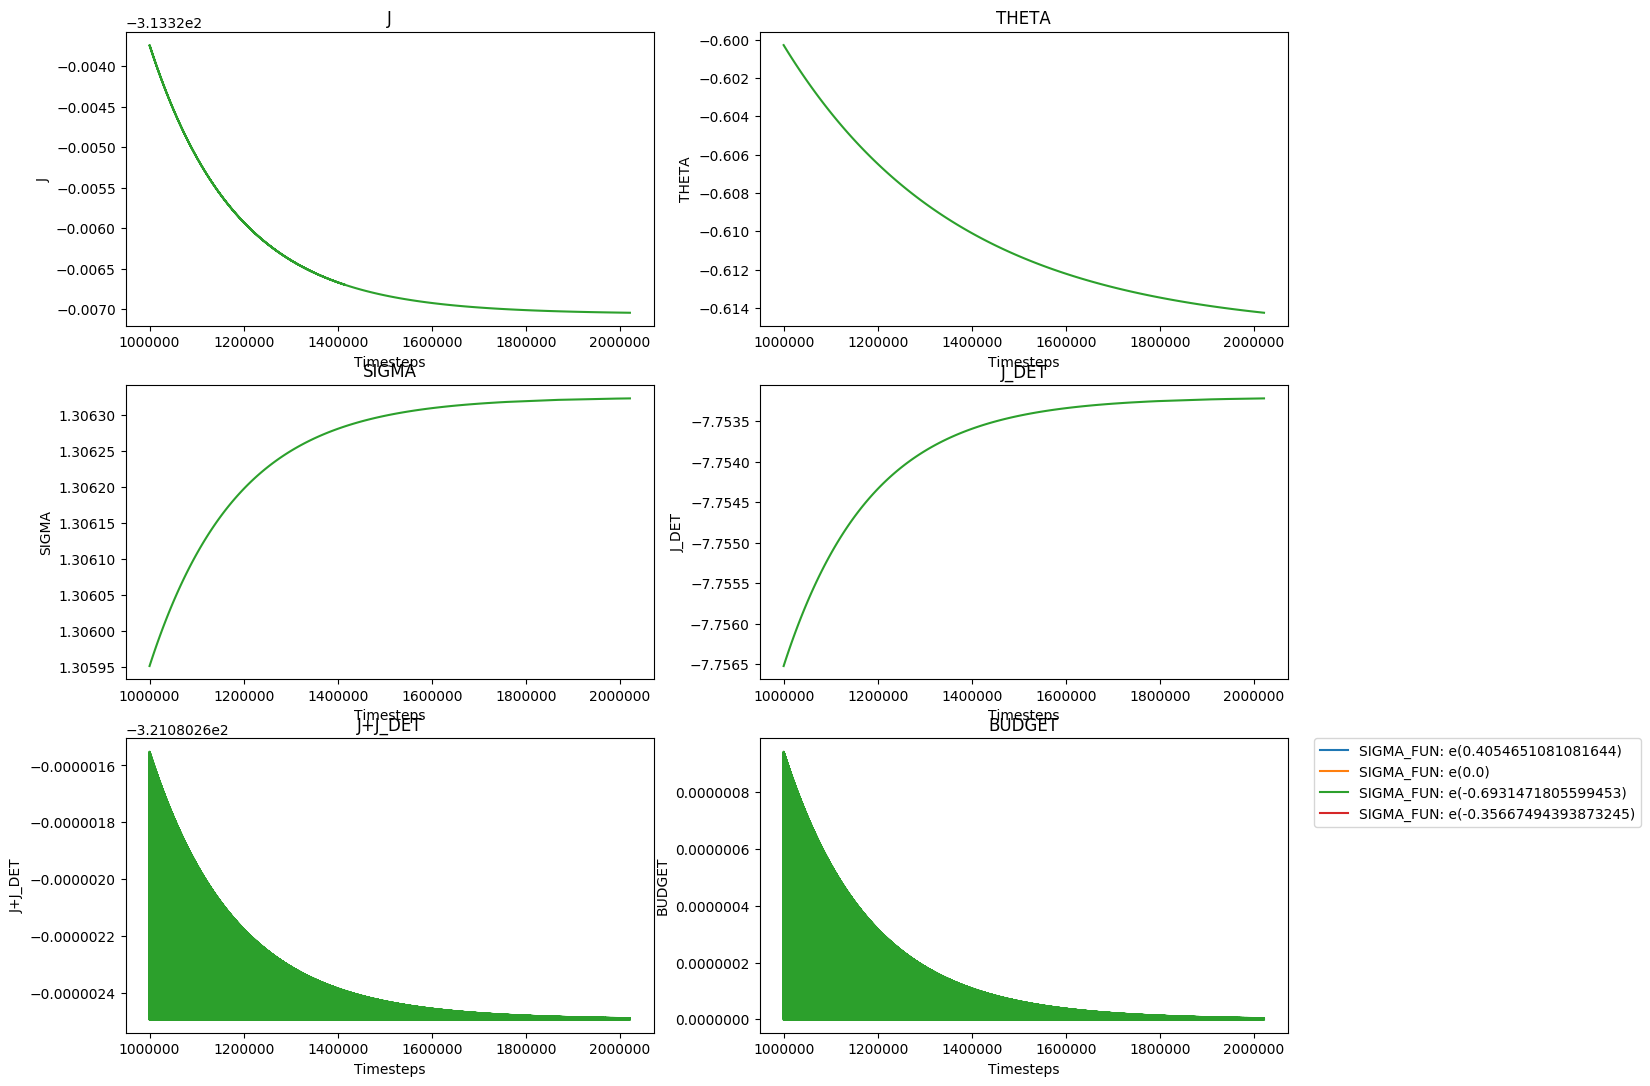

In [76]:
my_plot(lambda_coeff = '-', 
        theta='-0.1', 
        alphaSigma = '-', 
        experiment='ExpSingleBudget',
        gamma_coeff='-',
        sigma_fun=None,
        value=['J', 'THETA', 'SIGMA', 'J_DET', 'J+J_DET', 'BUDGET'], 
        min_t = 200000,
        max_t=-1,
        df = experiments_df)

### Confronto con dare tutto il budget a theta

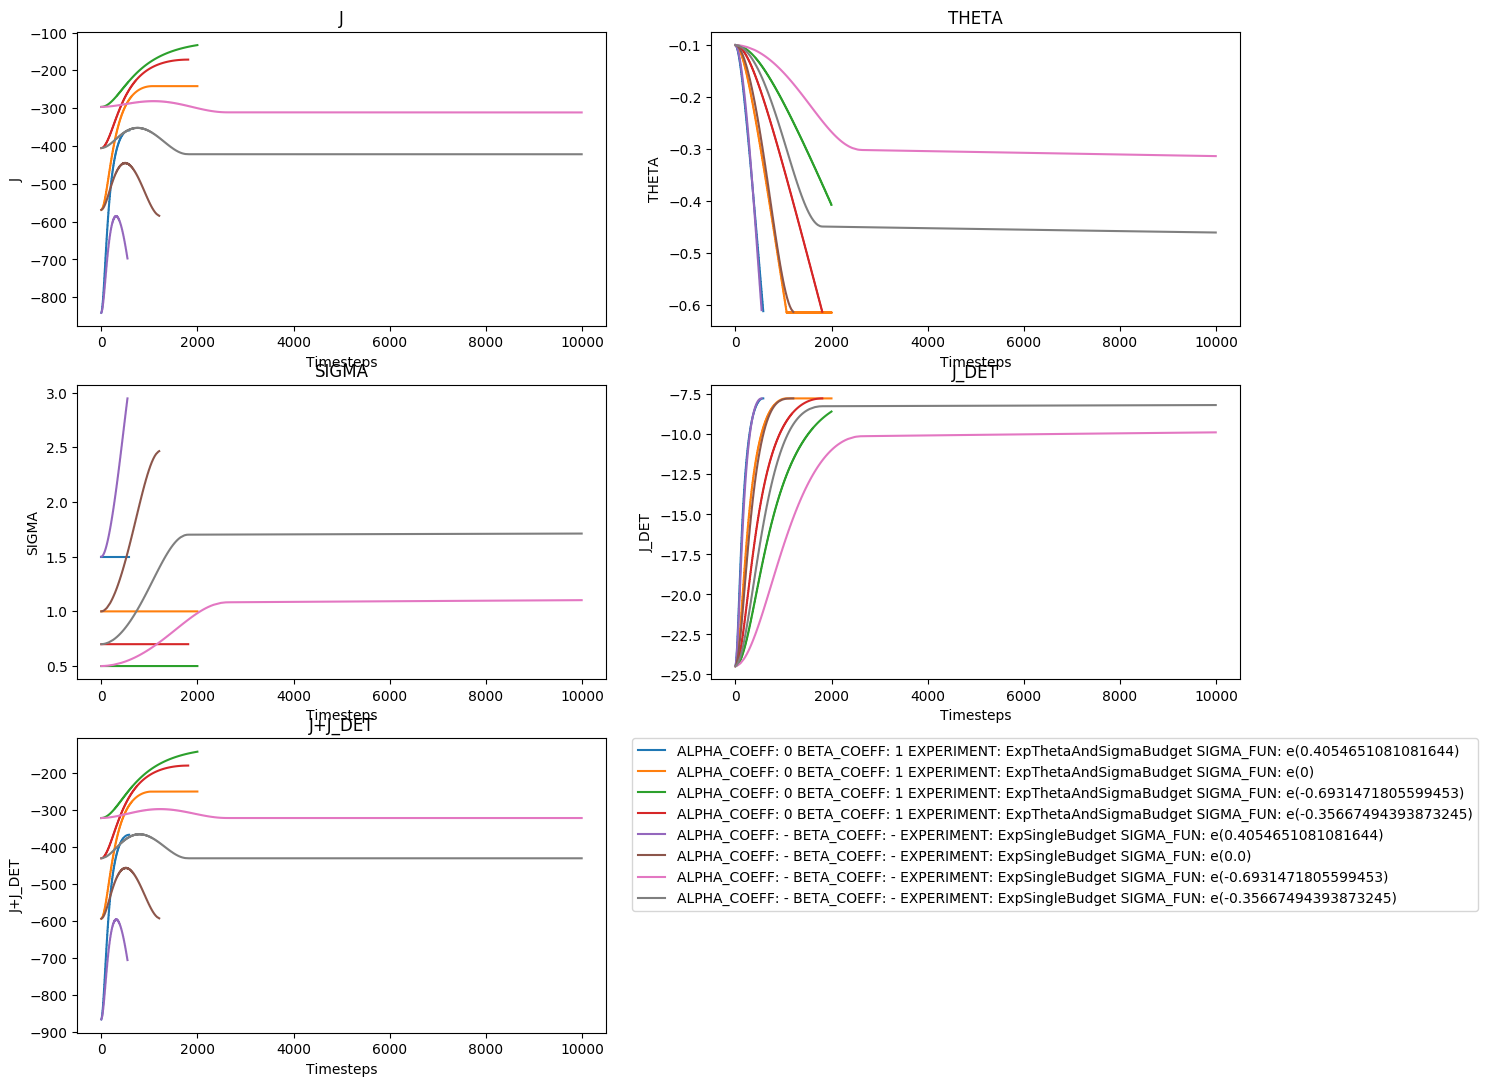

In [47]:
my_plot(lambda_coeff = '-', 
        theta='-0.1', 
        alphaSigma = '-', 
        alpha_coeff=['-', '0'],
        beta_coeff = ['-', '1'],
        experiment=['ExpSingleBudget', 'ExpThetaAndSigmaBudget'],
        gamma_coeff='-',
        sigma_fun=None,
        value=['J', 'THETA', 'SIGMA', 'J_DET', 'J+J_DET'], 
        min_t = 0,
        max_t=2000,
        df = experiments_df)

## Exp discounted single budget

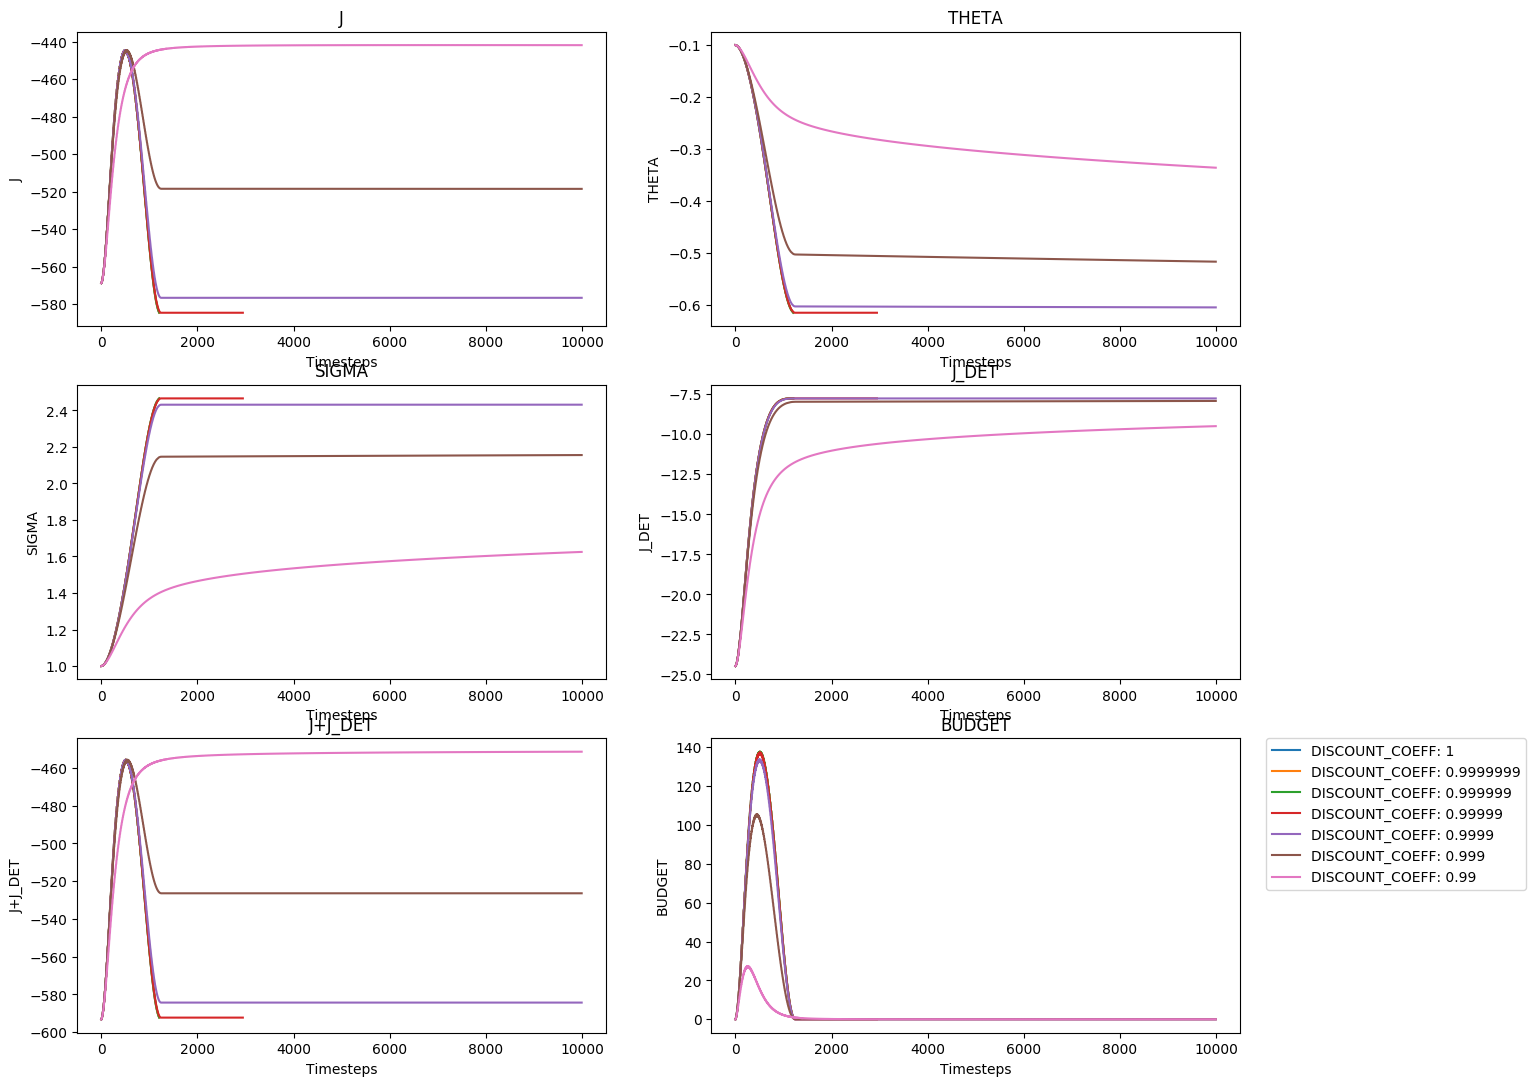

In [60]:
my_plot(lambda_coeff = '-', 
        theta='-0.1', 
        alphaSigma = '-', 
        experiment='ExpDiscountedSingleBudget',
        gamma_coeff='-',
        sigma_fun='e(0)',
        discount_coeff=None,
        value=['J', 'THETA', 'SIGMA', 'J_DET', 'J+J_DET', 'BUDGET'], 
        min_t = 0,
        max_t=2000,
        df = experiments_df)

## Exp single budget with random baselines

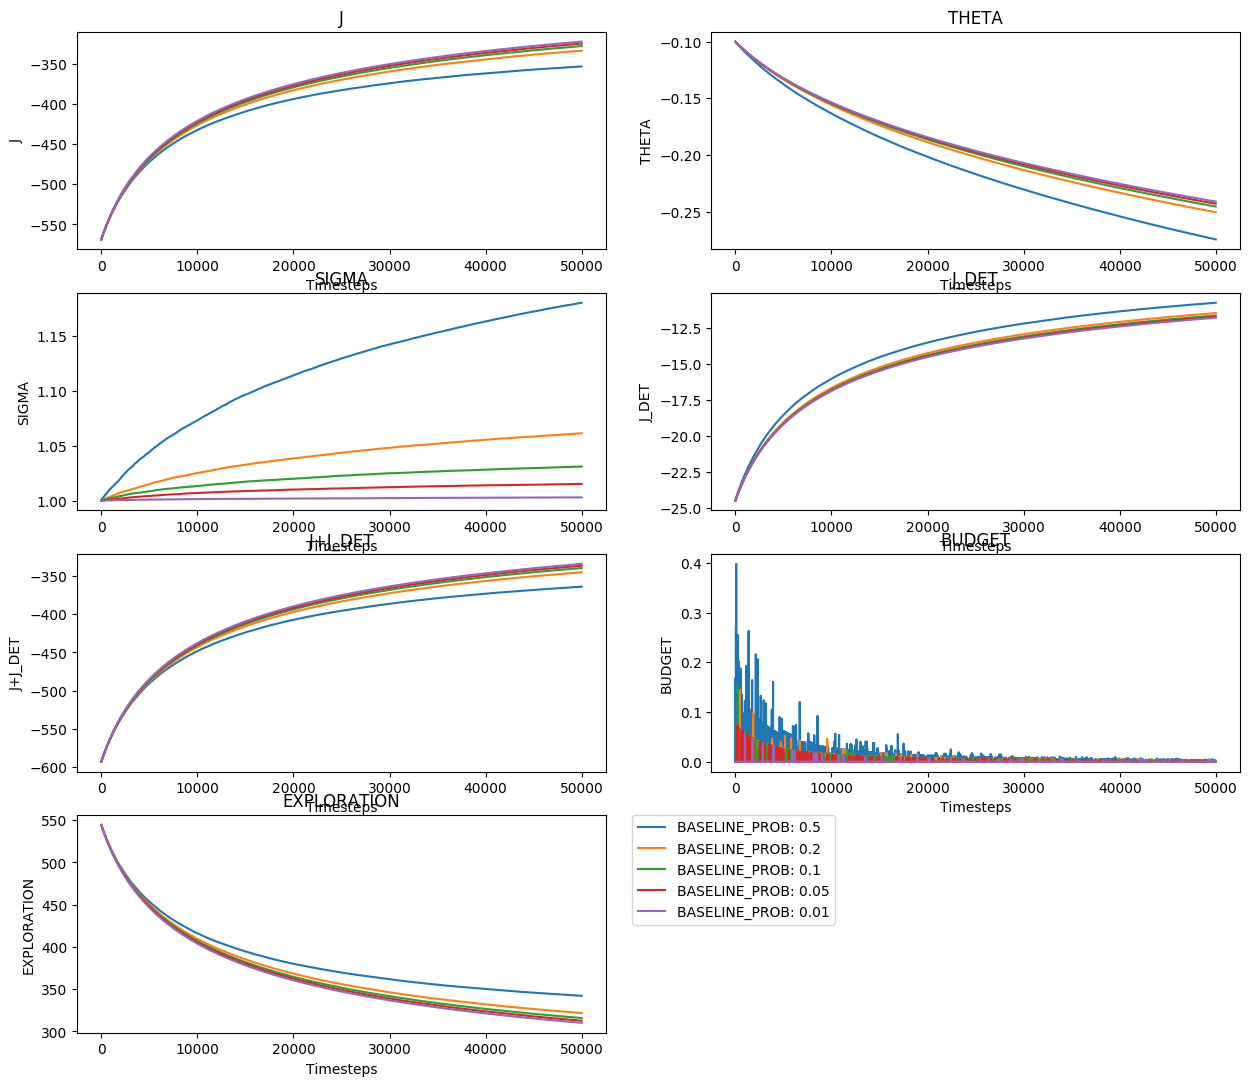

In [64]:
my_plot(lambda_coeff = '-', 
        theta='-0.1', 
        alphaSigma = '-', 
        experiment='ExpSingleBudgetRandomBaselines',
        gamma_coeff='-',
        sigma_fun='e(0)',
        baseline_prob=None,
        value=['J', 'THETA', 'SIGMA', 'J_DET', 'J+J_DET', 'BUDGET'], 
        min_t = 0,
        max_t=10000,
        df = experiments_df)

# Non exact environment

In [58]:
#BASE_FOLDER = 'experiments_non_exact'
BASE_FOLDER = 'experiments_safe/'

exp_df = load_dataframe(BASE_FOLDER)

In [59]:
exp_df

DELTA                   EXPERIMENT                          FILENAME GAMMA  \
0   0.1  SafeExperimentSemiDetPolicy  experiments_safe/odjKP9FEYWFtxMI  0.99   
1   0.1  SafeExperimentSemiDetPolicy  experiments_safe/SrExaCWJiYv8N73  0.99   
2   0.1            SafeSemiDetPolicy  experiments_safe/cqVQbJs6S8SPnKj  0.99   
3   0.1            SafeSemiDetPolicy  experiments_safe/lGHg0oNGHBqJYkR  0.99   
4   0.1  SafeExperimentSemiDetPolicy  experiments_safe/1D8MQA7Bfk6t8cY  0.99   
5   0.1  SafeExperimentSemiDetPolicy  experiments_safe/speedsaCH21Tmme  0.99   
6   0.1                      NonSafe  experiments_safe/5QwkUXV9G2WHMBg  0.99   
7   0.1  SafeExperimentSemiDetPolicy  experiments_safe/yp9V9qv4p9szDjS  0.99   

  MAX_ITER                   NAME   N_MAX N_MIN     N_TOT PARALLEL  \
0     5000  SafeDeterministic_0.1  500000   450  30000000     True   
1     5000        SafeSemiDet_0.3  500000   450  30000000     True   
2     5000      SafeSemiDetPolicy  500000   450  30000000     True   
3     5000      SafeSemiDetPolicy  500000   450  30000000     True   
4     5000  SafeDeterministic_0.5  500000   450  30000000     True   
5     5000        SafeSemiDet_0.5  500000   450  30000000     True   
6     5000                NonSafe  500000   450  30000000     True   
7     5000        SafeSemiDet_0.1  500000   450  30000000     True   

  USE_LOCAL_STATS VERBOSE  
0            True    True  
1            True    True  
2            True    True  
3            True    True  
4            True    True  
5            True    True  
6            True    True  
7            True    True

Initial J+J_DET is:  -91.71327111431846
Average J+J_DET is:  -72.73450220498044
Budget is negative for:  3180 / 15000  times


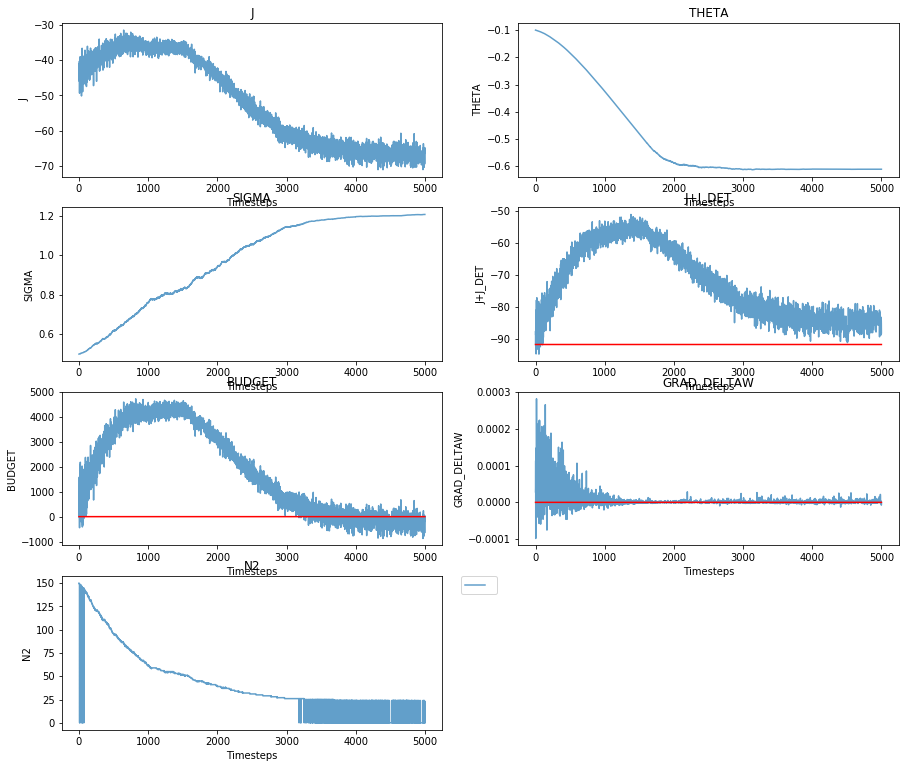

In [60]:
my_plot(value=['J', 'THETA', 'SIGMA', 'J+J_DET', 'BUDGET', 'GRAD_DELTAW', 'N2'], 
        min_t = 0,
        max_t=-1,
        name = 'SafeDeterministic_0.5',
        experiment='SafeExperimentSemiDetPolicy',
        step=3,
        alpha=0.7,
        df = exp_df)

Initial J+J_DET is:  -174.5088567709442
Average J+J_DET is:  -111.36690346808692
Initial J+J_DET is:  -167.6888964726513
Average J+J_DET is:  -95.76918672563592
Initial J+J_DET is:  -173.11180331410594
Average J+J_DET is:  -168.30692520752044
Budget is negative for:  1779 / 15000  times
Budget is negative for:  6187 / 15000  times
Budget is negative for:  7183 / 15000  times


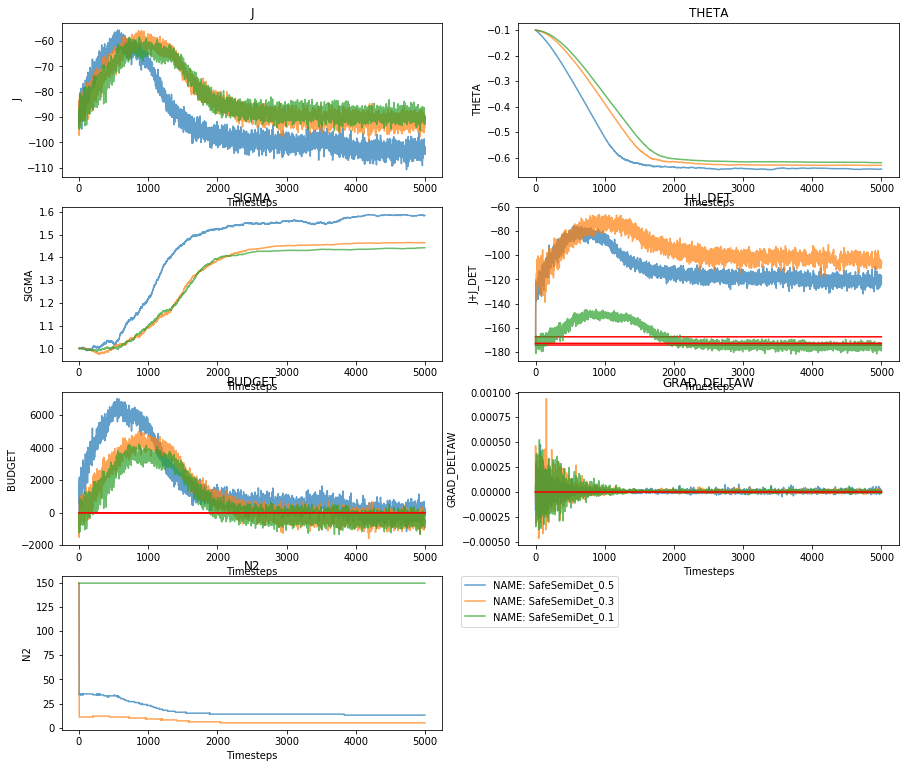

In [53]:
my_plot(value=['J', 'THETA', 'SIGMA', 'J+J_DET', 'BUDGET', 'GRAD_DELTAW', 'N2'], 
        min_t = 0,
        max_t=-1,
        name = None,
        experiment='SafeExperimentSemiDetPolicy',
        step=3,
        alpha=0.7,
        df = exp_df)

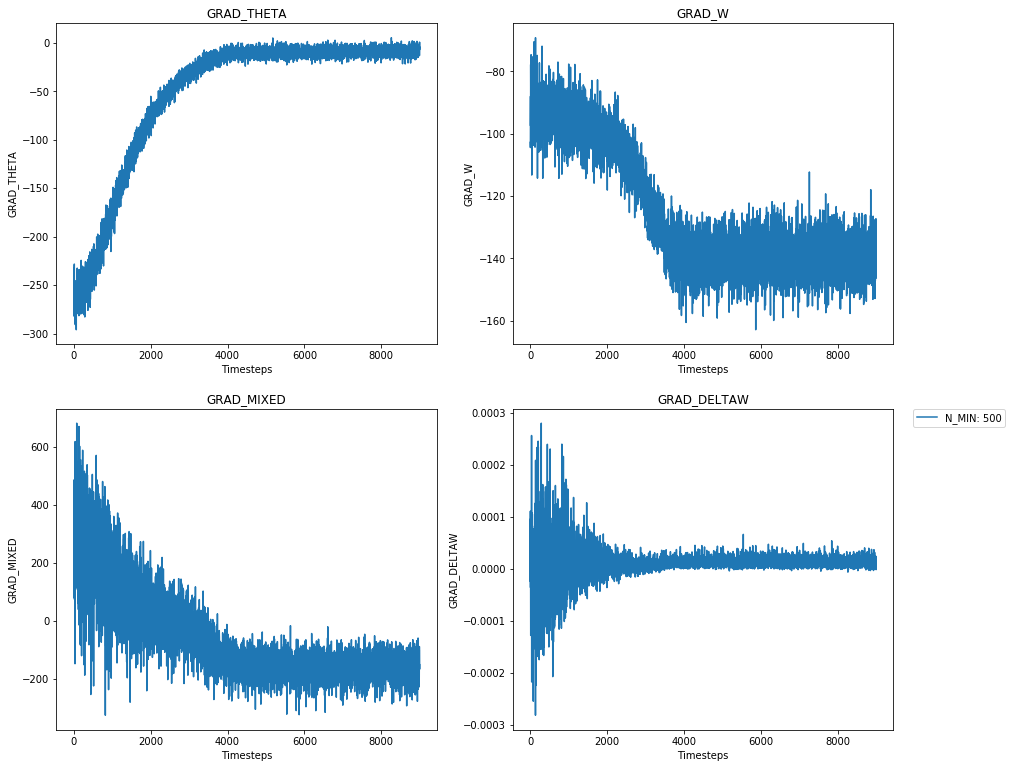

In [20]:
my_plot(value=['GRAD_THETA', 'GRAD_W', 'GRAD_MIXED', 'GRAD_DELTAW'], 
        min_t = 0,
        max_t=-1,
        n_min=None,
        name = 'Exp_parallel500',
        max_iter = '3000',
        df = exp_df)

In [114]:
BASE_FOLDER = 'experiments_safe'

exp_df2 = load_dataframe(BASE_FOLDER)

In [117]:
exp_df = pd.concat([exp_df, exp_df2])

In [119]:
exp_df

DELTA                   EXPERIMENT  \
0   0.1  SafeExperimentSemiDetPolicy   
0   0.1  SafeExperimentSemiDetPolicy   
1   0.1  SafeExperimentSemiDetPolicy   
2   0.1            SafeSemiDetPolicy   
3   0.1            SafeSemiDetPolicy   
4   0.1  SafeExperimentSemiDetPolicy   
5   0.1  SafeExperimentSemiDetPolicy   
6   0.1                      NonSafe   
7   0.1  SafeExperimentSemiDetPolicy   

                                        FILENAME GAMMA MAX_ITER  \
0  experiments_non_deterministic/tfcQN1IsABfGQBt  0.99     2000   
0               experiments_safe/odjKP9FEYWFtxMI  0.99     5000   
1               experiments_safe/SrExaCWJiYv8N73  0.99     5000   
2               experiments_safe/cqVQbJs6S8SPnKj  0.99     5000   
3               experiments_safe/lGHg0oNGHBqJYkR  0.99     5000   
4               experiments_safe/1D8MQA7Bfk6t8cY  0.99     5000   
5               experiments_safe/speedsaCH21Tmme  0.99     5000   
6               experiments_safe/5QwkUXV9G2WHMBg  0.99     5000   
7               experiments_safe/yp9V9qv4p9szDjS  0.99     5000   

                    NAME   N_MAX N_MIN     N_TOT PARALLEL USE_LOCAL_STATS  \
0          ProvaBaseline  500000   450  30000000     True            True   
0  SafeDeterministic_0.1  500000   450  30000000     True            True   
1        SafeSemiDet_0.3  500000   450  30000000     True            True   
2      SafeSemiDetPolicy  500000   450  30000000     True            True   
3      SafeSemiDetPolicy  500000   450  30000000     True            True   
4  SafeDeterministic_0.5  500000   450  30000000     True            True   
5        SafeSemiDet_0.5  500000   450  30000000     True            True   
6                NonSafe  500000   450  30000000     True            True   
7        SafeSemiDet_0.1  500000   450  30000000     True            True   

  VERBOSE  
0    True  
0    True  
1    True  
2    True  
3    True  
4    True  
5    True  
6    True  
7    True

In [71]:
BASE_FOLDER = 'experiments_non_deterministic'

exp_df = load_dataframe(BASE_FOLDER)

In [72]:
exp_df

DELTA                   EXPERIMENT  \
0   0.1  SafeExperimentSemiDetPolicy   

                                        FILENAME GAMMA MAX_ITER  \
0  experiments_non_deterministic/tfcQN1IsABfGQBt  0.99     2000   

            NAME   N_MAX N_MIN     N_TOT PARALLEL USE_LOCAL_STATS VERBOSE  
0  ProvaBaseline  500000   450  30000000     True            True    True

In [75]:
data = load_from_dataframe(exp_df)

In [77]:
data = data[0]

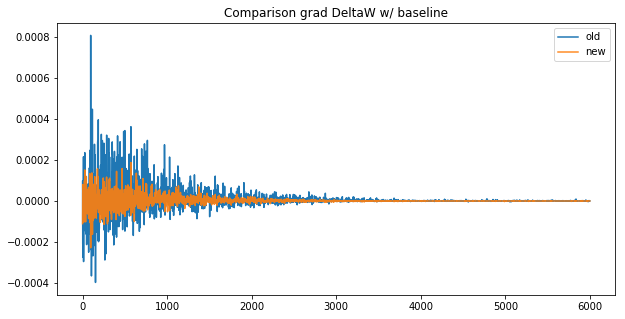

In [101]:
plt.figure(figsize=(10, 5))
plt.title("Comparison grad DeltaW w/ baseline")
plt.plot(data['T'], data['GRAD_DELTAW_OLD'], alpha=1)
plt.plot(data['T'], data['GRAD_DELTAW'], alpha=0.9)

plt.legend(['old', 'new'])

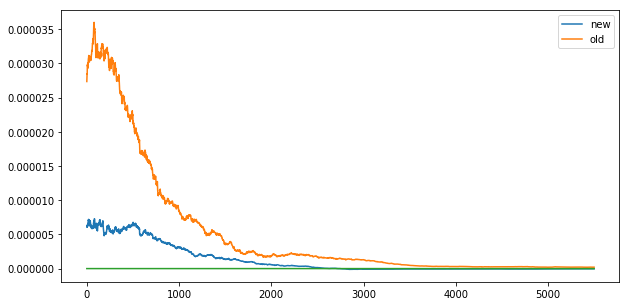

In [109]:
N = 500
plt.figure(figsize=(10, 5))
plt.plot(data['T'][:-N+1], np.convolve(data['GRAD_DELTAW'], np.ones((N,))/N, mode='valid'))
plt.plot(data['T'][:-N+1], np.convolve(data['GRAD_DELTAW_OLD'], np.ones((N,))/N, mode='valid'))
plt.legend(['new', 'old'])
plt.plot(data['T'][:-N+1], [0]*data['T'][:-N+1])

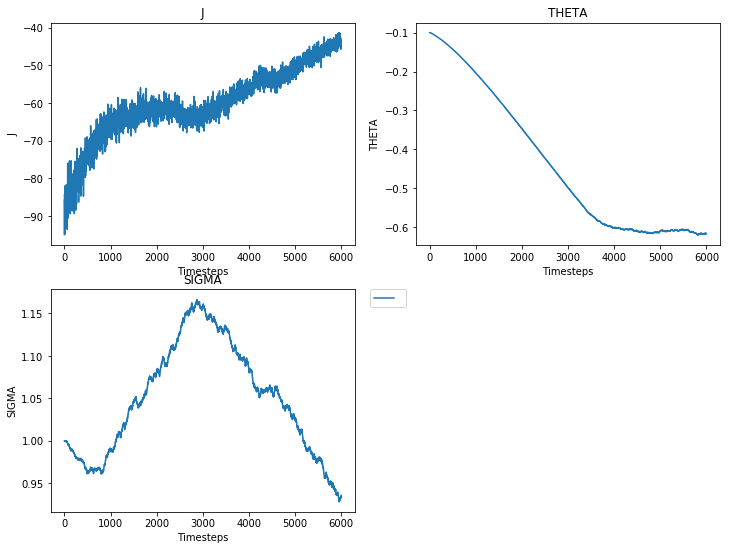

In [108]:
plt.figure(figsize=(12,9))
my_plot(value=['J', 'THETA', 'SIGMA'], 
        min_t = 0,
        max_t=-1,
        alpha=1,
        df = exp_df)

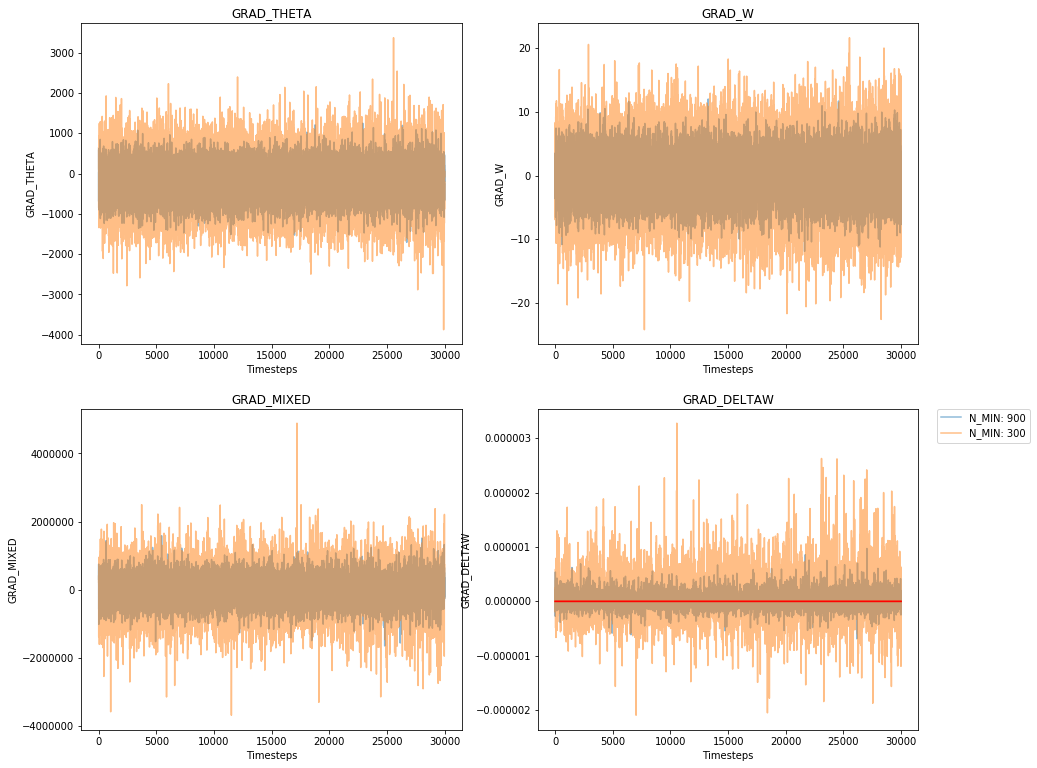

In [68]:
my_plot(value=['GRAD_THETA', 'GRAD_W', 'GRAD_MIXED', 'GRAD_DELTAW'], 
        min_t = 0,
        max_t=-1,
        n_min=['300', '900'],
        name = 'Safe',
        alpha=0.5,
        df = exp_df)

# Parallel vs serial trajectories

In [57]:
BASE_FOLDER = 'experiments_parallel_vs_serial/'

new_df = load_dataframe(BASE_FOLDER)

In [135]:
new_df = new_df.loc[(2, 3),:]

Initial J+J_DET is:  -111.64261989266225
Average J+J_DET is:  -77.6732279676491
Initial J+J_DET is:  -114.53020507924826
Average J+J_DET is:  -95.67182584361761
Budget is negative for:  93 / 4500  times
Budget is negative for:  441 / 4500  times


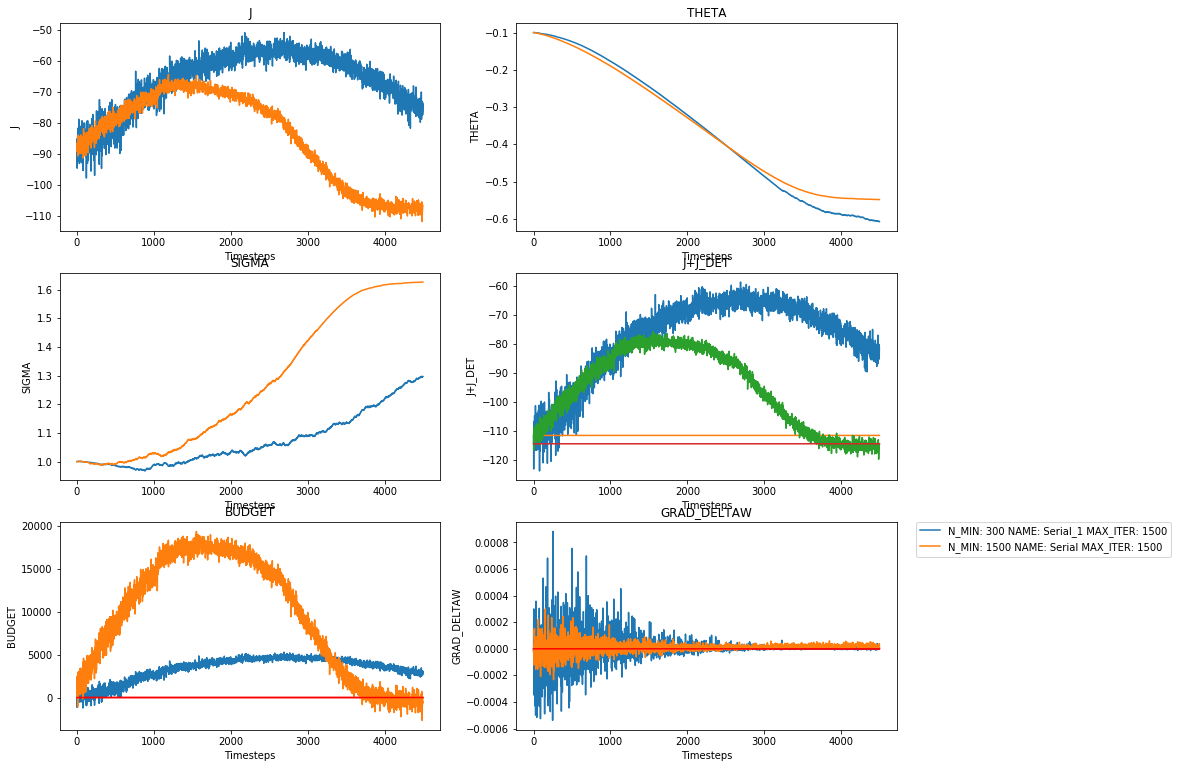

In [143]:
my_plot(value=['J', 'THETA', 'SIGMA', 'J+J_DET', 'BUDGET', 'GRAD_DELTAW'], 
        min_t = 0,
        max_t=-1,
        n_min=None,
        name = None,
        max_iter = None,
        df = new_df)

In [88]:
BASE_FOLDER = 'Experiments parallel/'

new_df = load_dataframe(BASE_FOLDER)

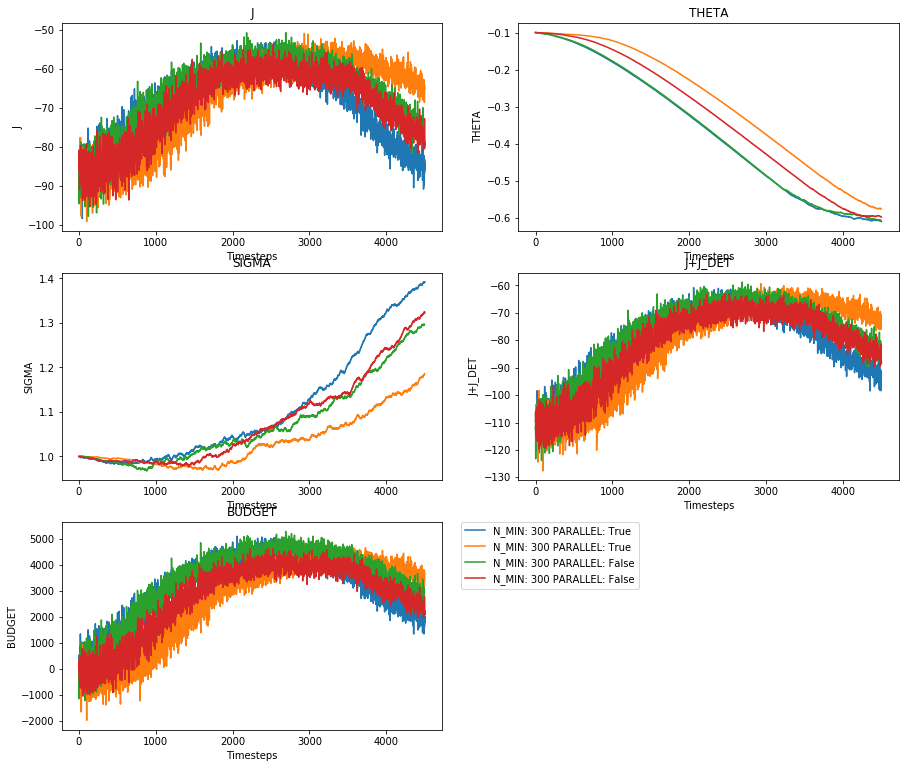

In [90]:
my_plot(value=['J', 'THETA', 'SIGMA', 'J+J_DET', 'BUDGET'], 
        min_t = 0,
        max_t=-1,
        n_min=None,
        name = 'Serial_1',
        parallel=None,
        df = new_df)

# Experiments

In [71]:
experiments_df_2 = load_dataframe('exploration_cost_exp')

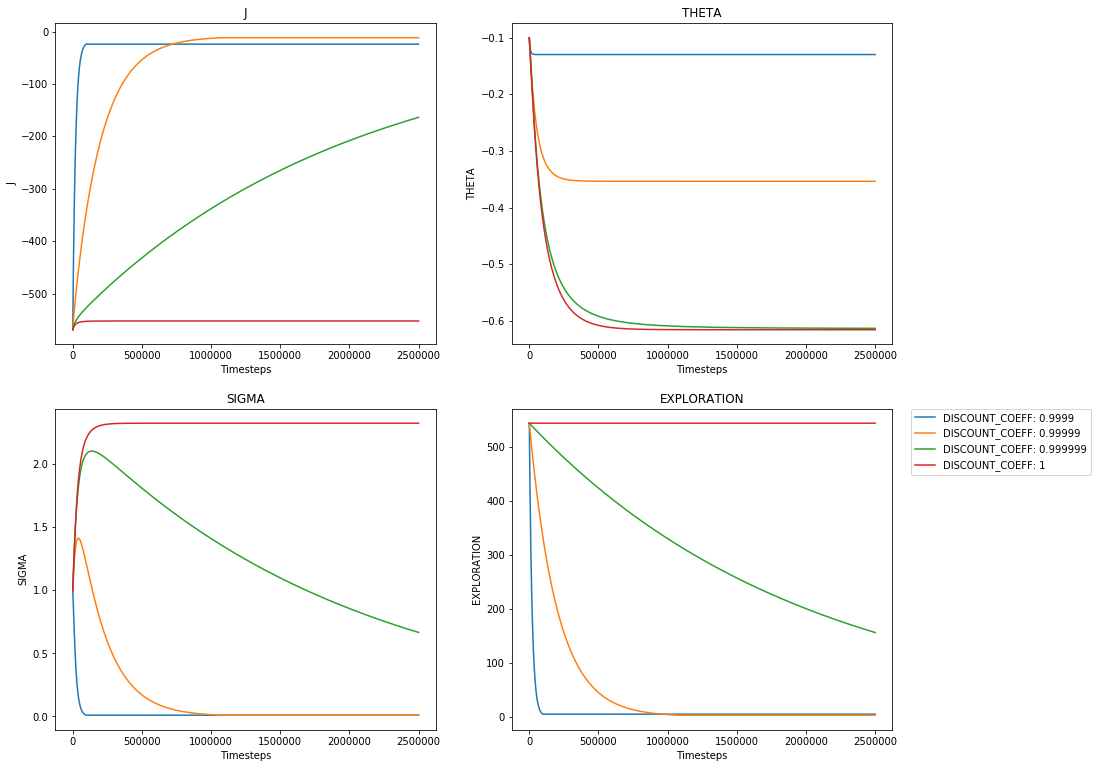

In [42]:
my_plot(lambda_coeff = '-', 
        theta='-0.1', 
        alphaSigma = '-', 
        experiment='ExpExplorationCost_two_steps',
        gamma_coeff='-',
        discount_coeff=None,
        init_exp = '-1',
        sigma='e(0)',
        value=['J', 'THETA', 'SIGMA', 'EXPLORATION'], 
        max_t=-1,
        df = experiments_df_2)

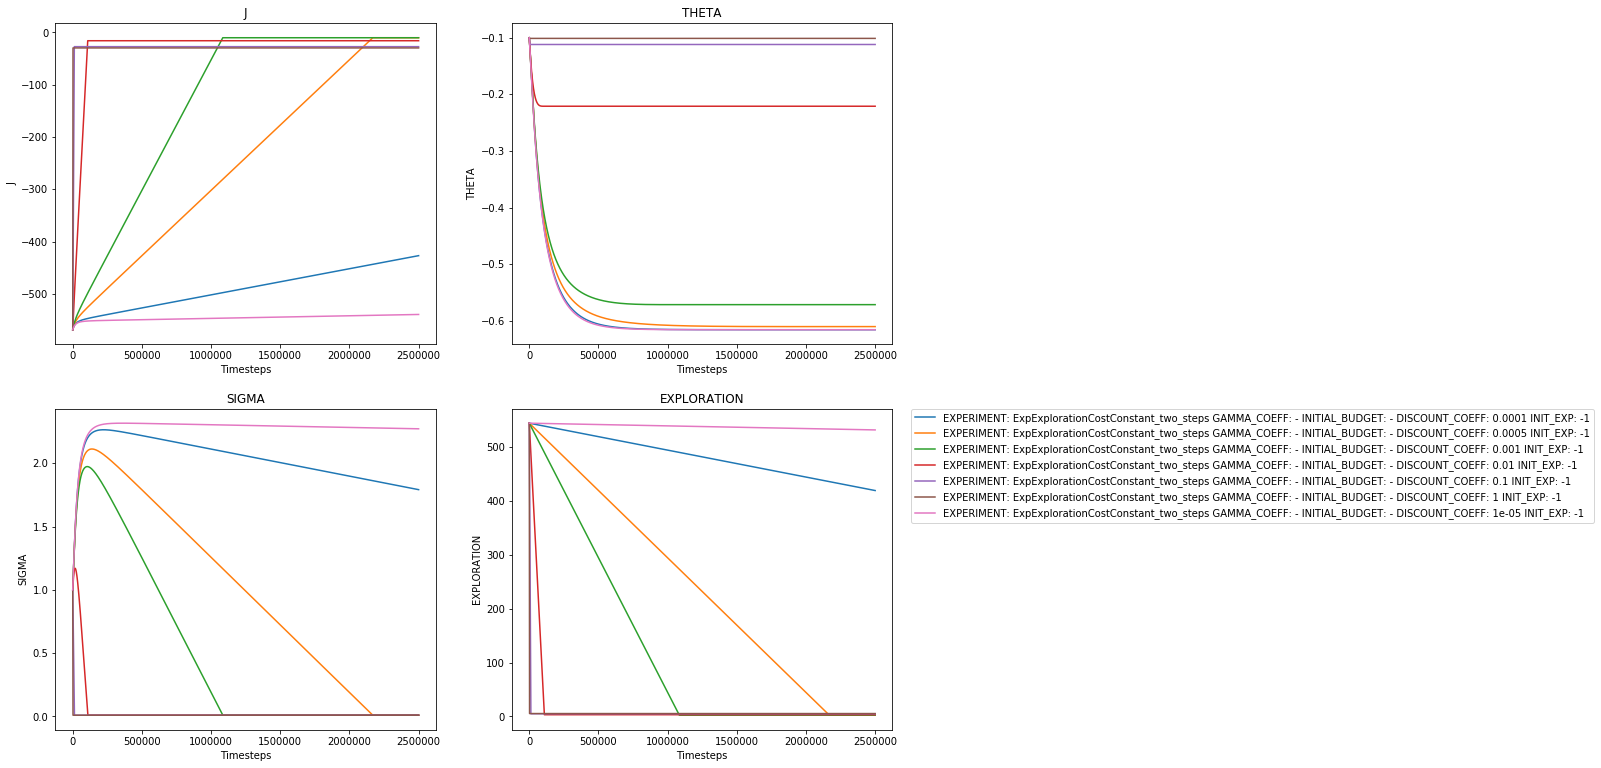

In [72]:
my_plot(lambda_coeff = '-', 
        theta='-0.1', 
        alphaSigma = '-', 
        experiment=['ExpExplorationCostConstant_two_steps'],
        gamma_coeff=None,
        initial_budget=None,
        discount_coeff=None,
        init_exp = None,
        sigma='e(0)',
        value=['J', 'THETA', 'SIGMA', 'EXPLORATION'], 
        max_t=-1,
        df = experiments_df_2)

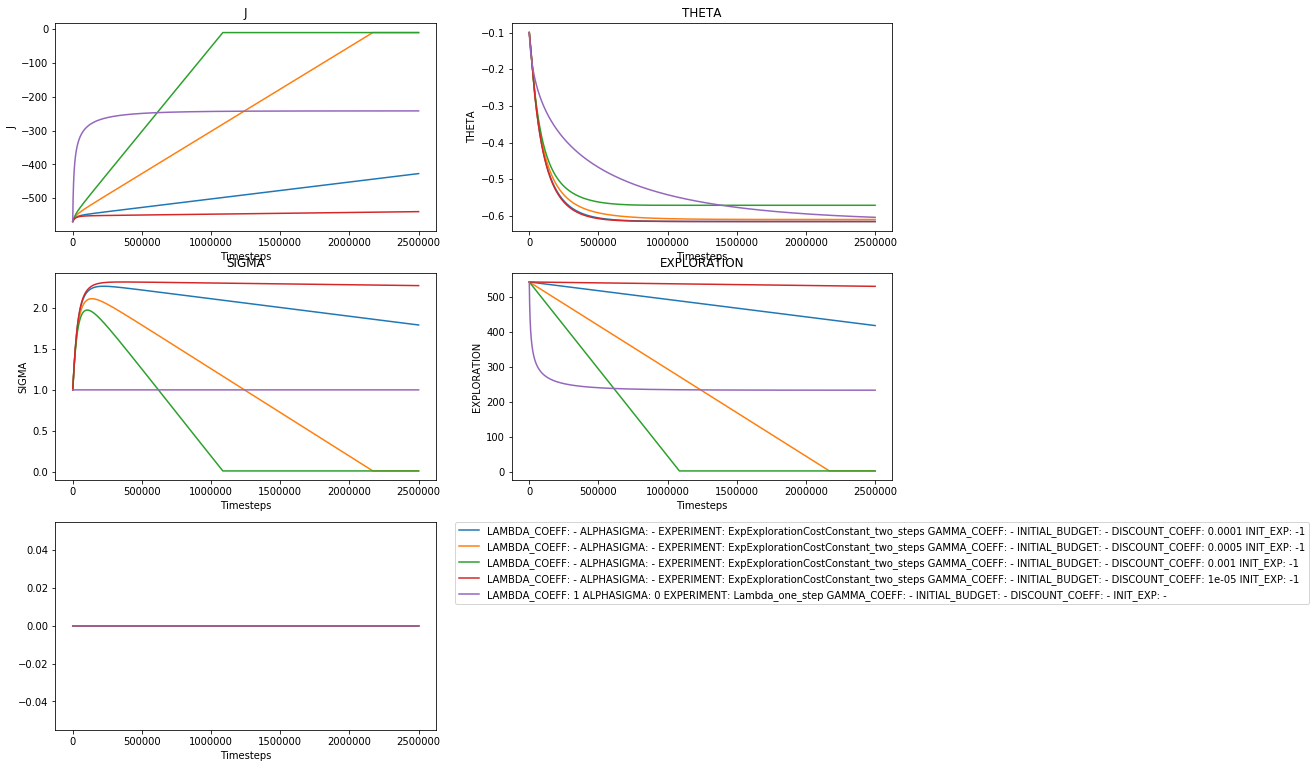

In [80]:
my_plot(lambda_coeff = ['-', '1'], 
        theta='-0.1', 
        alphaSigma = ['-', '0'] ,
        experiment=['ExpExplorationCostConstant_two_steps', 'Lambda_one_step'],
        gamma_coeff=None,
        initial_budget=None,
        discount_coeff=['0.0001', '0.0005', '0.001', '1e-05', '-'],
        init_exp = None,
        sigma='e(0)',
        value=['J', 'THETA', 'SIGMA', 'EXPLORATION', ''], 
        max_t=-1,
        df = pd.concat([experiments_df_2, experiments_df]).fillna('-'))

# Comparison between budget and exploration

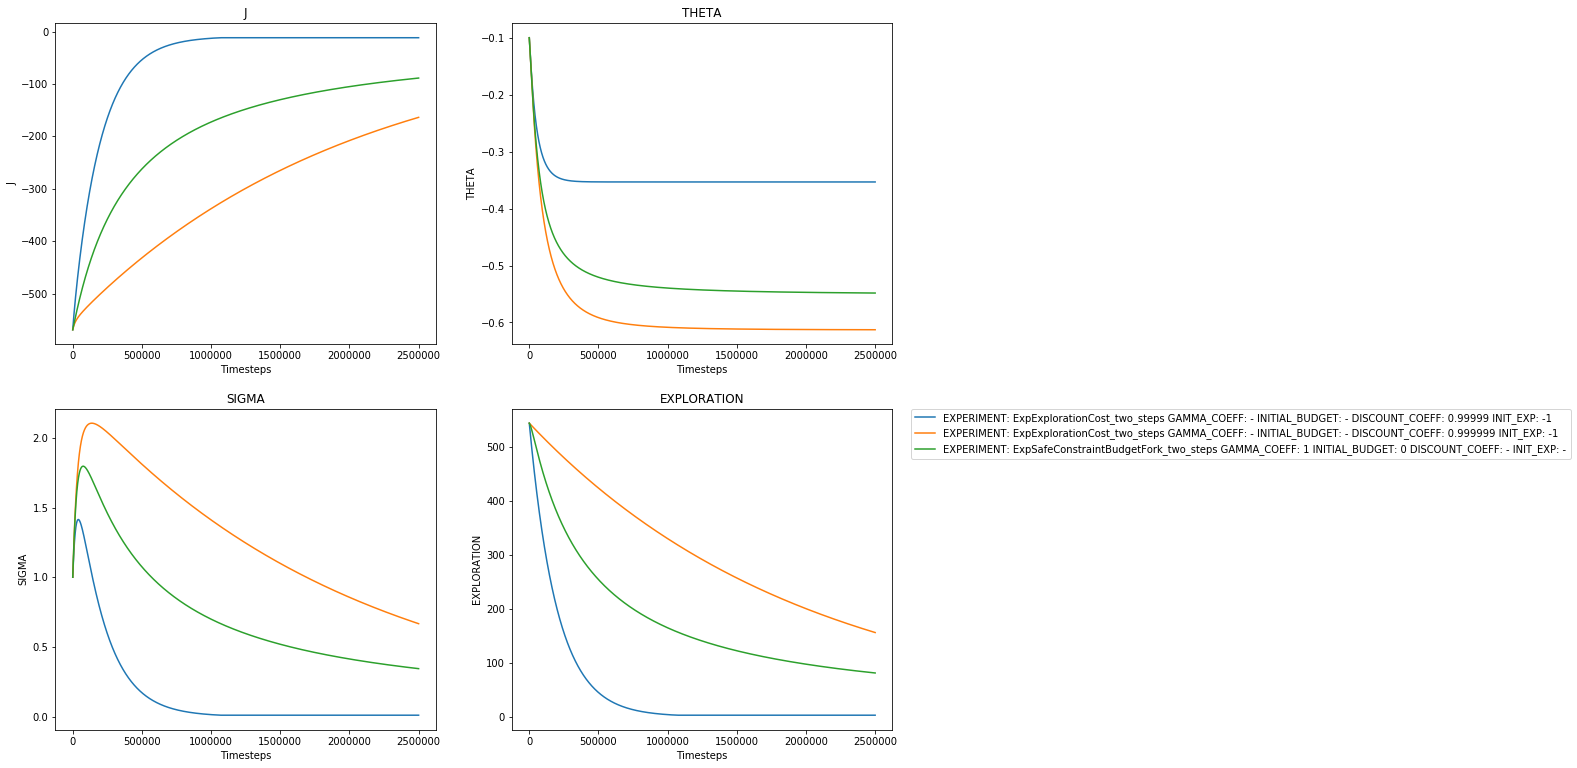

In [59]:
my_plot(lambda_coeff = '-', 
        theta='-0.1', 
        alphaSigma = '-', 
        experiment=['ExpSafeConstraintBudgetFork_two_steps','ExpExplorationCost_two_steps'],
        gamma_coeff=['-', '1'],
        initial_budget=['-', '0'],
        discount_coeff=['-', '0.99999', '0.999999'],
        init_exp = ['-', '-1'],
        sigma='e(0)',
        value=['J', 'THETA', 'SIGMA', 'EXPLORATION'], 
        max_t=-1,
        df = experiments_df_2)

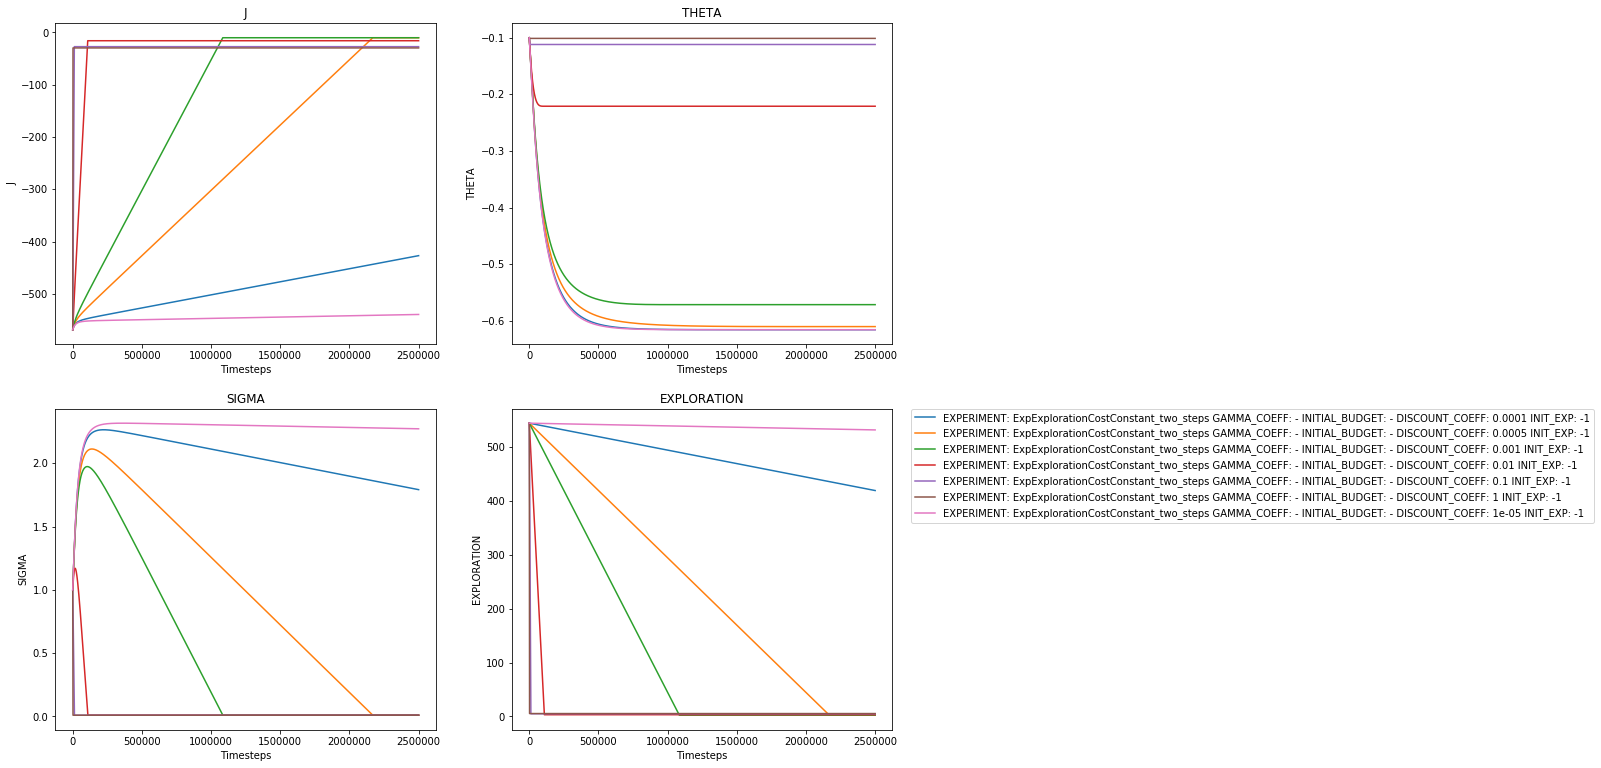

In [69]:
my_plot(lambda_coeff = '-', 
        theta='-0.1', 
        alphaSigma = '-', 
        experiment=['ExpExplorationCostConstant_two_steps'],
        gamma_coeff=None,
        initial_budget=None,
        discount_coeff=None,
        init_exp = None,
        sigma='e(0)',
        value=['J', 'THETA', 'SIGMA', 'EXPLORATION'], 
        max_t=-1,
        df = asdf)

In [73]:
prova_df = load_dataframe('prova/')

In [74]:
asdf = pd.concat([prova_df, load_dataframe('prova2/')]).fillna('-')

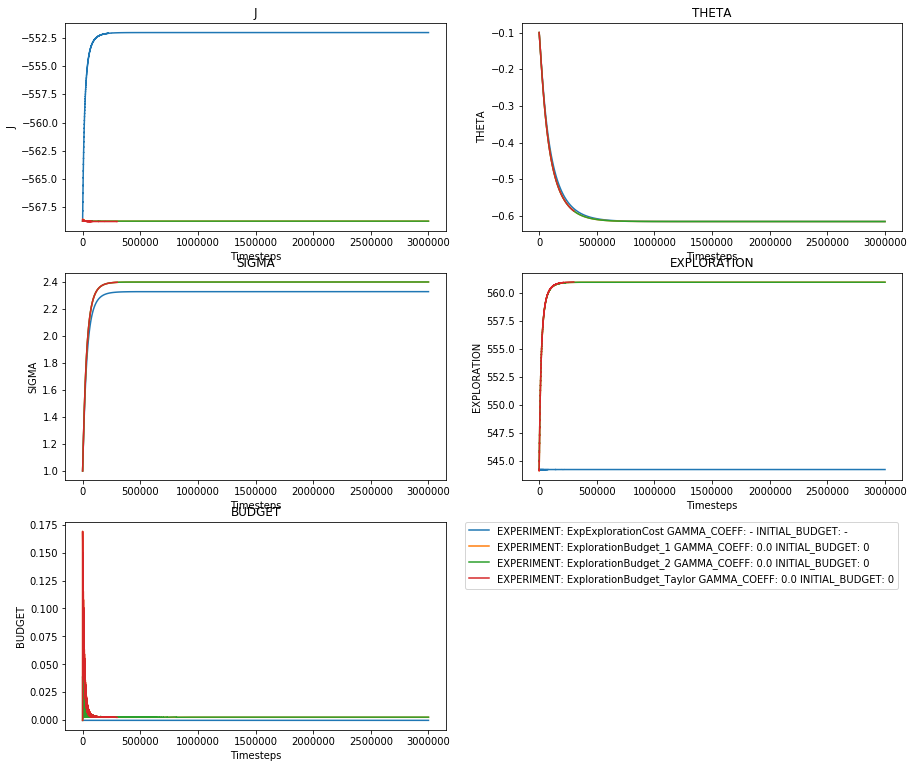

In [75]:
my_plot(lambda_coeff = '-', 
        theta='-0.1', 
        alphaSigma = '-', 
        experiment=None,
        gamma_coeff=None,
        initial_budget=None,
        sigma='e(0)',
        value=['J', 'THETA', 'SIGMA', 'EXPLORATION', 'BUDGET'], 
        max_t=-1,
        df = asdf)

In [104]:
prova_df = load_dataframe('prova2/')

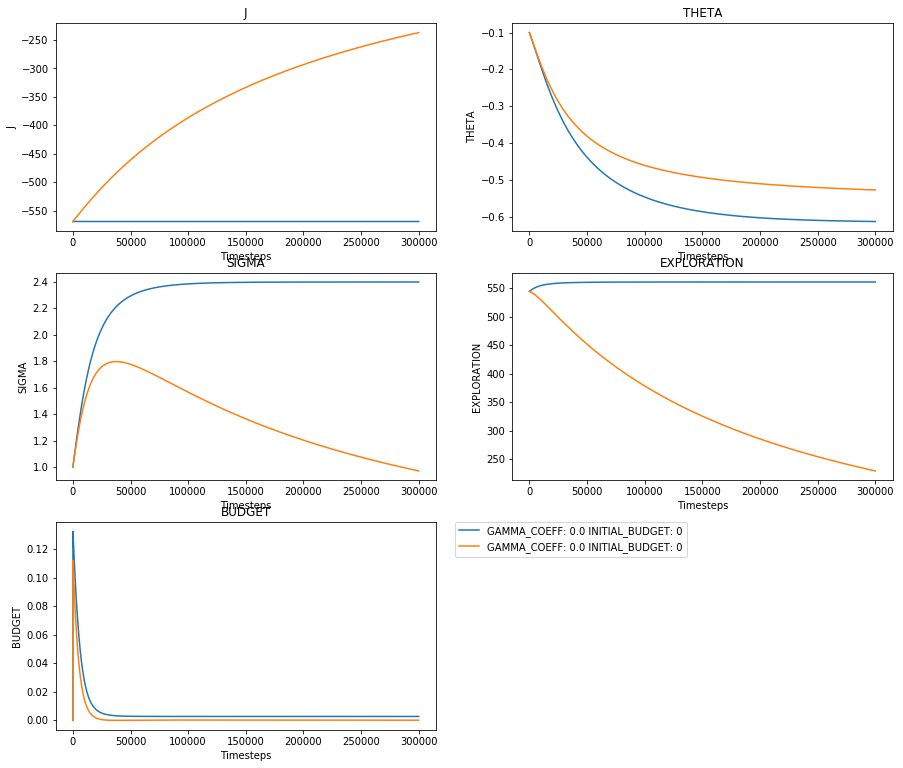

In [105]:
my_plot(lambda_coeff = '-', 
        theta='-0.1', 
        alphaSigma = '-', 
        experiment='ExpSafeConstraintBudgetFork',
        gamma_coeff=None,
        initial_budget=None,
        sigma='e(0)',
        value=['J', 'THETA', 'SIGMA', 'EXPLORATION', 'BUDGET'], 
        max_t=-1,
        df = prova_df)

In [29]:
lqg = lqg1d.LQG1D()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [30]:
lqg.gamma

0.99

In [110]:
lqg.grad_K(-0.2, 1.5)

-1547.764392364752

In [111]:
lqg.grad_K(-0.2, 0)

-53.6603039606415

In [113]:
lqg.grad_Sigma(-0.2, 1.5)

-342.9039301310041

In [121]:
import utils
import math
sigma= 1
d = utils.computeLossSigma(lqg.Q * (lqg.max_pos)**2 + lqg.R * lqg.max_action**2, lqg.max_pos, lqg.gamma, 2*lqg.max_action, sigma)

In [122]:
d

array([[29115137.68741015]])

In [123]:
gradW = lqg.grad_Sigma(-0.1, sigma) * math.exp(sigma)

In [124]:
gradW**2 / (4*d)

array([[0.01879489]])

In [150]:
param=1

In [151]:
lqg.grad_Sigma(-0.2, math.exp(param)) * math.exp(param)

-932.1095221822984

In [112]:
lqg.computeJ(-0.1, 1)

-568.74305906108

In [113]:
lqg.computeJ(-0.101, 1)

-564.5717159423998

In [108]:
lqg.computeJ(-0.1, 0)

-24.472488642099957

In [109]:
lqg.computeJ(-0.101, 0)

-24.259257044978924

In [116]:
lqg.computeJ(-0.2, 0) - lqg.computeJ(-0.2, 1.5)

514.3558951965061

In [178]:
THETA = -0.2
SIGMA = 0.7

step_theta = -1e-10
step_sigma = 1e-10

alpha_sigma = step_sigma / lqg.grad_Sigma(THETA, SIGMA)
alpha_theta = step_theta / lqg.grad_K(THETA, SIGMA)

In [179]:
exp_cost = lqg.computeJ(THETA, 0) - lqg.computeJ(THETA, SIGMA)

In [180]:
exp_cost_after = lqg.computeJ(THETA + step_theta, 0) - lqg.computeJ(THETA + step_theta, SIGMA + step_sigma)

In [181]:
exp_cost - exp_cost_after

3.543448201526189e-08

In [182]:
estimation = -alpha_theta * (lqg.grad_K(THETA, 0))**2 + alpha_theta * (lqg.grad_K(THETA, SIGMA))**2 + alpha_sigma * (lqg.grad_Sigma(THETA, SIGMA))**2
estimation

4.0417035769303134e-08

In [318]:
BASE_FOLDER = 'prova'

p = load_dataframe(BASE_FOLDER)

In [270]:
d = filter_experiments(df=p, name=['ProvaSafe', 'ProvaSafe_update_dopo', 'ProvaSafe_update_dopo_dopo'])

In [254]:
d = filter_experiments(df=p, name=['ProvaGradienti7', 'ProvaGradienti8'])

Budget is negative for:  218 / 2000  times
Budget is negative for:  234 / 2000  times


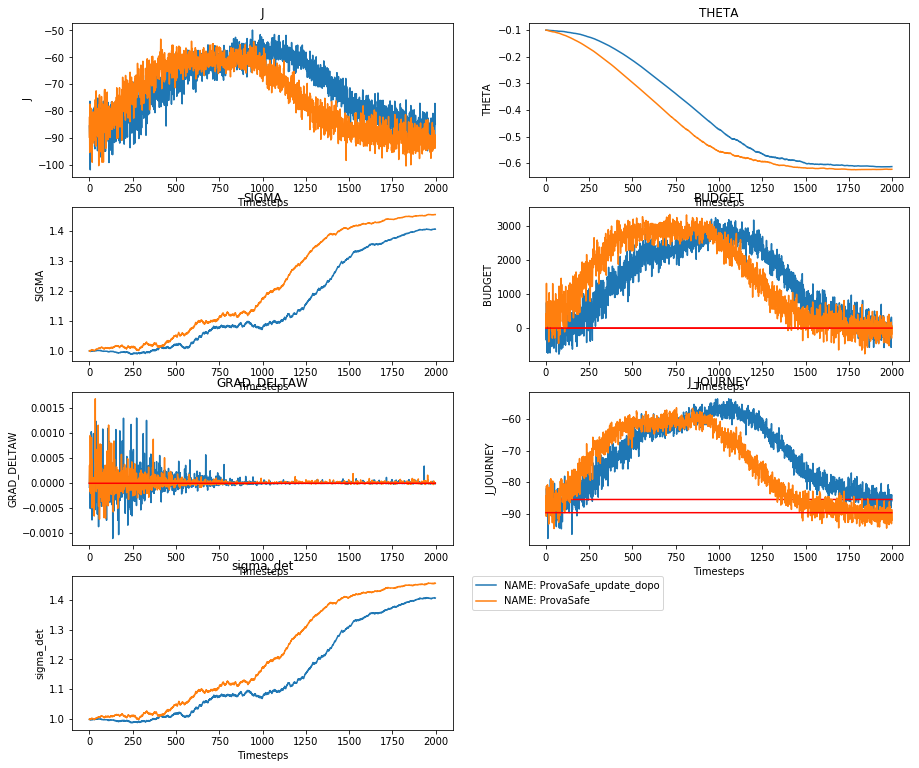

In [320]:
my_plot(value=['J', 'THETA', 'SIGMA', 'BUDGET', 'GRAD_DELTAW', 'J_JOURNEY', 'sigma_det'], 
        min_t = 0,
        max_t=-1,
        name = ['ProvaSafe', 'ProvaSafe_update_dopo'],
        step=1,
        alpha=1,
        df = p)

# Confronto gradienti

In [306]:
BASE_FOLDER = 'prova'

p = load_dataframe(BASE_FOLDER)

d = filter_experiments(df=p, name='ProvaGradienti8')

In [307]:
data = load_from_dataframe(d)[0]

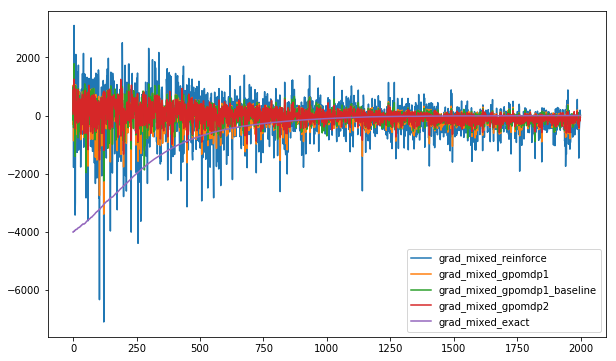

In [308]:
plt.figure(figsize=(10,6))
plt.plot(data['T'], data['grad_mixed_reinforce'])
plt.plot(data['T'], data['grad_mixed_gpomdp1'])
plt.plot(data['T'], data['grad_mixed_gpomdp1_baseline'])
plt.plot(data['T'], data['grad_mixed_gpomdp2'])
plt.plot(data['T'], data['grad_mixed_exact'])

plt.legend(['grad_mixed_reinforce', 'grad_mixed_gpomdp1', 'grad_mixed_gpomdp1_baseline', 'grad_mixed_gpomdp2', 'grad_mixed_exact'])

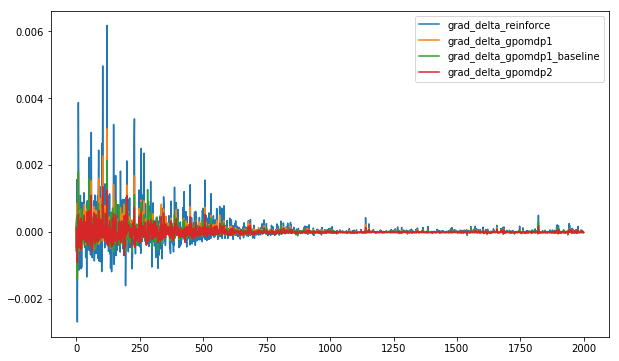

In [309]:
plt.figure(figsize=(10,6))
plt.plot(data['T'], data['grad_delta_reinforce'])
plt.plot(data['T'], data['grad_delta_gpomdp1'])
plt.plot(data['T'], data['grad_delta_gpomdp1_baseline'])
plt.plot(data['T'], data['grad_delta_gpomdp2'])
#plt.plot(data['T'], data['grad_delta_exact'])
plt.legend(['grad_delta_reinforce', 'grad_delta_gpomdp1', 'grad_delta_gpomdp1_baseline', 'grad_delta_gpomdp2', 'grad_delta_exact'])



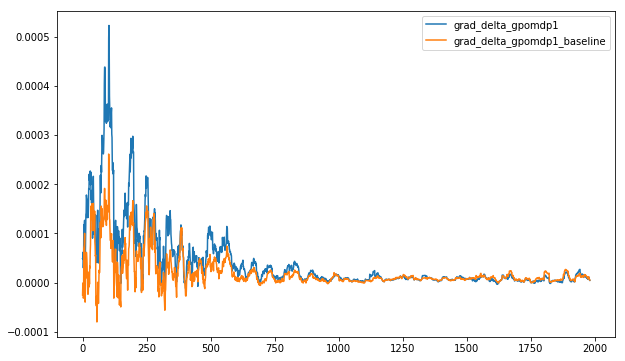

In [313]:
N=20
plt.figure(figsize=(10,6))
#plt.plot(data['T'][:-N+1], np.convolve(data['grad_delta_reinforce'], np.ones((N,))/N, mode='valid'))
plt.plot(data['T'][:-N+1], np.convolve(data['grad_delta_gpomdp1'], np.ones((N,))/N, mode='valid'))
plt.plot(data['T'][:-N+1], np.convolve(data['grad_delta_gpomdp1_baseline'], np.ones((N,))/N, mode='valid'))
#plt.plot(data['T'][:-N+1], np.convolve(data['grad_delta_gpomdp2'], np.ones((N,))/N, mode='valid'))
#plt.plot(data['T'][:-N+1], np.clip(data['grad_delta_exact'][:-N+1], -0.0002, 0.00040))
#plt.legend(['grad_delta_reinforce', 'grad_delta_gpomdp1', 'grad_delta_gpomdp1_baseline', 'grad_delta_gpomdp2', 'grad_delta_exact'])

plt.legend(['grad_delta_gpomdp1', 'grad_delta_gpomdp1_baseline', 'grad_delta_gpomdp2', 'grad_delta_exact'])


In [314]:
print('Standard deviation of plain estimator: ', np.std(data['grad_delta_gpomdp1']))

Standard deviation of plain estimator:  0.00019891408765592957


In [315]:
print('Standard deviation with baseline: ', np.std(data['grad_delta_gpomdp1_baseline']))

Standard deviation with baseline:  0.0001574311015838082


In [321]:
p

DELTA             EXPERIMENT               FILENAME GAMMA MAX_ITER  \
0    0.1             Experiment  prova/PxU5RAQ3gGvu9XV  0.99      200   
1    0.1             Experiment  prova/jG08pl4TnCvxIO7  0.99       50   
2    0.1             Experiment  prova/6pUV7RfITQtP41B  0.99       50   
3    0.1  CollectDataExperiment  prova/PuLH7J5hacNTru0  0.99      500   
4    0.1  CollectDataExperiment  prova/o6wnDXgySnwi8LZ  0.99     1000   
5    0.1  CollectDataExperiment  prova/Xn9nWgTKUi4hQep  0.99     1000   
6    0.1             Experiment  prova/KdrB3UiQRyfuRW2  0.99       50   
7    0.1  CollectDataExperiment  prova/04XRbDCKrpQLdmj  0.99     2000   
8    0.1         SafeExperiment  prova/AcI6LhpGlOfW4xt  0.99     2000   
9    0.1  CollectDataExperiment  prova/NAjdAIkKz7Sv74m  0.99     1000   
10   0.1             Experiment  prova/s9dZk551eqbsYki  0.99       50   
11   0.1  CollectDataExperiment  prova/JWb45oJgTlq3O4G  0.99     1000   
12   0.1             Experiment  prova/YZrgJY1SjcdIu2I  0.99       50   
13   0.1             Experiment  prova/1KT5k3i4iRREgVm  0.99       50   
14   0.1  CollectDataExperiment  prova/TjWUpc88vHPJwni  0.99      500   
15   0.1             Experiment  prova/fi4qynAWi4utgCZ  0.99       50   
16   0.1         SafeExperiment  prova/5U4NifL4ATYtsX7  0.99     2000   
17   0.1  CollectDataExperiment  prova/J1fRJosPNiGqvSc  0.99      500   
18   0.1         SafeExperiment  prova/cNoyn8DB3b1G3wY  0.99     2000   
19   0.1             Experiment  prova/UQaHSruU58qdCF4  0.99       50   
20   0.1             Experiment  prova/KKUQH9CTdGxcUzd  0.99       50   

                          NAME   N_MAX N_MIN     N_TOT PARALLEL  \
0                        Prova  500000    50  30000000     True   
1                        Prova  500000   300  30000000     True   
2                        Prova  500000   301  30000000     True   
3              ProvaGradienti6  500000   300  30000000     True   
4              ProvaGradienti7  500000  3000  30000000     True   
5              ProvaGradienti2  500000   450  30000000     True   
6                        Prova  500000    30  30000000     True   
7              ProvaGradienti8  500000   150  30000000     True   
8   ProvaSafe_update_dopo_dopo  500000   150  30000000     True   
9              ProvaGradienti3  500000  3000  30000000     True   
10                       Prova  500000    31  30000000     True   
11              ProvaGradienti  500000   450  30000000     True   
12                       Prova  500000    31  30000000     True   
13                       Prova  500000   302  30000000     True   
14             ProvaGradienti4  500000   300  30000000     True   
15                       Prova  500000  3000  30000000     True   
16       ProvaSafe_update_dopo  500000   150  30000000     True   
17             ProvaGradienti5  500000   300  30000000     True   
18                   ProvaSafe  500000   150  30000000     True   
19                       Prova  500000   300  30000000     True   
20                       Prova  500000   300  30000000     True   

   USE_LOCAL_STATS VERBOSE  
0             True    True  
1             True    True  
2             True    True  
3             True    True  
4             True    True  
5             True    True  
6             True    True  
7             True    True  
8             True    True  
9             True    True  
10            True    True  
11            True    True  
12            True    True  
13            True    True  
14            True    True  
15            True    True  
16            True    True  
17            True    True  
18            True    True  
19            True    True  
20            True    True

In [356]:
BASE_FOLDER = 'j_det_prima_dopo/'

p = load_dataframe(BASE_FOLDER)

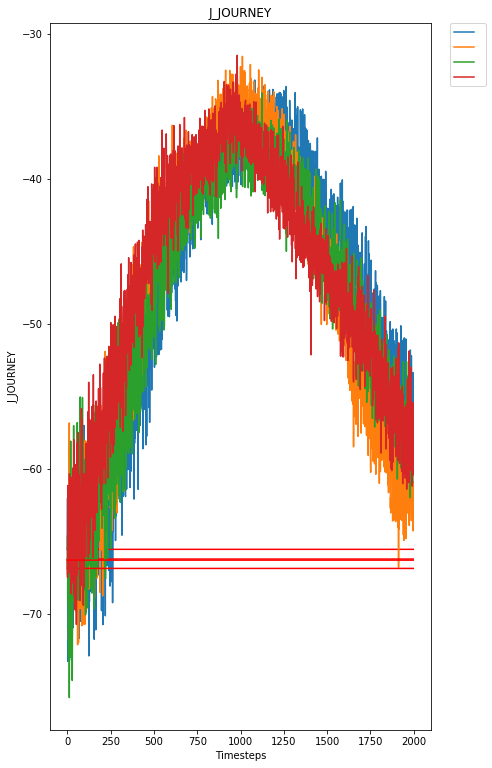

In [358]:
my_plot(value=['J_JOURNEY'], df=p)

# Final results

In [96]:
#BASE_FOLDER = 'experiments_non_exact'
BASE_FOLDER = 'EXPERIMENTS_FINAL_LONG/'

df_final = load_dataframe(BASE_FOLDER)

In [54]:
df_final['BATCH_SIZE'] = df_final['N_MIN']

In [55]:
df_final['EXPERIMENT'].unique()

array(['MonotonicZeroBudgetEveryStep',
       'SimultaneousThetaAndSigma_two_thirds_theta',
       'ExpBudget_SemiDetPolicy', 'ExpBudget_DetPolicy',
       'NoWorseThanBaselineEveryStep', 'MonotonicThetaAndSigma',
       'MonotonicOnlyTheta', 'SimultaneousThetaAndSigma_half',
       'ExpBudget_NoDetPolicy',
       'SimultaneousThetaAndSigma_two_thirds_sigma'], dtype=object)

Initial J+J_DET is:  -109.69736219712743
Average J+J_DET is:  -110.17290726533628
Initial J+J_DET is:  -109.69736219712743
Average J+J_DET is:  -113.3163110192181
Initial J+J_DET is:  -109.69736219712743
Average J+J_DET is:  -112.53282458913063
Initial J+J_DET is:  -86.5720466751432
Average J+J_DET is:  -79.88546069916512
Initial J+J_DET is:  -86.5720466751432
Average J+J_DET is:  -85.5806233743326
Initial J+J_DET is:  -86.5720466751432
Average J+J_DET is:  -86.55671675911071
Initial J+J_DET is:  -86.5720466751432
Average J+J_DET is:  -86.57012297877344
Initial J+J_DET is:  -173.1440933502864
Average J+J_DET is:  -176.20893108675847
Initial J+J_DET is:  -86.5720466751432
Average J+J_DET is:  -88.42265261909515
Initial J+J_DET is:  -110.58722128634828
Average J+J_DET is:  -111.23250786269612


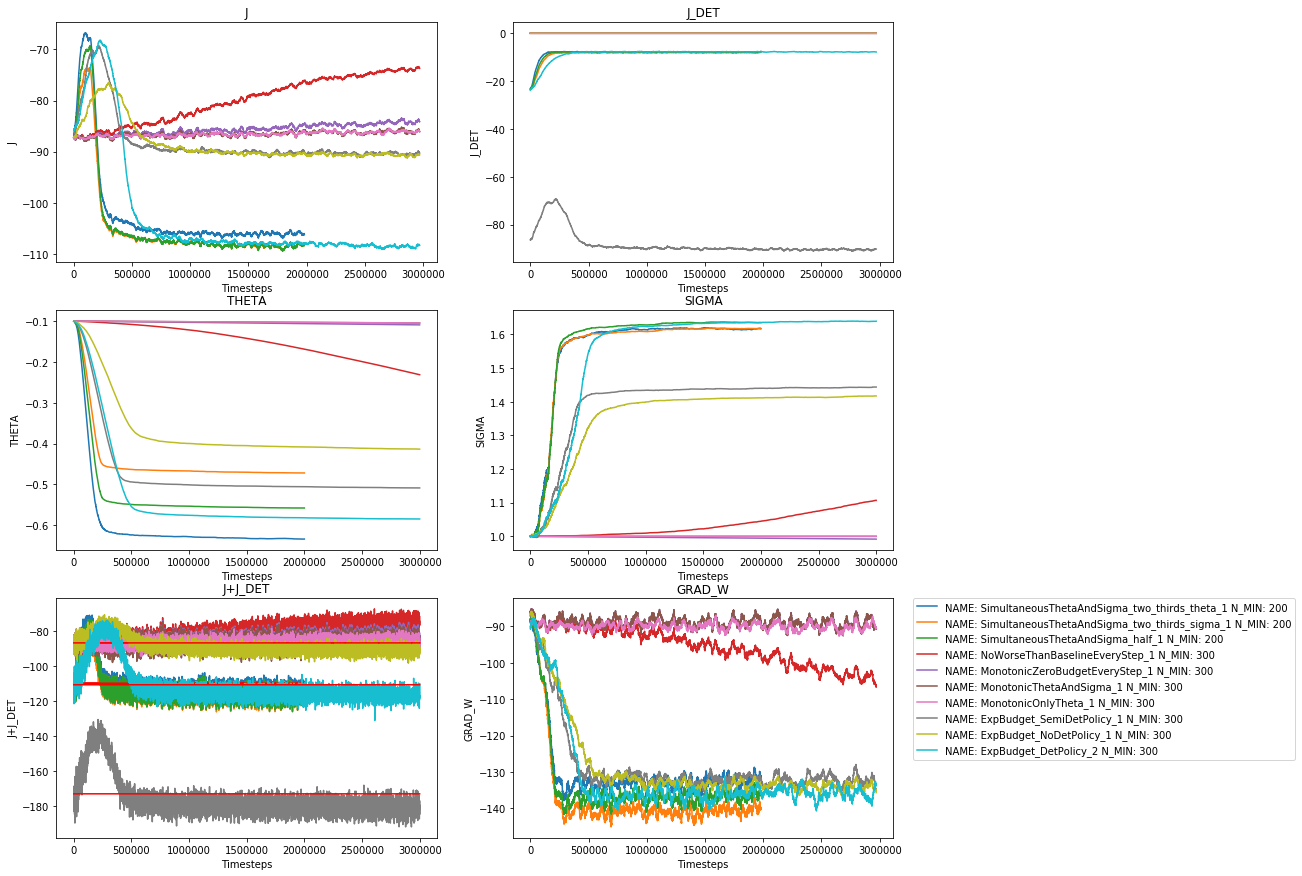

In [98]:
plt.figure(figsize=(15, 15))
my_plot(value=['J', 'J_DET', 'THETA', 'SIGMA', 'J+J_DET', 'GRAD_W'], 
        #value = ['J_DET', 'J+J_DET', 'J_JOURNEY+J_DET', 'J_JOURNEY', 'BUDGET'],
        min_t = 0,
        max_t=-1,
        smooth=['J', 'J_DET', 'GRAD_W'],
        amount = 100,
        x='SAMPLES',
        name=['MonotonicZeroBudgetEveryStep_1', 'ExpBudget_SemiDetPolicy_1','SimultaneousThetaAndSigma_1', 'ExpBudget_DetPolicy_2','NoWorseThanBaselineEveryStep_1', 'MonotonicThetaAndSigma_1','MonotonicOnlyTheta_1', 'ExpBudget_NoDetPolicy_1', 'SimultaneousThetaAndSigma_half_1', 'SimultaneousThetaAndSigma_two_thirds_theta_1', 'SimultaneousThetaAndSigma_two_thirds_sigma_1'],
        #name = ['SimultaneousThetaAndSigma_1'],
        alpha=1,
        n_min=None,
        df = df_final)

Initial J+J_DET is:  -109.69736219712743
Average J+J_DET is:  -110.17290726533628
Initial J+J_DET is:  -109.69736219712743
Average J+J_DET is:  -113.3163110192181
Initial J+J_DET is:  -109.69736219712743
Average J+J_DET is:  -112.53282458913063
Initial J+J_DET is:  -110.58722128634828
Average J+J_DET is:  -111.23250786269612


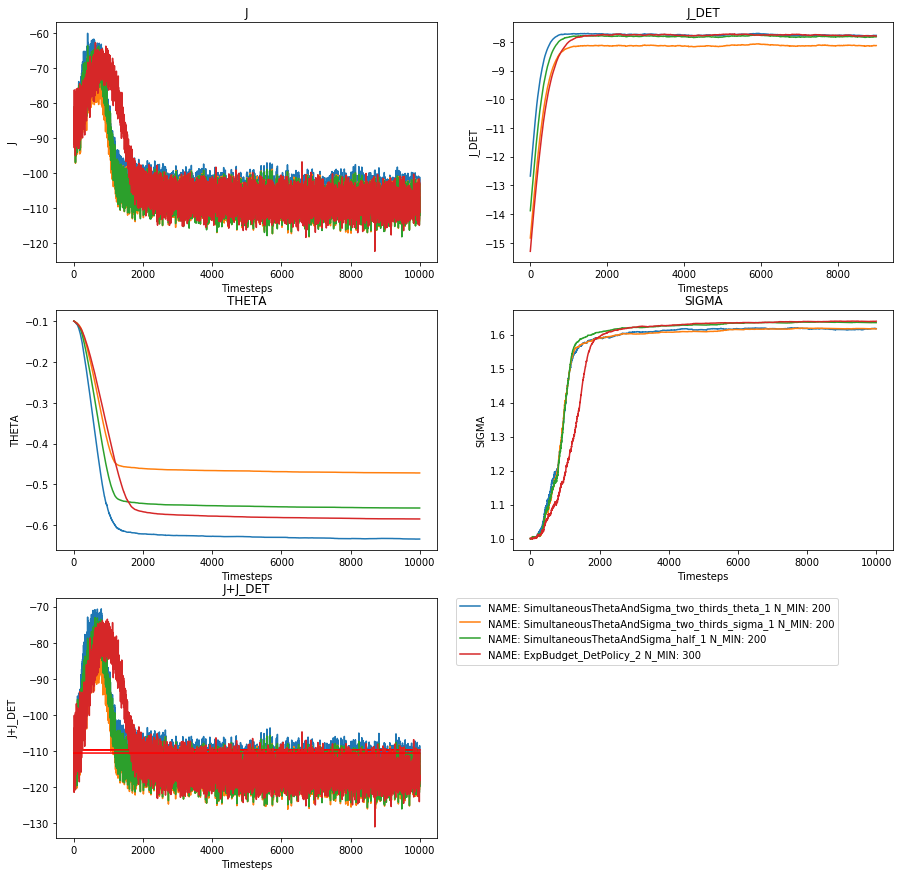

In [27]:
plt.figure(figsize=(15, 15))
my_plot(value=['J', 'J_DET', 'THETA', 'SIGMA', 'J+J_DET'], 
        #value = ['J_DET', 'J+J_DET', 'J_JOURNEY+J_DET', 'J_JOURNEY', 'BUDGET'],
        min_t = 0,
        max_t=-1,
        smooth = ['J_DET'],
        amount = 1000,
        #name=['MonotonicZeroBudgetEveryStep_1', 'ExpBudget_SemiDetPolicy_1','SimultaneousThetaAndSigma_1', 'ExpBudget_DetPolicy_2','NoWorseThanBaselineEveryStep_1', 'MonotonicThetaAndSigma_1','MonotonicOnlyTheta_1', 'ExpBudget_NoDetPolicy_1'],
        name = ['SimultaneousThetaAndSigma_half_1', 'SimultaneousThetaAndSigma_two_thirds_theta_1','ExpBudget_DetPolicy_2', 'SimultaneousThetaAndSigma_two_thirds_sigma_1'],
        alpha=1,
        n_min=None,
        df = df_final)

In [375]:
df_final['EXPERIMENT'].unique()

array(['MonotonicZeroBudgetEveryStep', 'ExpBudget_SemiDetPolicy',
       'SimultaneousThetaAndSigma', 'ExpBudget_DetPolicy',
       'NoWorseThanBaselineEveryStep', 'MonotonicThetaAndSigma',
       'MonotonicOnlyTheta', 'ExpBudget_NoDetPolicy'], dtype=object)

Budget is negative for:  2905 / 4000  times
Budget is negative for:  2759 / 4000  times
Budget is negative for:  2328 / 4000  times
Budget is negative for:  2449 / 4000  times


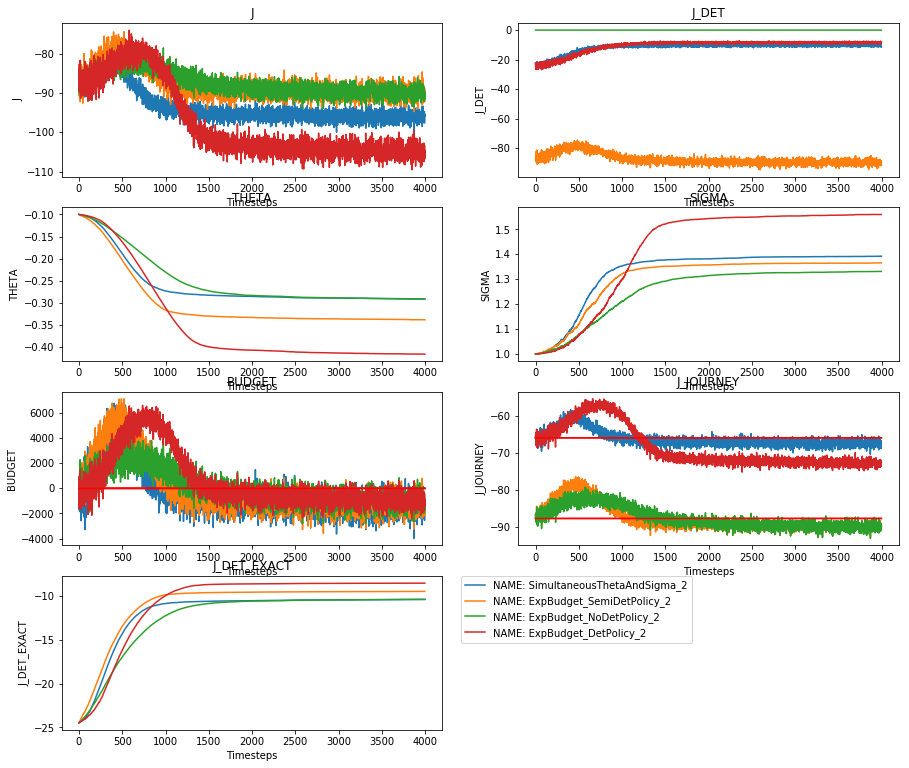

In [393]:
#BASE_FOLDER = 'experiments_non_exact'
BASE_FOLDER = 'EXPERIMENTS_FINAL_2/'

dd = load_dataframe(BASE_FOLDER)

my_plot(value=['J', 'J_DET', 'THETA', 'SIGMA', 'BUDGET', 'J_JOURNEY', 'J_DET_EXACT'], 
        min_t = 0,
        max_t=-1,
#        name=None,
        name = ['ExpBudget_NoDetPolicy_2', 'ExpBudget_DetPolicy_2', 'ExpBudget_SemiDetPolicy_2', 'SimultaneousThetaAndSigma_2'],
        alpha=1,
        df = dd)

In [395]:
dd['EXPERIMENT'].unique()

array(['MonotonicZeroBudgetEveryStep', 'ExpBudget_SemiDetPolicy',
       'SimultaneousThetaAndSigma', 'ExpBudget_DetPolicy',
       'NoWorseThanBaselineEveryStep', 'MonotonicThetaAndSigma',
       'MonotonicOnlyTheta', 'ExpBudget_NoDetPolicy'], dtype=object)

Budget is negative for:  0 / 4000  times
Budget is negative for:  0 / 4000  times


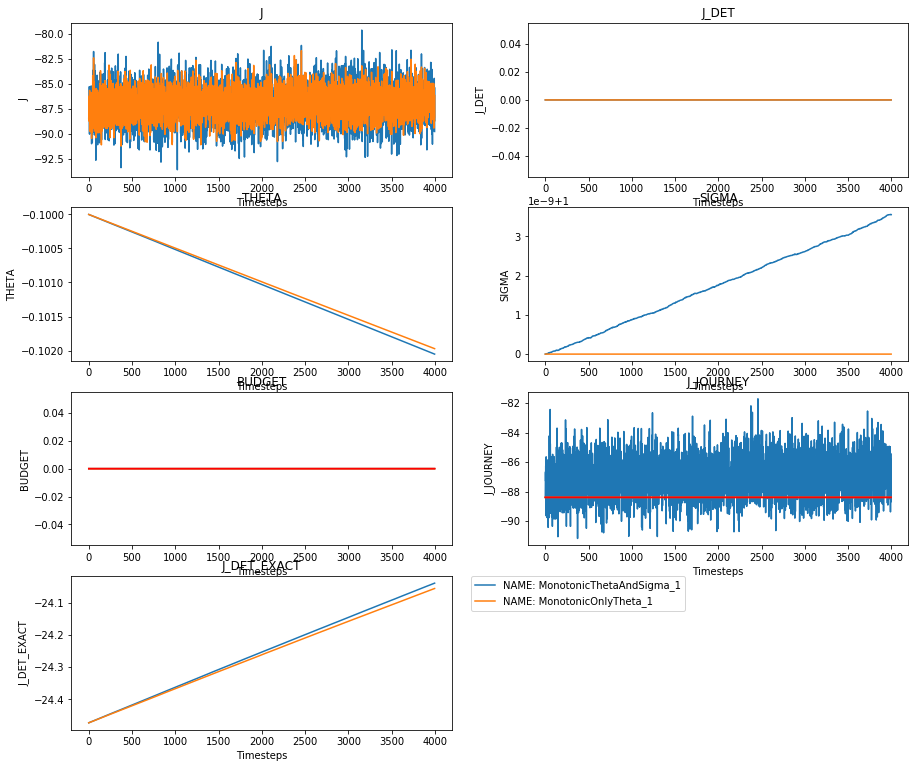

In [398]:
#BASE_FOLDER = 'experiments_non_exact'
BASE_FOLDER = 'EXPERIMENTS_FINAL_2/'

dd = load_dataframe(BASE_FOLDER)

my_plot(value=['J', 'J_DET', 'THETA', 'SIGMA', 'BUDGET', 'J_JOURNEY', 'J_DET_EXACT'], 
        min_t = 0,
        max_t=-1,
#        name=None,
        #name = ['MonotonicOnlyTheta_1', 'MonotonicThetaAndSigma_1', 'MonotonicZeroBudgetEveryStep_1', 'NoWorseThanBaselineEveryStep_1'],
        name = ['MonotonicOnlyTheta_1', 'MonotonicThetaAndSigma_1'],
        alpha=1,
        df = dd)

Budget is negative for:  865 / 2000  times
Budget is negative for:  0 / 2000  times
Budget is negative for:  556 / 2000  times
Budget is negative for:  242 / 2000  times
Budget is negative for:  329 / 2000  times


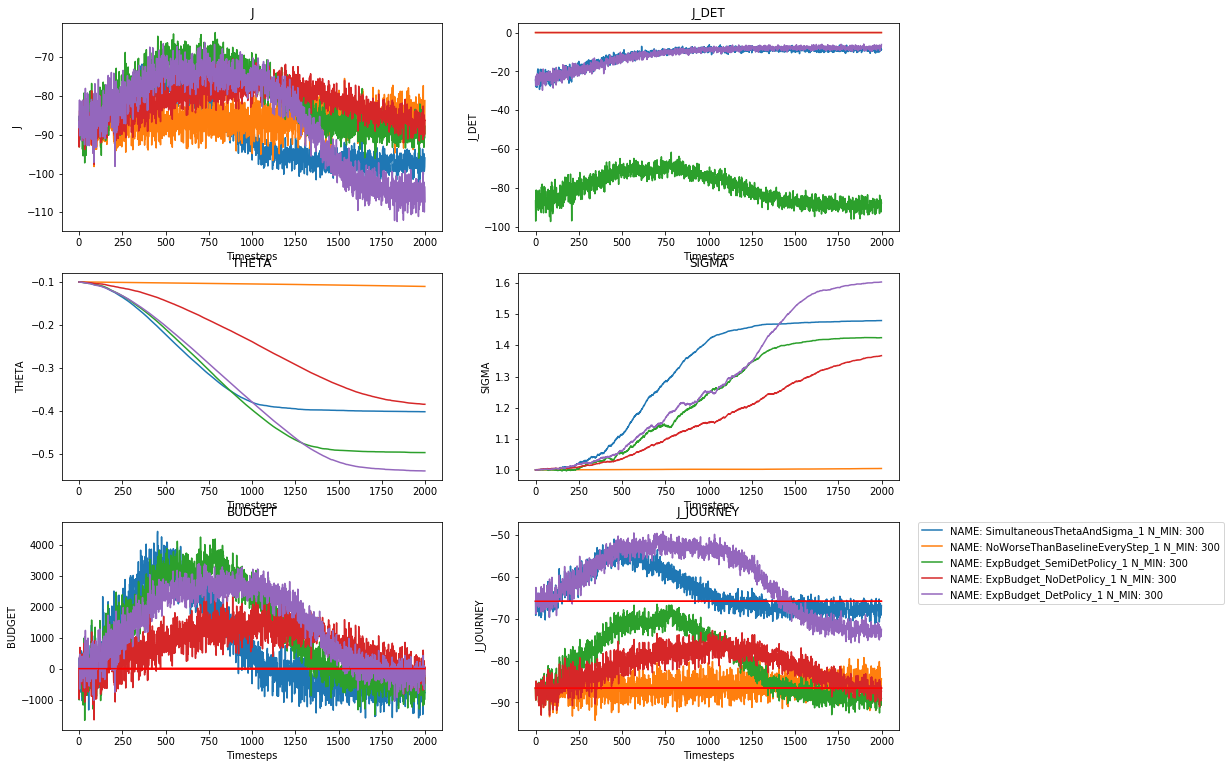

In [558]:
#BASE_FOLDER = 'experiments_non_exact'
BASE_FOLDER = 'EXPERIMENTS_FINAL_MINE/'

dd = load_dataframe(BASE_FOLDER)

my_plot(value=['J', 'J_DET', 'THETA', 'SIGMA', 'BUDGET', 'J_JOURNEY'], 
        min_t = 0,
        max_t=-1,
#        name=None,
        name = ['ExpBudget_NoDetPolicy_1', 'ExpBudget_DetPolicy_1', 'ExpBudget_SemiDetPolicy_1', 'SimultaneousThetaAndSigma_1', 'NoWorseThanBaselineEveryStep_1'],
        alpha=1,
        n_min=None,
        df = dd)

In [47]:
#BASE_FOLDER = 'experiments_non_exact'
BASE_FOLDER = 'EXPERIMENTS_FINAL_LONG/'

dd = load_dataframe(BASE_FOLDER)

Budget is negative for:  7709 / 10000  times
Budget is negative for:  8577 / 10000  times
Budget is negative for:  8446 / 10000  times
Initial J+J_DET is:  -109.1052098140195
Average J+J_DET is:  -109.62193858501804
Initial J+J_DET is:  -109.1052098140195
Average J+J_DET is:  -112.50891998598571
Initial J+J_DET is:  -109.1052098140195
Average J+J_DET is:  -111.53655299579557


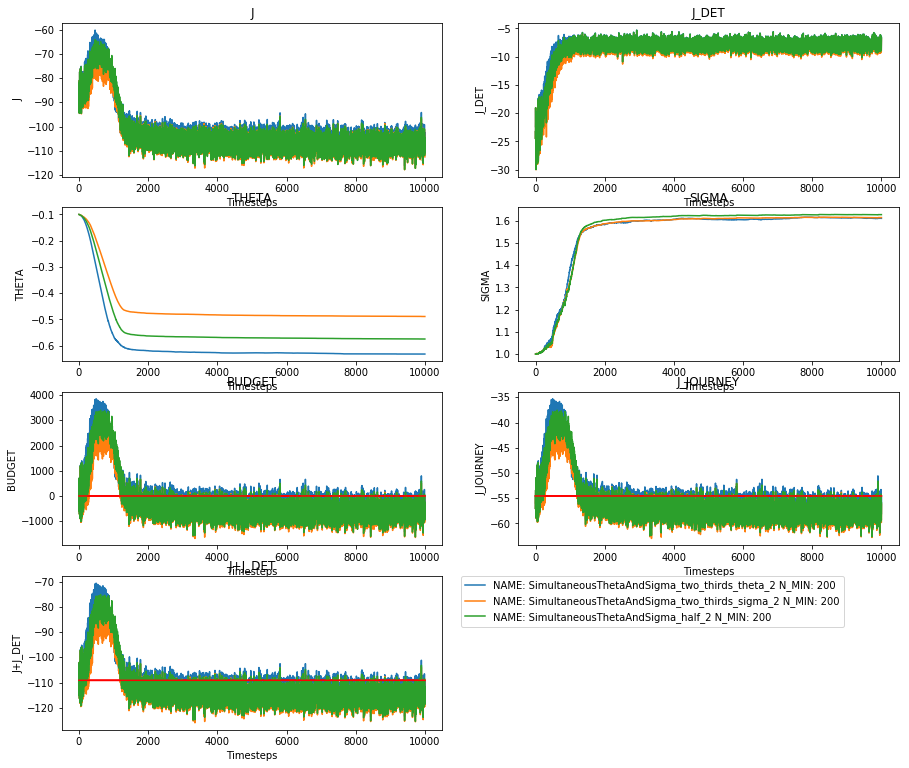

In [77]:
my_plot(value=['J', 'J_DET', 'THETA', 'SIGMA', 'BUDGET', 'J_JOURNEY', 'J+J_DET'], 
        min_t = 0,
        max_t=-1,
        #name=['ExpBudget_SemiDetPolicy_1'],
        name = ['SimultaneousThetaAndSigma_two_thirds_theta_2', 'SimultaneousThetaAndSigma_two_thirds_sigma_2','SimultaneousThetaAndSigma_half_2'],# 'ExpBudget_NoDetPolicy_2', 'ExpBudget_DetPolicy_2', 'ExpBudget_SemiDetPolicy_2', 'SimultaneousThetaAndSigma_2', 'NoWorseThanBaselineEveryStep_2'],
        alpha=1,
        n_min=None,
        df = dd)

In [405]:
data = load_from_dataframe(filter_experiments(df=ddd, name='PROVA_J_JOURNEY'))[0]

In [406]:
data

T  GRAD_THETA     GRAD_W   GRAD_MIXED  GRAD_DELTAW          J      J_DET  \
0  0 -253.584867 -30.059287  1387.781144    -0.001042 -92.253643 -25.223212   
1  1 -206.975476 -70.208909   302.689354    -0.000059 -80.626130 -24.213326   

          ALPHA      BETA   N     THETA     SIGMA      BUDGET  N2  \
0  0.000000e+00  0.000000  40 -0.100000  1.000000    0.000000  13   
1  3.749219e-09  2.638981  40 -0.100001  0.999304  154.912421  13   

     J_JOURNEY  J_DET_EXACT  
0   -69.910166   -24.472489  
1 -1080.947340   -24.472284

Budget is negative for:  252 / 2000  times
Budget is negative for:  252 / 2000  times
Budget is negative for:  1 / 2  times
Initial J+J_DET is:  -113.92655172002313
Average J+J_DET is:  -95.42001236233044
Initial J+J_DET is:  -113.92655172002314
Average J+J_DET is:  -95.42001236233038
Initial J+J_DET is:  -101.64694347245594
Average J+J_DET is:  -104.18235313270023


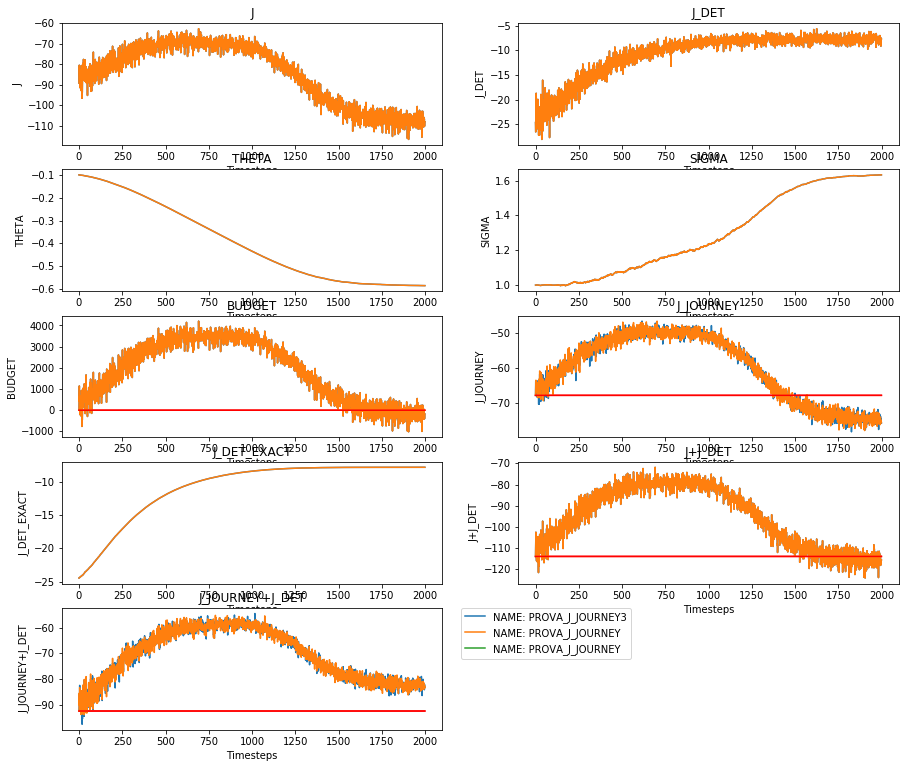

In [539]:
#BASE_FOLDER = 'experiments_non_exact'
BASE_FOLDER = 'prova/'

ddd = load_dataframe(BASE_FOLDER)

my_plot(value=['J', 'J_DET', 'THETA', 'SIGMA', 'BUDGET', 'J_JOURNEY', 'J_DET_EXACT', 'J+J_DET', 'J_JOURNEY+J_DET'], 
        min_t = 0,
        max_t=-1,
#        name=None,
        name = ['PROVA_J_JOURNEY', 'PROVA_J_JOURNEY3'],
        alpha=1,
        df = ddd)

In [508]:
data = load_from_dataframe(filter_experiments(df = ddd, name = ['PROVA_J_JOURNEY4', 'PROVA_J_JOURNEY3']))

In [510]:
d0 = data[0]
d1 = data[1]

In [511]:
d0['J+J_DET'] = d0['J'] + d0['J_DET']

In [512]:
d1['J+J_DET'] = d1['J'] + d1['J_DET']

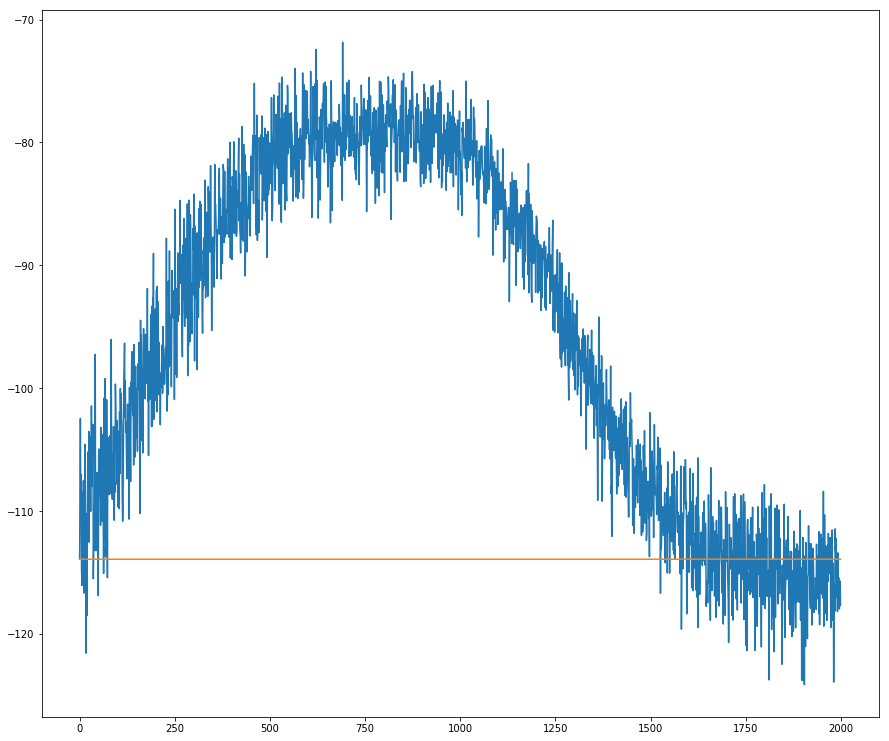

In [519]:
plt.plot(d0['T'], d0['J+J_DET'])
plt.plot(d0['T'], [d0['J+J_DET'][0]] * len(d0['T']))

Initial J+J_DET is:  -593.2155477031799
Average J+J_DET is:  -547.2886906235218
Initial J+J_DET is:  -593.2155477031799
Average J+J_DET is:  -547.3111776608256
Initial J+J_DET is:  -593.2155477031799
Average J+J_DET is:  -518.7561215454798
Initial J+J_DET is:  -593.2155477031799
Average J+J_DET is:  -517.160600274394


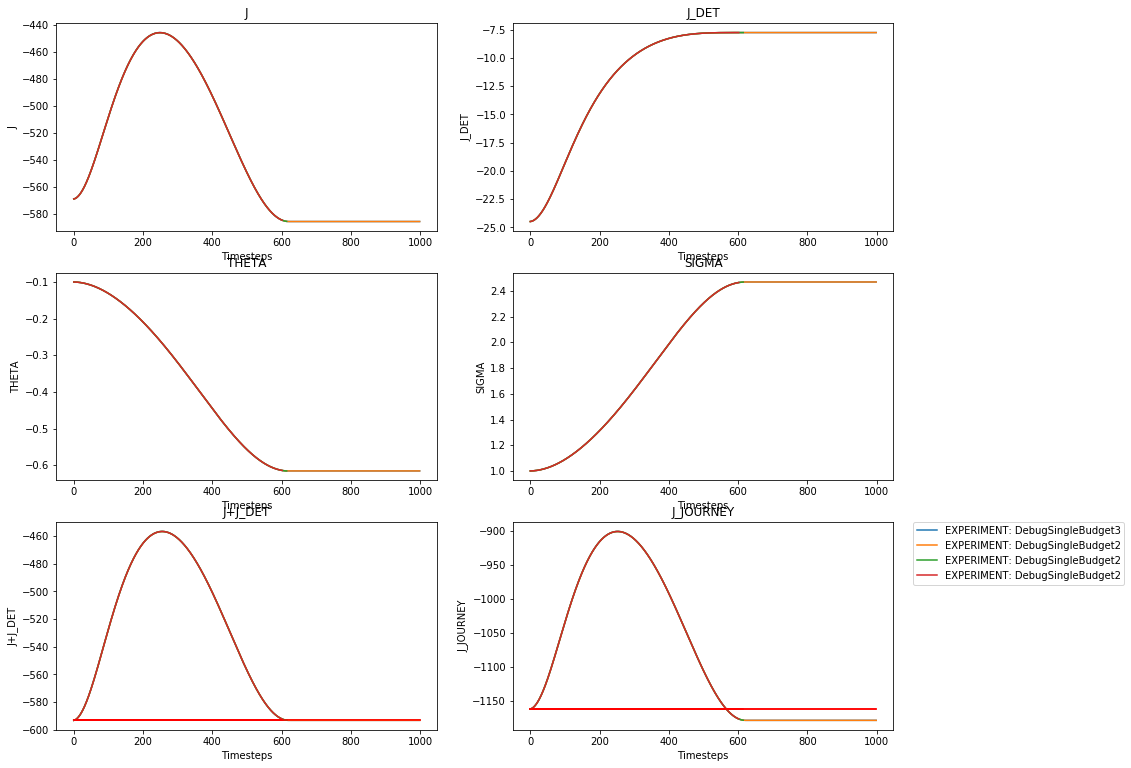

In [506]:
#BASE_FOLDER = 'experiments_non_exact'
BASE_FOLDER = 'prova/'

ddd = load_dataframe(BASE_FOLDER)

my_plot(value=['J', 'J_DET', 'THETA', 'SIGMA', 'J+J_DET', 'J_JOURNEY'], 
        min_t = 0,
        max_t=-1,
#        name=None,
        experiment = ['DebugSingleBudget2', 'DebugSingleBudget3'],
        alpha=1,
        step=2,
        df = ddd)

In [488]:
data = load_from_dataframe(filter_experiments(df = ddd, experiment='DebugSingleBudget2'))[0]

In [489]:
data['J+J_DET'][0]

-593.2155477031799

In [490]:
data['J+J_DET'][1999]

-593.2155477031795

In [501]:
data['J_JOURNEY'][0] + data['J_DET'][0]

-1186.4310954063599

In [500]:
data['J_JOURNEY'][1998] + data['J_DET'][1998]

-1186.4310954063594

In [503]:
data['J_JOURNEY'][1]

-593.1387686696755

In [504]:
data['J_JOURNEY'][1999]

-593.2155477031795

Initial J+J_DET is:  -23.36697449138581
Average J+J_DET is:  -16.553354527578122
Initial J+J_DET is:  -21.72254515013057
Average J+J_DET is:  40.368473535701476
Initial J+J_DET is:  -21.72254515013057
Average J+J_DET is:  27.81587536054571
Budget is negative for:  98 / 200  times
Budget is negative for:  9 / 200  times
Budget is negative for:  36 / 200  times


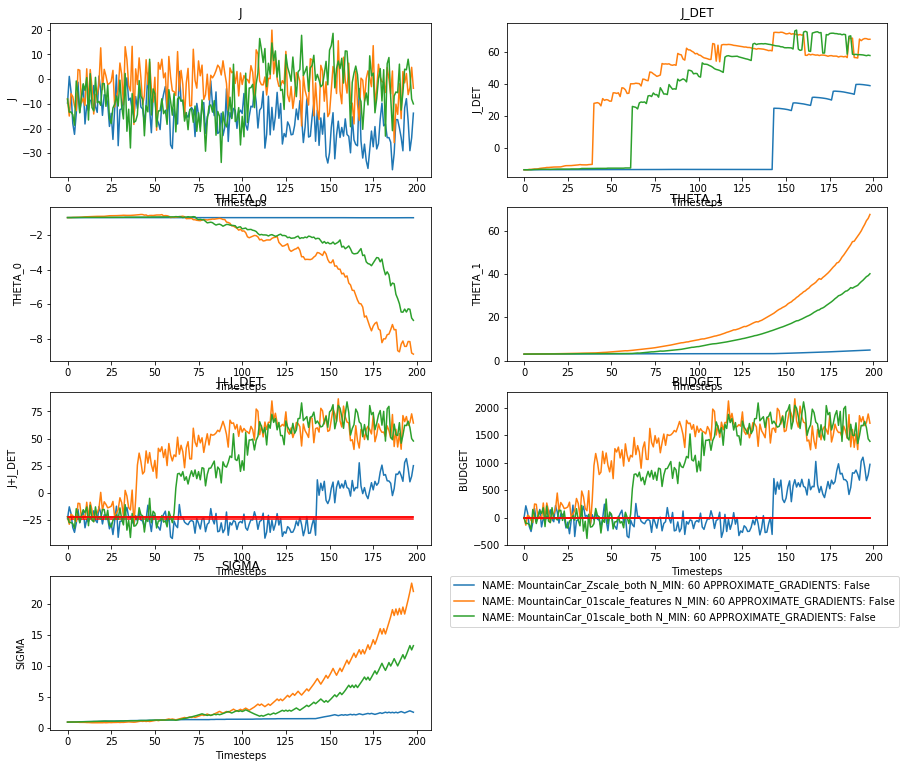

In [43]:
#BASE_FOLDER = 'experiments_non_exact'
BASE_FOLDER = 'prova/'

ddd = load_dataframe(BASE_FOLDER)

my_plot(value=['J', 'J_DET', 'THETA_0', 'THETA_1', 'J+J_DET','BUDGET','SIGMA' ], 
        min_t = 0,
        max_t=-1,
#        name=None,
        name = ['MountainCar_01scale_both', 'MountainCar_Zscale_both', 'MountainCar_01scale_features'],
        alpha=1,
        n_min=None,
        APPROXIMATE_GRADIENTS=None,
        df = ddd)

Initial J+J_DET is:  98.56007794574829
Average J+J_DET is:  109.50101243623594
Budget is negative for:  5 / 100  times


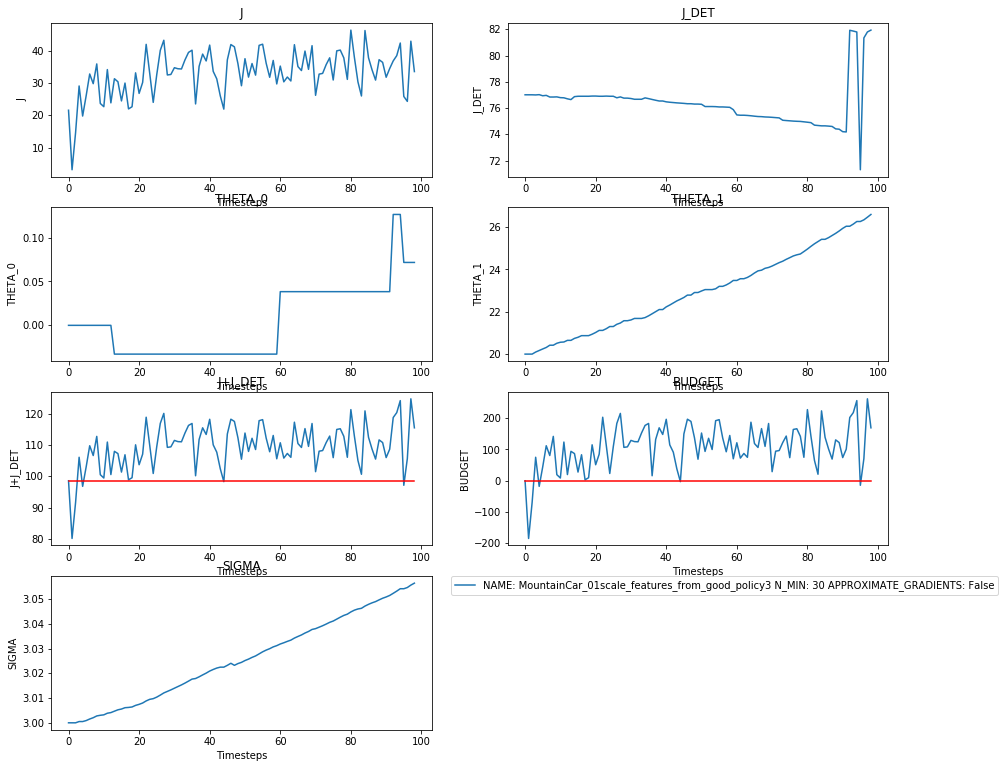

In [45]:
#BASE_FOLDER = 'experiments_non_exact'
BASE_FOLDER = 'prova/'

ddd = load_dataframe(BASE_FOLDER)

my_plot(value=['J', 'J_DET', 'THETA_0', 'THETA_1', 'J+J_DET','BUDGET','SIGMA' ], 
        min_t = 0,
        max_t=-1,
#        name=None,
        name = ['MountainCar_01scale_features_from_good_policy3'],
        alpha=1,
        n_min=None,
        APPROXIMATE_GRADIENTS=None,
        df = ddd)

# MountainCar

In [261]:
ddd

APPROXIMATE_GRADIENTS DELTA                      EXPERIMENT  \
0                  False   0.2             ExpBudget_DetPolicy   
1                  False   0.2             ExpBudget_DetPolicy   
2                  False   0.2              MonotonicOnlyTheta   
3                  False   0.2              MonotonicOnlyTheta   
4                  False   0.2             ExpBudget_DetPolicy   
5                  False   0.2             ExpBudget_DetPolicy   
6                  False   0.2              MonotonicOnlyTheta   
7                  False   0.2              MonotonicOnlyTheta   
8                  False   0.2              MonotonicOnlyTheta   
9                  False   0.2              MonotonicOnlyTheta   
10                 False   0.2             ExpBudget_DetPolicy   
11                 False   0.2              MonotonicOnlyTheta   
12                 False   0.2  SimultaneousThetaAndSigma_half   
13                 False   0.2             ExpBudget_DetPolicy   
14                 False   0.2         ExpBudget_SemiDetPolicy   

                                             FILENAME  GAMMA MAX_ITER  \
0   MountainCar/MountainCarFromGoodPolicy_notweak2...  0.999    10000   
1              MountainCar/Det_newnormsNU3gWNjMFOsNtV  0.995    10000   
2          MountainCar/LS_5e-6_newnormdTMT8ztBCqpPaMc  0.995    10000   
3      MountainCar/LS_5e-6_newnorm_0.15myjKrRGFLsqoro  0.995    25000   
4            MountainCar/Ours_notweaksiK2ZWeqhFWCEPyY  0.999    10000   
5              MountainCar/Det_newnormcluYQVCNQlKkAie  0.995    10000   
6      MountainCar/LearnSimple0.000001iK2ZWeqhFWCEPyY  0.999    10000   
7   MountainCar/LearnSimpleBad_0.00001iK2ZWeqhFWCEPyY  0.999    10000   
8          MountainCar/LS_5e-6_newnormbTMXNRXahSOX3Oc  0.995    10000   
9          MountainCar/LS_1e-4_newnormYemIb5H5xEWpvbT  0.995    10000   
10  MountainCar/MountainCarBadPolicy_notweaks2yW4A...  0.999    10000   
11  MountainCar/LearnSimpleGood0.00001iK2ZWeqhFWCEPyY  0.999    10000   
12   MountainCar/MC_bad_policy_conf1002yW4Acq9GFz6Y1t  0.999    10000   
13         MountainCar/Det_newnorm_0.1pnesN14TZV9HmGV  0.995    25000   
14   MountainCar/Ours_SemiDet_notweaksiK2ZWeqhFWCEPyY  0.999    10000   

                                 NAME   N_MAX N_MIN     N_TOT PARALLEL  \
0   MountainCarFromGoodPolicy_notweak  500000   100  30000000     True   
1                         Det_newnorm  500000   300  30000000     True   
2                     LS_5e-6_newnorm  500000   300  30000000     True   
3                 LS_5e-6_newnorm_0.1  500000   100  30000000     True   
4                       Ours_notweaks  500000   100  30000000     True   
5                         Det_newnorm  500000   300  30000000     True   
6                 LearnSimple0.000001  500000   100  30000000     True   
7              LearnSimpleBad_0.00001  500000   100  30000000     True   
8                     LS_5e-6_newnorm  500000   100  30000000     True   
9                     LS_1e-4_newnorm  500000   100  30000000     True   
10      MountainCarBadPolicy_notweaks  500000   100  30000000     True   
11             LearnSimpleGood0.00001  500000   100  30000000     True   
12              MC_bad_policy_conf100  500000    50  30000000     True   
13                    Det_newnorm_0.1  500000   300  30000000     True   
14              Ours_SemiDet_notweaks  500000   100  30000000     True   

                  SIGMA THETA_0 THETA_1 USE_LOCAL_STATS VERBOSE  
0                     -       -       -            True    True  
1                  0.05    -0.1     0.3            True    True  
2                  0.05    -0.1     0.3            True    True  
3   0.10000000000000002    -0.1     0.3            True    True  
4                     -       -       -            True    True  
5                   0.4    -0.4     4.5            True    True  
6                     -       -       -            True    True  
7                     -       -       -            True    True 

In [263]:
v = load_from_dataframe(filter_experiments(df = ddd, name='LS_5e-6_newnorm_0.1'))[0]

Initial J+J_DET is:  0.39999136497189647
Average J+J_DET is:  11.646882730055204
Budget is negative for:  650 / 40000  times


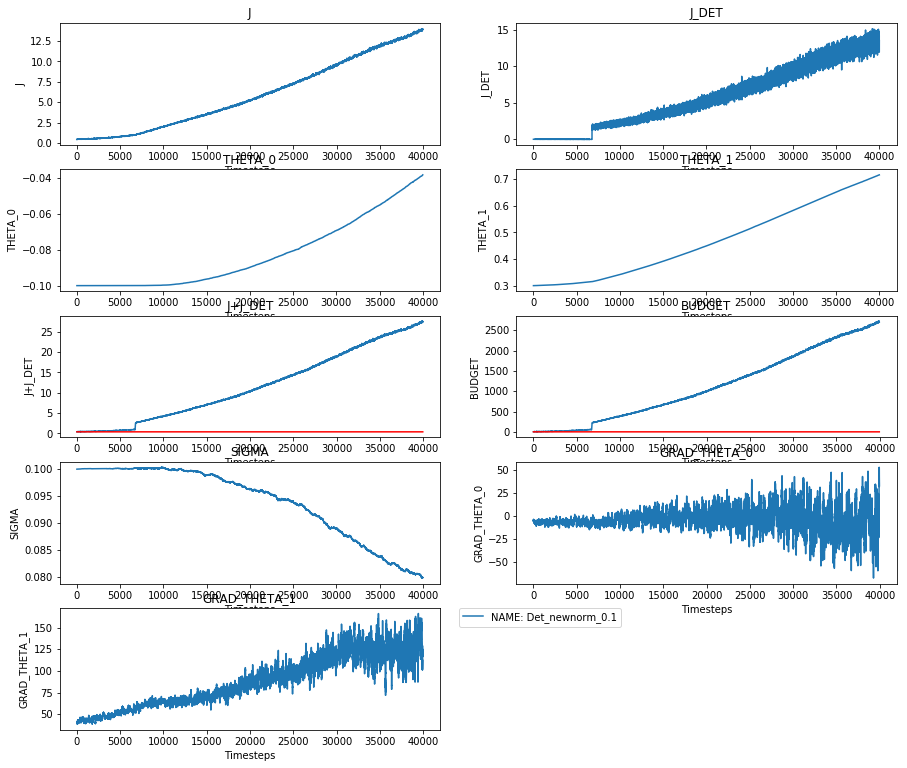

In [93]:
BASE_FOLDER = 'MountainCar/'

ddd = load_dataframe(BASE_FOLDER)

my_plot(value=['J', 'J_DET', 'THETA_0', 'THETA_1', 'J+J_DET','BUDGET','SIGMA', 'GRAD_THETA_0', 'GRAD_THETA_1' ], 
        min_t = 0,
        max_t=-1,
        smooth=['J', 'J+J_DET', 'BUDGET', 'GRAD_THETA_0', 'GRAD_THETA_1'],
        amount=50,
        name=None,
        theta_0='-0.1',
        max_iter='40000',
        df = ddd)

Initial J+J_DET is:  0.4046673290630449
Average J+J_DET is:  -5.492486961221509
Initial J+J_DET is:  -1.6071150861440437
Average J+J_DET is:  70.64736391245233
Initial J+J_DET is:  -2.300814181724318
Average J+J_DET is:  4.881596205127699
Budget is negative for:  0 / 25000  times
Budget is negative for:  0 / 25000  times
Budget is negative for:  11399 / 25000  times


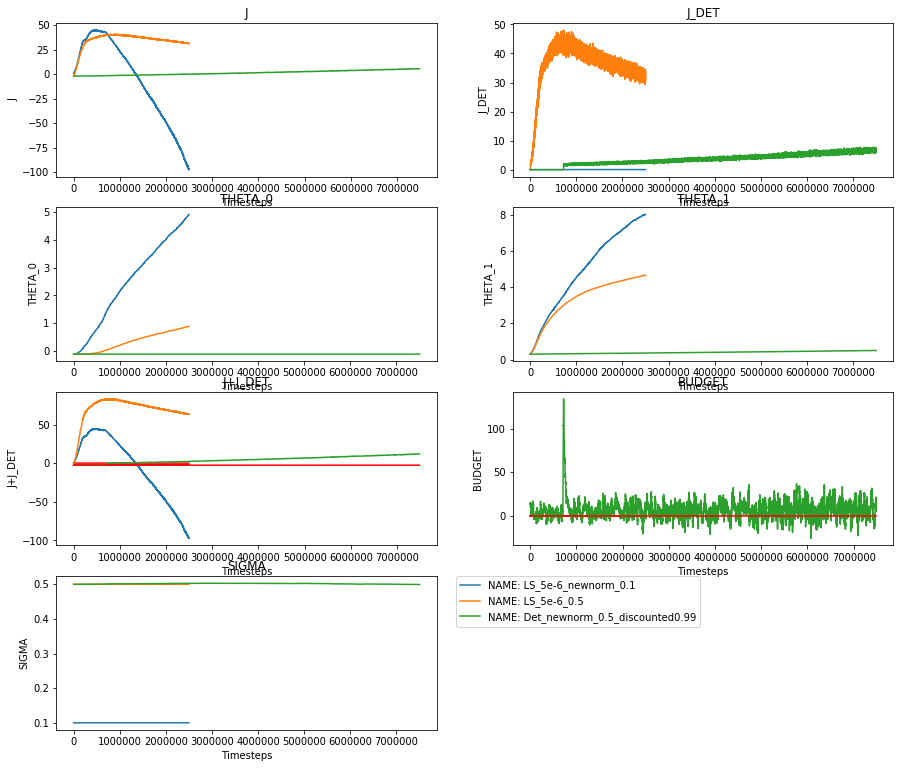

In [13]:
BASE_FOLDER = 'MountainCar/'

ddd = load_dataframe(BASE_FOLDER)

my_plot(value=['J', 'J_DET', 'THETA_0', 'THETA_1', 'J+J_DET','BUDGET','SIGMA' ], 
        min_t = 0,
        max_t=-1,
        x='SAMPLES',
        smooth=['J', 'J+J_DET', 'BUDGET'],
        amount=50,
        name=['LS_5e-6_0.5', 'LS_5e-6_newnorm_0.1', 'Det_newnorm_0.5_discounted0.99'],
        #theta_0='-0.1',
        max_iter='25000',
        df = ddd)

Initial J+J_DET is:  -140845.5760737916
Average J+J_DET is:  -139591.93529974902
Initial J+J_DET is:  -131281.17666234332
Average J+J_DET is:  -139759.73485365123
Budget is negative for:  1510 / 2000  times
Budget is negative for:  1822 / 2000  times


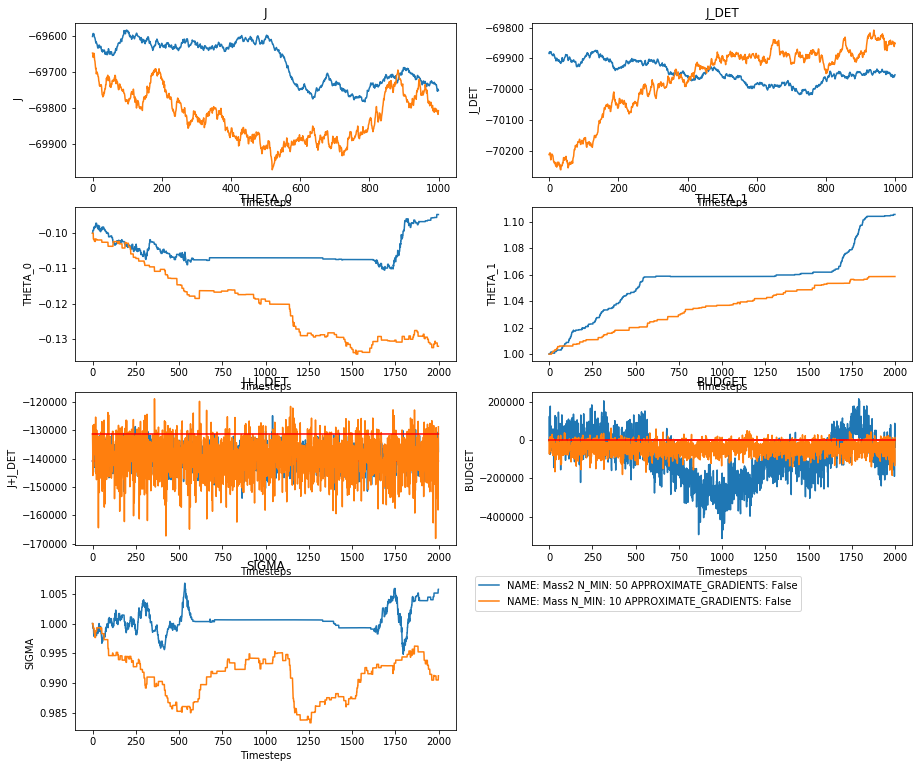

In [115]:
#BASE_FOLDER = 'experiments_non_exact'
BASE_FOLDER = 'exp_mass/'

ddd = load_dataframe(BASE_FOLDER)

my_plot(value=['J', 'J_DET', 'THETA_0', 'THETA_1', 'J+J_DET','BUDGET','SIGMA' ], 
        smooth = ['J', 'J_DET'],
        amount = 1000,
        min_t = 0,
        max_t=-1,
#        name=None,
        name = None,
        alpha=1,
        n_min=None,
        APPROXIMATE_GRADIENTS=None,
        df = ddd)

In [9]:
ddd

APPROXIMATE_GRADIENTS DELTA           EXPERIMENT  \
0                 False   0.2   MonotonicOnlyTheta   
1                 False   0.2   MonotonicOnlyTheta   
2                 False   0.2  ExpBudget_DetPolicy   
3                 False   0.2  ExpBudget_DetPolicy   

                                            FILENAME  GAMMA MAX_ITER  \
0  MountainCar_correct/LearnSimple_0.000001iK2ZWe...  0.999    15000   
1  MountainCar_correct/LearnSimple0.000001iK2ZWeq...  0.999    15000   
2         MountainCar_correct/Ours_MCiK2ZWeqhFWCEPyY  0.999    15000   
3         MountainCar_correct/MC_oursiK2ZWeqhFWCEPyY  0.999    15000   

                   NAME   N_MAX N_MIN     N_TOT PARALLEL USE_LOCAL_STATS  \
0  LearnSimple_0.000001  500000   100  30000000     True            True   
1   LearnSimple0.000001  500000   100  30000000     True            True   
2               Ours_MC  500000   300  30000000     True            True   
3               MC_ours  500000   300  30000000     True            True   

  VERBOSE  
0    True  
1    True  
2    True  
3    True

Initial J+J_DET is:  -15.749245914189792
Average J+J_DET is:  -15.864144156268177
Initial J+J_DET is:  -15.709963389377792
Average J+J_DET is:  -15.801565006520335
Budget is negative for:  13938 / 15000  times
Budget is negative for:  0 / 15000  times


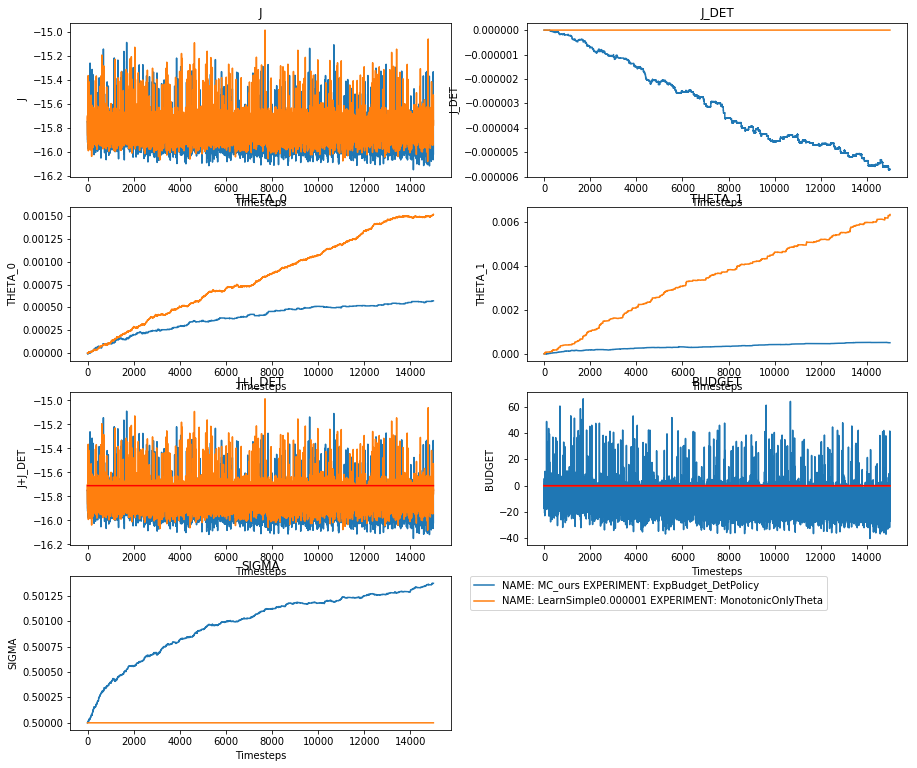

In [13]:
#BASE_FOLDER = 'experiments_non_exact'
BASE_FOLDER = 'MountainCar_correct/'

ddd = load_dataframe(BASE_FOLDER)

my_plot(value=['J', 'J_DET', 'THETA_0', 'THETA_1', 'J+J_DET','BUDGET','SIGMA' ], 
        min_t = 0,
        max_t=-1,
        #smooth=['J', 'J+J_DET'],
        #amount=1000,
        #name=None,
        
        name = ['LearnSimple0.000001', 'MC_ours'],
        alpha=1,
        experiment=None,
        df = ddd)

Initial J+J_DET is:  -1.009406554806466
Average J+J_DET is:  -0.44509200291560497
Initial J+J_DET is:  -0.8183743545805992
Average J+J_DET is:  -0.6861762803697241
Budget is negative for:  175 / 15000  times
Budget is negative for:  0 / 15000  times


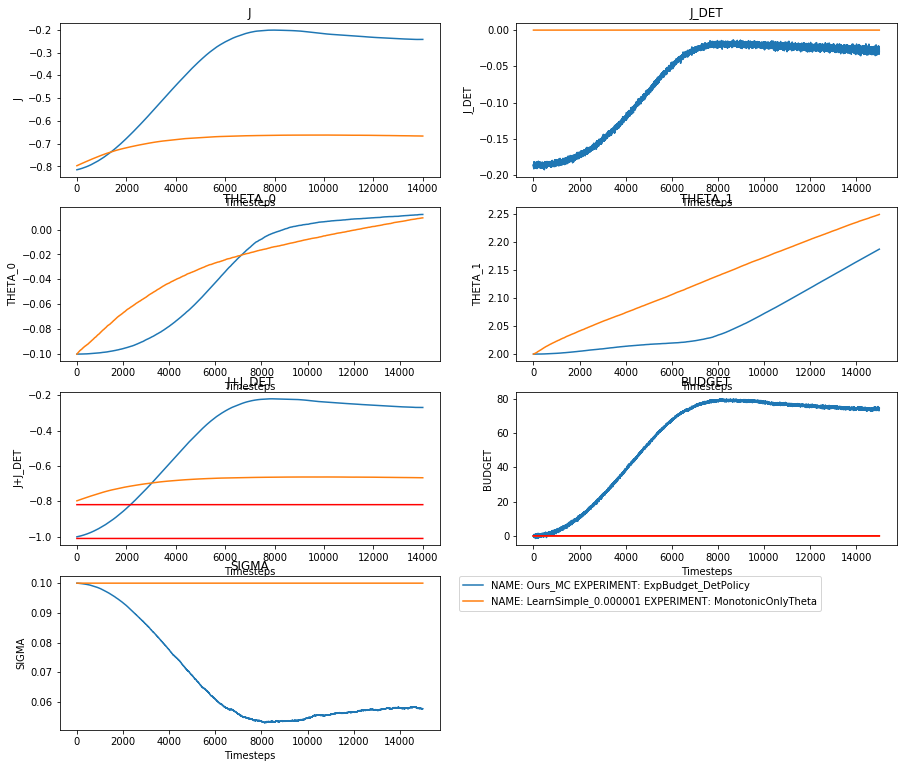

In [11]:
#BASE_FOLDER = 'experiments_non_exact'
BASE_FOLDER = 'MountainCar_correct/'

ddd = load_dataframe(BASE_FOLDER)

my_plot(value=['J', 'J_DET', 'THETA_0', 'THETA_1', 'J+J_DET','BUDGET','SIGMA' ], 
        min_t = 0,
        max_t=-1,
        smooth=['J', 'J+J_DET'],
        amount=1000,
        #name=None,
        
        name = ['LearnSimple_0.000001', 'Ours_MC'],
        alpha=1,
        experiment=None,
        df = ddd)

# Cartpole

In [37]:
def get_policy_values_at_timestep(df, exp_name, timestep=-1):
    df = load_from_dataframe(filter_experiments(df=df, name=exp_name))[0]
    theta_cols = list(filter(lambda x : x.startswith('THETA'), df.columns))
    return df.iloc[timestep][theta_cols].values

In [38]:
def get_policy(df, exp_name, timestep=-1, sigma=.1):
    theta_mat = get_policy_values_at_timestep(df, exp_name, timestep)
    return policies.GaussPolicy(theta_mat, sigma)

In [84]:
def evaluate_policy(env, pol, N=1, H=200, gamma=0.99, deterministic=False, seed=1):
    feature_fun = fast_utils.normalize_cartpole
    try:
        env.seed(seed)
    except:
        env._seed(seed)
#    env.length=1
    avg_perf=0
    x = 0
    for i in range(N):
        t = 0
        finished = False

        s = env.reset()
        perf=0
        while (finished == False) and (t < H):
            s_norm = feature_fun(s)
            try:
                s, r, finished, _ = env.step(np.clip(pol.act(s_norm, deterministic=deterministic), -10, 10))
            except:
                s, r, finished, _ = env._step(np.clip(pol.act(s_norm, deterministic=deterministic), -10, 10))
            perf += (gamma**t)*r
            t+=1
        avg_perf+=perf
        x+=t
    avg_perf /= N
    x /= N
    return x, avg_perf

In [43]:
env = gym.make('ContCartPole-v0')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [45]:
import cartpole_rllab

In [46]:
env2 = gym.make('ContCartPoleRLLab-v0')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [352]:
pol_1 = get_policy(ddd, 'LS_1e-2', 19999)
pol_2 = get_policy(ddd, 'Det_nonorm', -1)

In [353]:
print(pol_1.theta_mat)

[[ 6.18076189 88.80789608  1.7953902  97.14745045]]


In [354]:
evaluate_policy(env, pol_1, N=200, H=200, deterministic=True, seed=5)

WARN: Could not seed environment <ContCartPole<ContCartPole-v0>>


80.9033776824099

In [356]:
evaluate_policy(env, pol_2, N=200, H=200, deterministic=True, seed=5)

WARN: Could not seed environment <ContCartPole<ContCartPole-v0>>


86.60203251420366

In [436]:
filter_experiments(df=ddd, name=['SimTheta_newnorm', 'SimHalf_newnorm', 'LS_1e-4_newnorm', 'Det_newnorm'])

APPROXIMATE_GRADIENTS DELTA                                  EXPERIMENT  \
2                  False   0.2                          MonotonicOnlyTheta   
5                  False   0.2              SimultaneousThetaAndSigma_half   
8                  False   0.2  SimultaneousThetaAndSigma_two_thirds_theta   
15                 False   0.2                         ExpBudget_DetPolicy   
16                 False   0.2              SimultaneousThetaAndSigma_half   
17                 False   0.2                         ExpBudget_DetPolicy   

                                    FILENAME GAMMA MAX_ITER              NAME  \
2    Cartpole/LS_1e-4_newnormabcdefghijklmno  0.99    20000   LS_1e-4_newnorm   
5    Cartpole/SimHalf_newnormXHkMkcnspKkaSpu  0.99    10000   SimHalf_newnorm   
8   Cartpole/SimTheta_newnormEskY2AjxMj5bHpL  0.99    20000  SimTheta_newnorm   
15       Cartpole/Det_newnorm4r2LTRm65GpGyln  0.99    35000       Det_newnorm   
16   Cartpole/SimHalf_newnormN63KqmSsHttRCwJ  0.99    35000   SimHalf_newnorm   
17       Cartpole/Det_newnorm63CmLPXkVTgC0Gd  0.99    20000       Det_newnorm   

     N_MAX N_MIN     N_TOT PARALLEL                SIGMA THETA_0 THETA_1  \
2   500000   100  30000000     True  0.10000000000000002     0.0     0.0   
5   500000   200  30000000     True  0.10000000000000002     0.0     0.0   
8   500000   200  30000000     True  0.10000000000000002     0.0     0.0   
15  500000   300  30000000     True  0.10000000000000002     0.0     0.0   
16  500000   200  30000000     True  0.10000000000000002     0.0     0.0   
17  500000   300  30000000     True  0.10000000000000002     0.0     0.0   

   THETA_2 THETA_3 USE_LOCAL_STATS VERBOSE  
2      0.0     0.0            True    True  
5      0.0     0.0            True    True  
8      0.0     0.0            True    True  
15     0.0     0.0            True    True  
16     0.0     0.0            True    True  
17     0.0     0.0            True    True

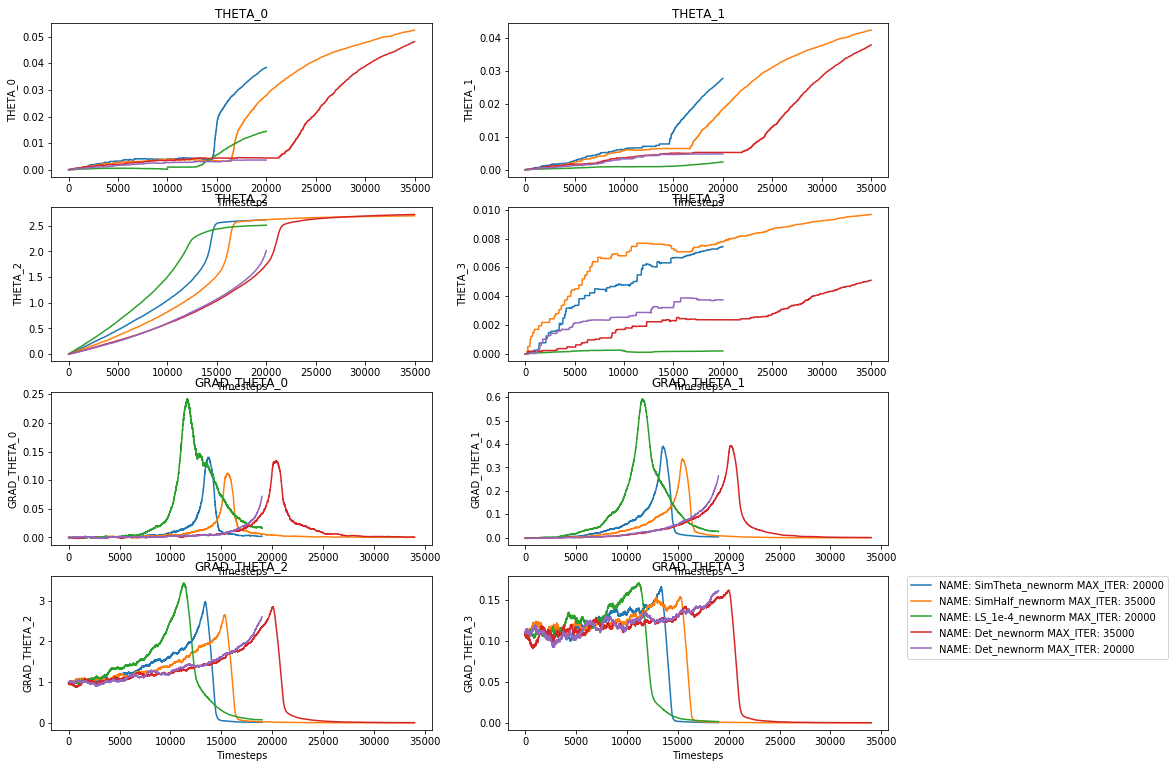

In [95]:
BASE_FOLDER = 'Cartpole/'

ddd = load_dataframe(BASE_FOLDER)

my_plot(#value=['J', 'J_DET', 'THETA_0', 'THETA_1', 'THETA_2', 'THETA_3', 'J+J_DET','BUDGET','SIGMA' ],
        value=['THETA_0', 'THETA_1', 'THETA_2', 'THETA_3', 'GRAD_THETA_0','GRAD_THETA_1','GRAD_THETA_2', 'GRAD_THETA_3' ],
        #value=['J', 'J_DET', 'SIGMA', 'BUDGET'],
        min_t = 0,
        max_t=-1,
        smooth=['GRAD_THETA_0','GRAD_THETA_1','GRAD_THETA_2', 'GRAD_THETA_3'],
        amount=1000,
        #name=['LS_5e-4', 'LS_5e-3', 'LS_1e-3', 'LS_1e-2', 'LS_1e-5', 'Det_nonorm '],
        name=['SimTheta_newnorm', 'SimHalf_newnorm', 'LS_1e-4_newnorm', 'Det_newnorm'],
        max_iter = ['20000', '35000'],
        df = ddd)

In [462]:
filtered_df = filter_experiments(df=ddd, max_iter='35000')

In [88]:
pol1 = get_policy(ddd, 'LS_1e-4_newnorm', 14000)

In [89]:
evaluate_policy(env2, pol1, H=1000, N=100, deterministic=True)

(551.49, 938.224141503249)

In [464]:
pol2 = get_policy(filtered_df, 'Det_newnorm', -1)

In [465]:
pol3 = get_policy(ddd, 'SimTheta_newnorm', -1)

In [466]:
pol4 = get_policy(filtered_df, 'SimHalf_newnorm', -1)

In [468]:
pol1.theta_mat

array([[1.44381740e-02, 2.32419109e-03, 2.51039317e+00, 2.13018750e-04]])

In [469]:
pol2.theta_mat

array([[0.04820598, 0.03788538, 2.71996124, 0.00510548]])

In [470]:
pol3.theta_mat

array([[0.03847276, 0.02771568, 2.61604843, 0.00744975]])

In [471]:
pol4.theta_mat

array([[0.05253169, 0.04236356, 2.69403703, 0.00966864]])

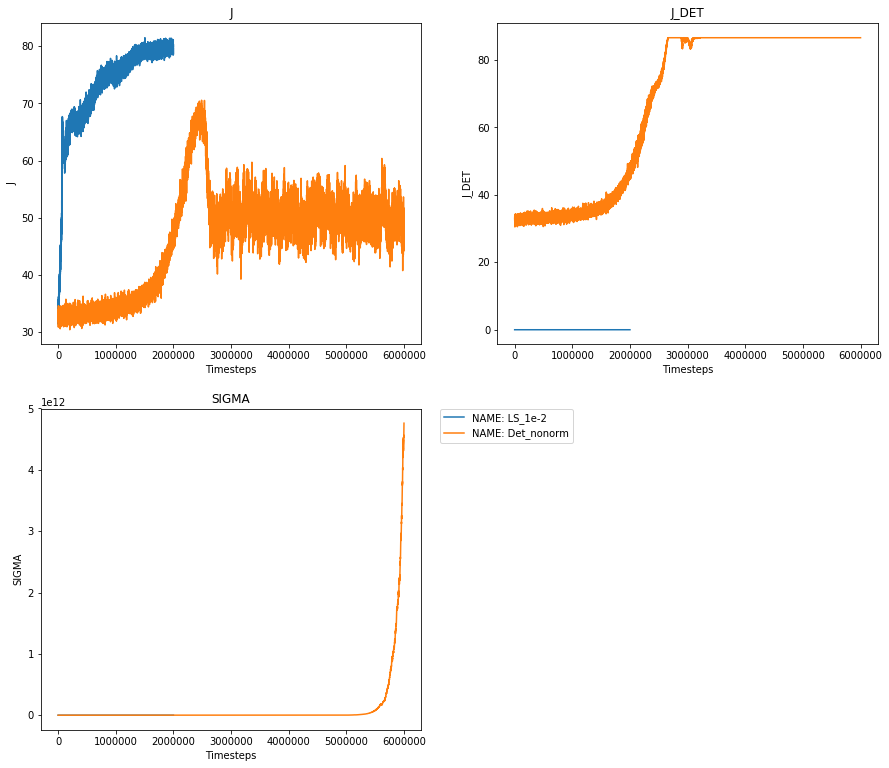

In [22]:
BASE_FOLDER = 'Cartpole/'

ddd = load_dataframe(BASE_FOLDER)

my_plot(#value=['J', 'J_DET', 'THETA_0', 'THETA_1', 'THETA_2', 'THETA_3', 'J+J_DET','BUDGET','SIGMA' ], 
        value=['J', 'J_DET', 'SIGMA'],
        min_t = 0,
        x = 'SAMPLES',
        max_t=-1,
        #smooth=['J', 'J+J_DET'],
        amount=1000,
        #name=['LS_5e-4', 'LS_5e-3', 'LS_1e-3', 'LS_1e-2', 'LS_1e-5', 'Det_nonorm '],
        name= ['Det_nonorm', 'LS_1e-2'],
        #max_iter = '20000',
        df = ddd)

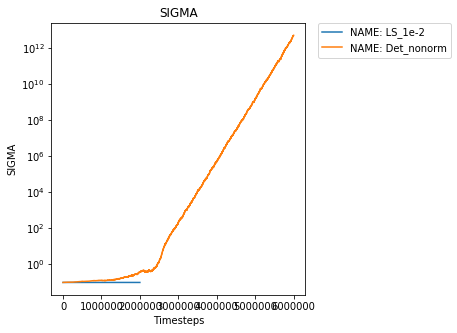

In [27]:
plt.figure(figsize=(10,5))
my_plot(#value=['J', 'J_DET', 'THETA_0', 'THETA_1', 'THETA_2', 'THETA_3', 'J+J_DET','BUDGET','SIGMA' ], 
        value=['SIGMA'],
        min_t = 0,
        x = 'SAMPLES',
        max_t=-1,
        #smooth=['J', 'J+J_DET'],
        amount=1000,
        #name=['LS_5e-4', 'LS_5e-3', 'LS_1e-3', 'LS_1e-2', 'LS_1e-5', 'Det_nonorm '],
        name= ['Det_nonorm', 'LS_1e-2'],
        #max_iter = '20000',
        df = ddd)

# Report

## Mountain Car

Sono partito da una politica buona, ma non ottima. La politica ha i valori `[-0.1, 0.3]`, sigma `0.1` e gamma `0.995`. I valori sono tali che la politica esplorativa vede il goal con probabilità ~40% ma quella deterministica non lo vede mai. 

Initial J+J_DET is:  0.4046673290630449
Average J+J_DET is:  -5.492486961221509
Initial J+J_DET is:  0.4326762825457108
Average J+J_DET is:  5.497693267446504
Budget is negative for:  0 / 25000  times
Budget is negative for:  1107 / 25000  times


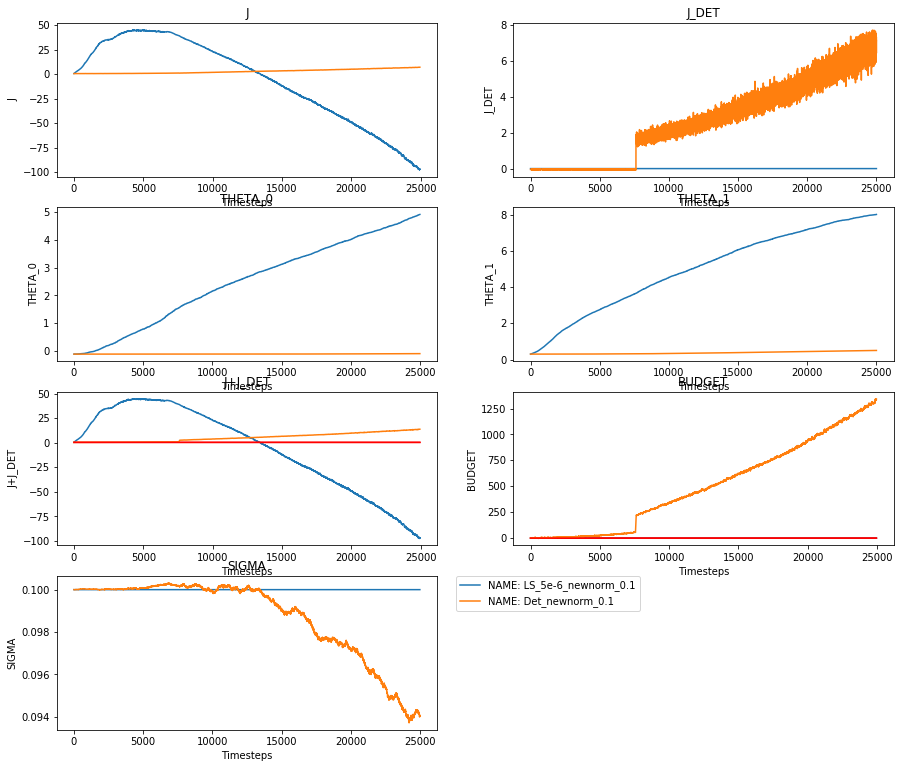

In [268]:
BASE_FOLDER = 'MountainCar/'

ddd = load_dataframe(BASE_FOLDER)

my_plot(value=['J', 'J_DET', 'THETA_0', 'THETA_1', 'J+J_DET','BUDGET','SIGMA' ], 
        min_t = 0,
        max_t=-1,
        smooth=['J', 'J+J_DET', 'BUDGET'],
        amount=50,
        name=None,
        theta_0='-0.1',
        max_iter='25000',
        df = ddd)

La linea blu è con uno step size costante di 5e-6 mentre l'arancio è la solita con la valutazione della politica deterministica. La politica con step size costante va quasi subito ad una politica quasi ottima, però poi continua a seguire i gradienti e dopo un po' ottiene valori troppo grandi per le azioni che penalizzano molto la performance. 
L'algoritmo safe invece è un po' più lento, circa allo step size 7000 la politica deterministica comincia a vedere il goal e acquisisce budget.

Ora ho lanciato un altro esperimento simile più lungo (40000 step) per vedere che cosa fa il nostro algoritmo. Io prevedo che la sigma aumenti un po', così come la prestazione. Raggiungerà più o meno lo stesso picco e però andrà giù un po' anche la nostra politica, perché quando arriverà al picco avrà un budget immenso da spendere e quindi butterà via tutto. 

Per normalizzare lo stato non ho usato i 12 kernel Gaussiani, perché facendo delle prove in locale non davano grandi risultati. Ho applicato una normalizzazione tra -1 e 1. Non ho fatto una normalizzazione sul batch, ma ho applicato un kernel fisso:
```
def normalize_mountain_car(s):
    return np.array([(s[0] + 0.3) / 0.9,s[1] / 0.07])
```


## Cartpole

Budget is negative for:  0 / 20000  times
Budget is negative for:  0 / 20000  times
Budget is negative for:  0 / 20000  times
Budget is negative for:  0 / 20000  times
Budget is negative for:  753 / 20000  times


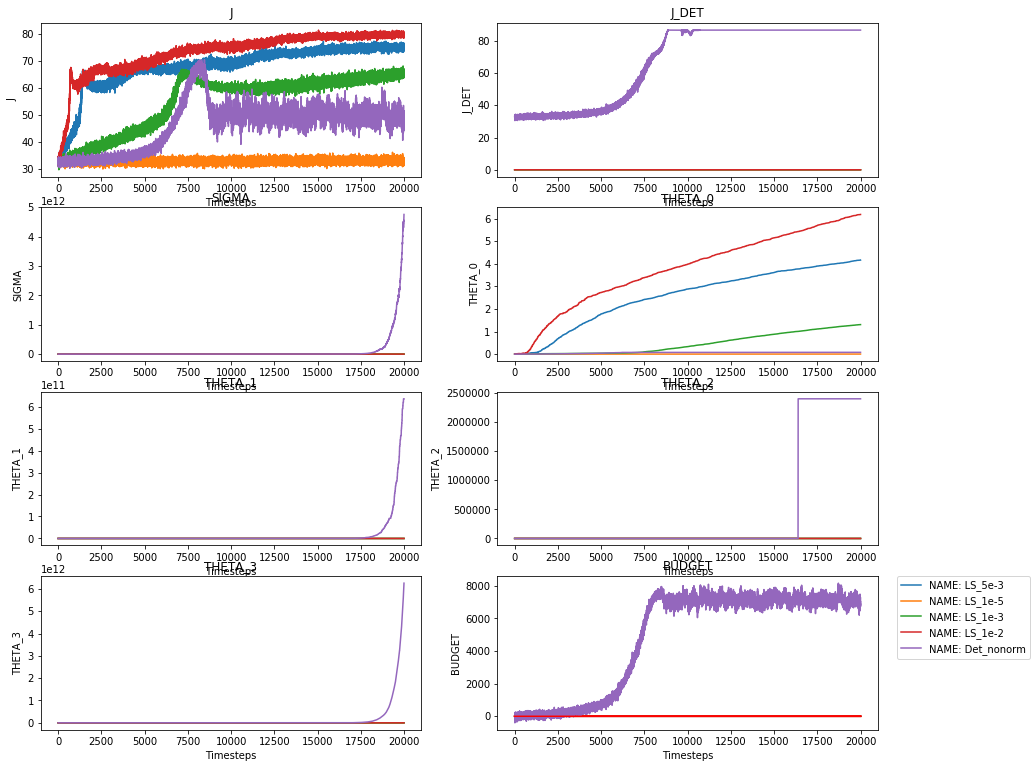

In [278]:
BASE_FOLDER = 'Cartpole/'

ddd = load_dataframe(BASE_FOLDER)

my_plot(value=['J', 'J_DET', 'SIGMA', 'THETA_0', 'THETA_1', 'THETA_2', 'THETA_3', 'BUDGET'],
        min_t = 0,
        max_t=-1,
        name=['LS_5e-4', 'LS_5e-3', 'LS_1e-3', 'LS_1e-2', 'LS_1e-5', 'Det_nonorm'],
        max_iter = '20000',
        df = ddd)

Gli esperimenti sono stati fatti con H=`200` e gamma=`0.99` e partendo da una politica `[0,0,0,0]`.

Per Cartpole non ho usato nessuna funzione di normalizzazione degli stati - per ora. Poi vedrò di fare una cosa simile a quella fatta con Mountain Car. 

Nel grafico si vedono diversi learning factor costanti contro il nostro con politica deterministica. Come ti avevo già accennato, la sigma la punta a infinito, così come alcuni valori di theta. Allo step ~8500 trova una politica ottima che ottiene il massimo reward. 

Il rosso (learning factor costante a 0.01) ottiene un valore sulla policy deterministica ~81 mentre quella ottima è ~86.

### Cartpole con asta più lunga

Ho trovato la politica migliore come la politica con la theta più piccola che ottenesse il massimo score: `[0.079124,1.9605,0.15667,15.945]`. 

Ho allungato l'asta da 0.5 a 1.

Budget is negative for:  0 / 10000  times
Budget is negative for:  5761 / 10000  times


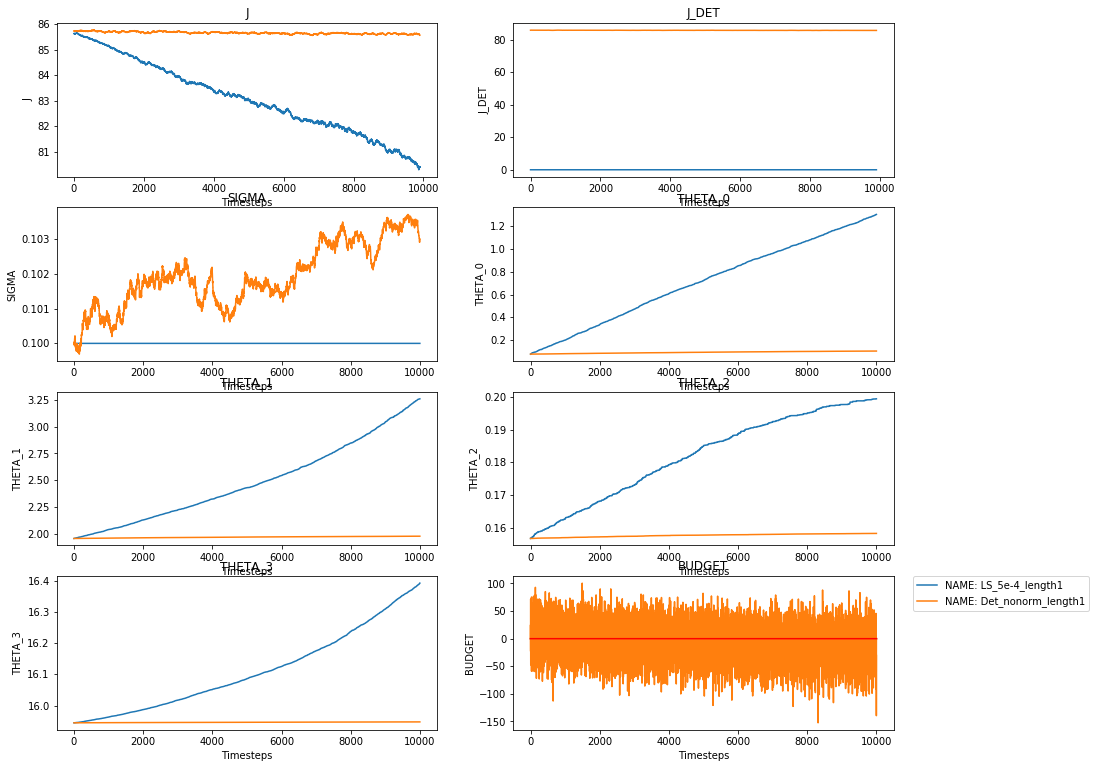

In [32]:
BASE_FOLDER = 'Cartpole/'

ddd = load_dataframe(BASE_FOLDER)

my_plot(value=['J', 'J_DET', 'SIGMA', 'THETA_0', 'THETA_1', 'THETA_2', 'THETA_3', 'BUDGET'],
        min_t = 0,
        smooth=['J', 'J_DET'],
        amount=100,
        max_t=-1,
        name=['LS_5e-4_length1', 'Det_nonorm_length1'],
        df = ddd)

Quello che è successo è che seguire il gradiente peggiora la policy: quella con learning factor costante perde, mentre la nostra safe non peggiora più di tanto (anche se facendo una moving average si vede come il budget diminuisce gradualmente). Ma almeno contiene la perdita.

Budget is negative for:  5761 / 10000  times


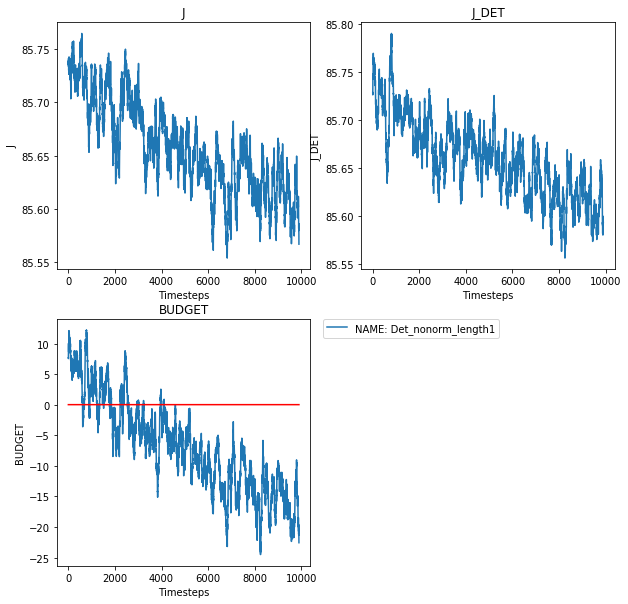

In [363]:
BASE_FOLDER = 'Cartpole/'

ddd = load_dataframe(BASE_FOLDER)
plt.figure(figsize=(10,10))
my_plot(value=['J', 'J_DET', 'BUDGET'],
        min_t = 0,
        max_t=-1,
        smooth=['J', 'J_DET', 'BUDGET'],
        amount=100,
        name=['Det_nonorm_length1'],
        df = ddd)

## Pendulum

Obiettivo di pendulum è quello di mantenere l'asta in verticale, ma tutto quello che riesce ad imparare sia il nostro algoritmo sia una politica a learning factor costante è far girare l'asta il più velocemente possibile. 

Può darsi che sia un limite alla politica lineare: ho provato a normalizzare e a mettere dei kernel gaussiani (come avevo provato per Mountain Car) ma non ha sortito nessun effetto: continua a vedre gradiente positivo su tutte le componenti, risultando in un'asta che gira molto veloce come un'elica. 

Anche volendo fare fine tuning, non riesco a trovare una buona politica lineare che faccia stare l'asta in verticale.